# Figure 3:  RNA and ATAC, P9855

Here we study the chromatin accessibility (ATAC peak heights), gene expression (mRNA counts), and a bit of protein abundance for experiment P9855.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
from IPython.display import display # Pretty display of data frames.

# Plotting
import matplotlib.pyplot as plt  # For basic plotting.
import matplotlib.transforms as transforms
import matplotlib.colors as pcolors
from matplotlib.patches import Rectangle
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

# Stats and scipy
import statsmodels.api as sm
import scipy.stats as ss
import scipy.cluster.hierarchy as sch # For hierarchical clustering.


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

In [3]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6
    
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    font = findfont(FontProperties(family=['sans-serif']))

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

In [4]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

In [6]:
import matplotlib.font_manager as fm
from matplotlib.font_manager import findfont, FontProperties

font = fm.FontProperties(
        family = 'Helvetica', fname = '/System/Library/Fonts/Helvetica.ttc')

In [7]:
plt.rcParams['font.sans-serif'] = 'Helvetica'

font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/Helvetica.ttc'

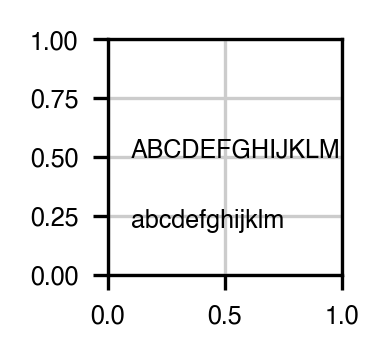

In [8]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
plt.show()

# Loading data

In [9]:
import anndata

adata = anndata.read_loom('../Data/Processed/P9855.loom')
adata.var_names = adata.var['gene_name']
adata.obs_names = adata.obs['obs_names']

prot_data = anndata.read_loom('../Data/Processed/P9855_protein.loom')
prot_data.var_names = prot_data.var['var_names']
prot_data.obs_names = prot_data.obs['obs_names']

ATAC_data = anndata.read_loom('../Data/Processed/P9855_ATAC.loom')
ATAC_data.var_names = ATAC_data.var['PeakID']
ATAC_data.obs_names = ATAC_data.obs['Sample_name']

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
adata

AnnData object with n_obs × n_vars = 70 × 9553
    obs: 'Clone_ID', 'Good clone', 'Number_Of_Cells', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt'
    var: 'ENSG', 'F_pval', 'GC_content', 'TSS', 'chr', 'dir', 'end', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells_by_counts', 'pct_dropout_by_counts', 'start', 'total_counts', 'transcript_length', 'variances', 'variances_norm'

In [11]:
prot_data

AnnData object with n_obs × n_vars = 24213 × 8
    obs: 'Clone_ID', 'Clone_Name_Well_ID', 'FSC-A', 'FSC-H', 'FSC-W', 'Numerical_ID', 'Plate', 'SSC-A', 'SSC-H', 'SSC-W', 'SampleID', 'obs_names'
    var: 'gene', 'var_names'

In [12]:
ATAC_data

AnnData object with n_obs × n_vars = 29 × 79857
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'max_height', 'mid', 'start'

In [13]:
len(ATAC_data.obs.Clone_ID.value_counts())

23

## Insert small peak filter

Based on some undesirable noise among low peaks, we remove all peak intervals in which the highest peak is below 30.

In [14]:
good_peaks = ATAC_data.var[ATAC_data.var.max_height >= 30].index
len(good_peaks)

26040

In [15]:
ATAC_data = ATAC_data[:,good_peaks]
ATAC_data

View of AnnData object with n_obs × n_vars = 29 × 26040
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'max_height', 'mid', 'start'

In [16]:
ATACR_data = ATAC_data[ATAC_data.obs['Is_replicate'] == True, :]
ATACR_data

View of AnnData object with n_obs × n_vars = 12 × 26040
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'max_height', 'mid', 'start'

# Distance from peaks to genes

Here we create dataframes for each chromosome, to track which peaks are within the window around each gene.  The window we use includes the length of the gene (+ 5000 after the end) together with the region 55000 bp upstream of the TSS.  The extra 5000 on each end is a little tolerance factor, just to avoid a few close calls, narrow peaks, etc.

In [17]:
near_dfs = {}
for chrome in ATAC_data.var['chr'].unique():
    AT_df = ATAC_data.var[ATAC_data.var['chr'] == chrome]['mid']
    g_df = adata.var[adata.var['chr'] == chrome]
    upstream = g_df['TSS'] - 55000 * g_df['dir']
    downstream = g_df['end'] + 5000*g_df['dir']
    gpos_df = pd.DataFrame(index=g_df.index)
    gpos_df['up'] = upstream
    gpos_df['down'] = downstream
    gpos_df['min'] = gpos_df[['up','down']].min(axis=1)
    gpos_df['max'] = gpos_df[['up','down']].max(axis=1)
    peakups = np.less_equal.outer(gpos_df['min'].values,AT_df.values)
    peakdowns = np.less_equal.outer(AT_df.values, gpos_df['max'].values).T
    near_dfs[chrome] = pd.DataFrame(peakups & peakdowns, index = gpos_df.index, columns=AT_df.index)

In [18]:
near_dfs['3']

PeakID        Interval_51938  Interval_49328  Interval_51334  Interval_51370  \
gene_name                                                                      
TRNT1                  False           False           False           False   
CRBN                   False           False           False           False   
RP11-97C16.1           False           False           False           False   
SUMF1                  False           False           False           False   
SETMAR                 False           False           False           False   
...                      ...             ...             ...             ...   
FYTTD1                 False           False           False           False   
LRCH3                  False           False           False           False   
AC144530.1             False           False           False           False   
IQCG                   False           False           False           False   
RPL35A                 False           False           False           False   

PeakID        Interval_48193  Interval_49086  Interval_51136  Interval_50990  \
gene_name                                                                      
TRNT1                  False           False           False           False   
CRBN                   False           False           False           False   
RP11-97C16.1           False           False           False           False   
SUMF1                  False           False           False           False   
SETMAR                 False           False           False           False   
...                      ...             ...             ...             ...   
FYTTD1                 False           False           False           False   
LRCH3                  False           False           False           False   
AC144530.1             False           False           False           False   
IQCG                   False           False           False           False   
RPL35A                 False           False           False           False   

PeakID        Interval_49039  Interval_50871  ...  Interval_51780  \
gene_name                                     ...                   
TRNT1                  False           False  ...           False   
CRBN                   False           False  ...           False   
RP11-97C16.1           False           False  ...           False   
SUMF1                  False           False  ...           False   
SETMAR                 False           False  ...           False   
...                      ...             ...  ...             ...   
FYTTD1                 False           False  ...           False   
LRCH3                  False           False  ...           False   
AC144530.1             False           False  ...           False   
IQCG                   False           False  ...           False   
RPL35A                 False           False  ...           False   

PeakID        Interval_50930  Interval_48687  Interval_49185  Interval_51979  \
gene_name                                                                      
TRNT1                  False           False           False           False   
CRBN                   False           False           False           False   
RP11-97C16.1           False           False           False           False   
SUMF1                  False           False           False           False   
SETMAR                 False           False           False           False   
...                      ...             ...             ...             ...   
FYTTD1                 False           False           False           False   
LRCH3                  False           False           False           False   
AC144530.1             False           False           False           False   
IQCG                   False           False           False           False   
RPL35A                 False           False           False

In [19]:
adata.var['near_peaks'] = pd.Series( {g : [] for g in adata.var_names}) # Initialize to empty.
for chrome in near_dfs.keys():
    chr_genes = near_dfs[chrome].index
    adata.var.loc[chr_genes,'near_peaks'] = near_dfs[chrome].apply(lambda x: list(x.index[x == 1]), axis=1)
adata.var

ENSG    F_pval  GC_content        TSS chr  dir  \
gene_name                                                                  
MTND2P28       ENSG00000225630  0.500309       43.10     565020   1    1   
hsa-mir-6723   ENSG00000237973  0.021218       45.76     566454   1    1   
MTATP6P1       ENSG00000248527  0.000096       43.91     569076   1    1   
RP11-206L10.9  ENSG00000237491  0.704243       40.42     714150   1    1   
LINC01128      ENSG00000228794  0.667158       46.34     762988   1    1   
...                        ...       ...         ...        ...  ..  ...   
TMLHE-1        ENSG00000185973  0.004259       37.38  154842597   X   -1   
VAMP7          ENSG00000124333  0.436949       38.78  155110956   X    1   
SRIP3          ENSG00000224953  0.456741       50.68    6587221   Y   -1   
AC010970.2     ENSG00000225840  0.000100       51.25   10036711   Y   -1   
RNA5-8SP6      ENSG00000251705  0.766057       51.97   10037764   Y    1   

                     end      gene_name  highly_variable  \
gene_name                                                  
MTND2P28          566063       MTND2P28                0   
hsa-mir-6723      567996   hsa-mir-6723                0   
MTATP6P1          569756       MTATP6P1                0   
RP11-206L10.9     745440  RP11-206L10.9                0   
LINC01128         794826      LINC01128                0   
...                  ...            ...              ...   
TMLHE-1        154899605        TMLHE-1                0   
VAMP7          155173433          VAMP7                1   
SRIP3            6587221          SRIP3                0   
AC010970.2      10036711     AC010970.2                0   
RNA5-8SP6       10037915      RNA5-8SP6                0   

               highly_variable_rank  ...       means  mt  n_cells_by_counts  \
gene_name                            ...                                      
MTND2P28                        NaN  ...   37.642857   0                 67   
hsa-mir-6723                    NaN  ...   13.585714   0                 63   
MTATP6P1                        NaN  ...  312.728571   0                 69   
RP11-206L10.9                   NaN  ...    1.400000   0                  5   
LINC01128                       NaN  ...    2.485714   0                  4   
...                             ...  ...         ...  ..                ...   
TMLHE-1                         NaN  ...   39.785714   0                 28   
VAMP7                        3862.0  ...   58.671429   0                 27   
SRIP3                           NaN  ...    2.885714   0                 59   
AC010970.2                      NaN  ...  777.042857   0                 69   
RNA5-8SP6                       NaN  ...    4.471429   0                 33   

               pct_dropout_by_counts      start  total_counts  \
gene_name                                                       
MTND2P28                    4.285714     565020    203.999100   
hsa-mir-6723               10.000000     566454    107.062729   
MTATP6P1                    1.428571     569076    380.220612   
RP11-206L10.9              92.857143     714150     12.996776   
LINC01128                  94.285714     762988     12.210242   
...                              ...        ...           ...   
TMLHE-1                    60.000000  154719776    100.728165   
VAMP7                      61.428571  155110956    102.709625   
SRIP3                      15.714286    6587003    129.840927   
AC010970.2                  1.428571   10036113    455.621613   
RNA5-8SP6                  52.857143   10037764    107.644501   

               transcript_length      variances  variances_norm  \
gene_name                                                         
MTND2P28             1044.000000     388.754658        0.069281   
hsa-mir-6723         1543.000000     137.753416        0.087108   
MTATP6P1              681.000000   25071.186128        0.411845   
RP11-206L10.9         704.000000      34.765217

In [20]:
ATAC_data.var['near_genes'] = pd.Series( {p : [] for p in ATAC_data.var_names}) # Initialize to empty.
for chrome in near_dfs.keys():
    chr_peaks = near_dfs[chrome].columns
    ATAC_data.var.loc[chr_peaks,'near_genes'] = near_dfs[chrome].apply(lambda x: list(x.index[x == 1]), axis=0)
ATAC_data.var

Trying to set attribute `.var` of view, copying.


PeakID chr        end          in_ensg    in_gene  \
PeakID                                                                      
Interval_51938  Interval_51938   3  156852899             None        nan   
Interval_13433  Interval_13433  11   82997741  ENSG00000137500    CCDC90B   
Interval_27763  Interval_27763  16   68564473  ENSG00000184939      ZFP90   
Interval_53540  Interval_53540   4    7967411  ENSG00000163995     ABLIM2   
Interval_4280    Interval_4280   1  153644524  ENSG00000143621       ILF2   
...                        ...  ..        ...              ...        ...   
Interval_76540  Interval_76540   9   95394458  ENSG00000127080       IPPK   
Interval_57434  Interval_57434   4  186347634  ENSG00000205129    C4orf47   
Interval_28417  Interval_28417  16   88730354  ENSG00000167508        MVD   
Interval_45676  Interval_45676  21   35310937  ENSG00000237945  LINC00649   
Interval_8387    Interval_8387  10   33624658  ENSG00000099250       NRP1   

                       itype  max_height          mid      start  \
PeakID                                                             
Interval_51938      Intergen   30.484531  156852750.0  156852601   
Interval_13433  promoter-TSS  301.373993   82997180.5   82996620   
Interval_27763  promoter-TSS   55.443851   68564084.5   68563696   
Interval_53540           TTS   51.684944    7966923.5    7966436   
Interval_4280   promoter-TSS  189.036240  153643788.5  153643053   
...                      ...         ...          ...        ...   
Interval_76540        intron   35.414658   95394099.5   95393741   
Interval_57434  promoter-TSS  201.101425  186347041.5  186346449   
Interval_28417  promoter-TSS  136.937515   88729670.5   88728987   
Interval_45676          exon   34.971249   35310572.5   35310208   
Interval_8387   promoter-TSS  118.396484   33623619.5   33622581   

                               near_genes  
PeakID                                     
Interval_51938                         []  
Interval_13433                  [CCDC90B]  
Interval_27763                    [ZFP90]  
Interval_53540                         []  
Interval_4280                      [ILF2]  
...                                   ...  
Interval_76540                         []  
Interval_57434                    [UFSP2]  
Interval_28417  [CYBA, MVD, CTU2, PIEZO1]  
Interval_45676         [ATP5O, LINC00649]  
Interval_8387                      [NRP1]  

[26040 rows x 10 columns]

# Quick ATAC plotting tool

We create a quick exploratory tool for plotting ATAC peaks, focusing on clones with replicates, and the sister clones 5a/5b.  We assign a modified clone label, for coloring purposes.

In [21]:
clones_focus = ['1', '15', '22', '23', '8', '9', '5a', '5b']

def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip in clones_focus:
        return cl_strip #'Clone '+cl_strip[5:]
    else:
        return 'Other'

ATAC_data.obs['colorclone'] = ATAC_data.obs['ATAC_clone'].map(lambda cl : clone_rename(cl))


In [22]:
mm = 1 / 25.4
def ATAC_plot(peak):
    fig,ax = plt.subplots(1,1,figsize=(80*mm,20*mm), dpi=300)
    sns.set_style('whitegrid')
    setfontsize()
    peak_heights = np.exp(pd.DataFrame(ATAC_data.to_df()[peak])) - 1
    peak_heights.columns = ['height']
    peak_heights['parent'] = ATAC_data.obs.ATAC_clone.apply(lambda c : c.split('_')[0])
    peak_heights['hue'] = ATAC_data.obs.colorclone
    sns.scatterplot(x='parent', y='height', color='gray', data=peak_heights[peak_heights['hue'] == 'Other'], 
                    legend=False, ax=ax,s=20)
    
    sns.scatterplot(x='parent', y='height', hue='hue', edgecolor='k',
                    data=peak_heights[peak_heights['hue'] != 'Other'], 
                    legend=False, ax=ax, s=20, alpha=0.8)
    
    ax.set_ylabel('Peak height')
    ax.set_xlabel('Clone')
    ax.tick_params(axis='both', pad=-1)
    plt.suptitle('Heights (absolute) for {}'.format(peak), y=1.05, x=0.55)
    plt.show()

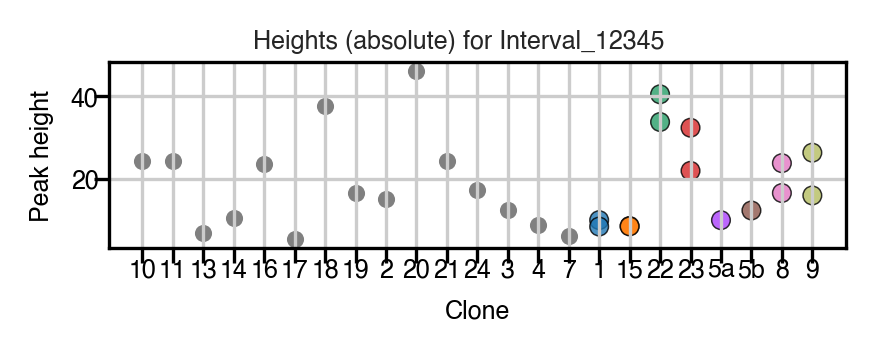

In [23]:
ATAC_plot('Interval_12345')

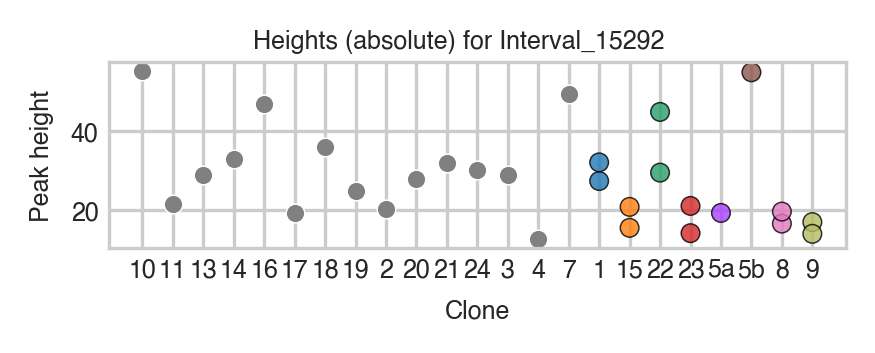

In [24]:
ATAC_plot('Interval_15292')

# Quick figure, IL2RG

By popular demand, here's a little figure related to IL2RG:  population and clonal expression.

In [25]:
IL2RG = adata.to_df()['IL2RG']
IL2RG

obs_names
P9855_2001    7.647796
P9855_2002    7.847446
P9855_2003    8.209406
P9855_2004    7.989888
P9855_2005    8.086321
                ...   
P9855_2078    7.710776
P9855_2079    7.536000
P9855_2080    7.653312
P9855_2081    7.993894
P9855_2082    8.372787
Name: IL2RG, Length: 70, dtype: float32

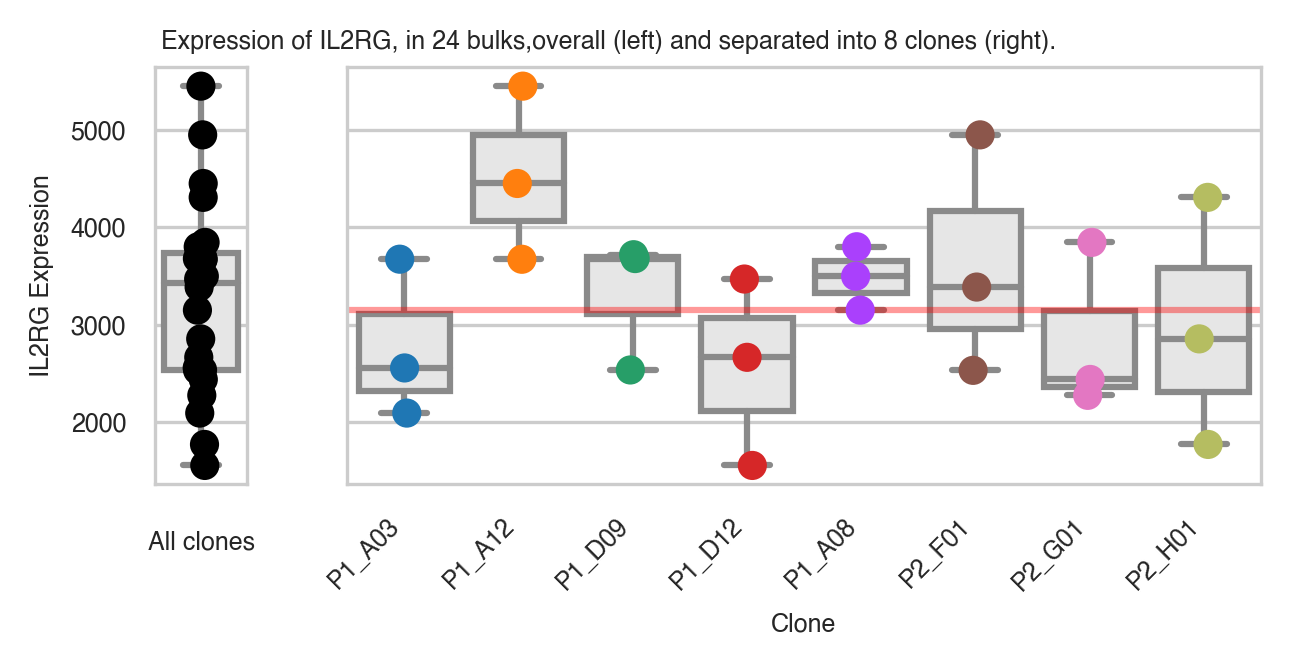

In [26]:
fig,ax = plt.subplots(1,2, sharey = True, figsize=(120*mm,45*mm), dpi=300, 
                      gridspec_kw = {'width_ratios':[1,10]})

allplot_df = pd.DataFrame(np.exp(IL2RG) - 1) # Remove log-normalization.
#allplot_df = pd.DataFrame(IL2RG) # Use log-normalized data?
allplot_df.columns=['IL2RG Expression']
allplot_df['Clone'] = adata.obs['Clone_ID']
allmean = allplot_df['IL2RG Expression'].median()

randclones = allplot_df['Clone'].value_counts()[:8].index
allplot_df = allplot_df[allplot_df['Clone'].isin(randclones)]

sns.boxplot(y='IL2RG Expression', color=(0.9,0.9,0.9,1), data = allplot_df, ax=ax[0], orient='v', whis=np.inf)
sns.stripplot(y='IL2RG Expression', color='black', data = allplot_df, 
              jitter=0.05, ax=ax[0], orient='v',s=7.0)

sns.boxplot(y='IL2RG Expression', x='Clone', color=(0.9,0.9,0.9,1), data = allplot_df, 
            ax=ax[1], orient='v', whis=np.inf)

sns.stripplot(y='IL2RG Expression', x='Clone', hue='Clone', data = allplot_df, 
              jitter=0.05, ax=ax[1], orient='v',s=7.0)

ax[0].set_xlabel('All clones')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45, ha="right")
ax[1].axhline(allmean, color=(1,0,0,0.4))
ax[1].set_ylabel('')
ax[1].legend_.remove()

plt.suptitle('Expression of IL2RG, in {} bulks,'
             'overall (left) and separated into {} clones (right).'.format(len(allplot_df), len(allplot_df['Clone'].unique())))
plt.show()

# Panel:  PCA and UMAP Clustering based on ATAC peak heights

We cluster bulks by ATAC peaks using UMAP here (just for old time's sake).

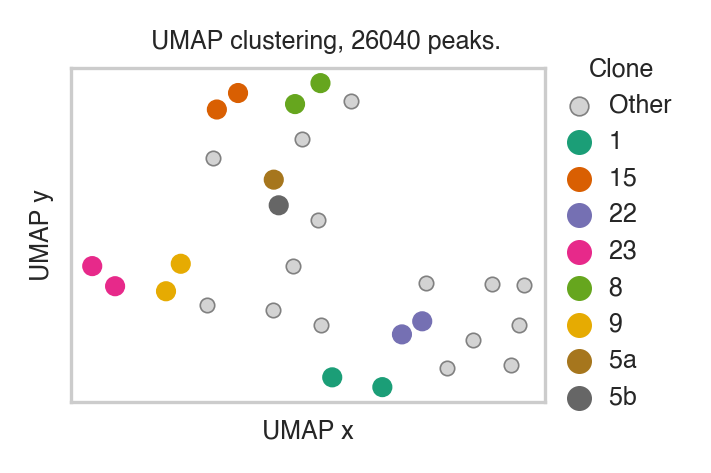

In [27]:
n_components = 10
n_neighbors = 5
min_dist = 0.25

mm = 1/25.4
figsize = (60*mm, 40*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

X = ATAC_data.to_df().copy()
y = ATAC_data.obs['colorclone']

hue_order = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]
hue_order = ['  ' + hue for hue in hue_order]
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X) # Apply PCA with 10 components.
X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
cl_df['Clone'] = '  ' + y
#display(cl_df)

sns.scatterplot(x='UMAP x', y='UMAP y', data = cl_df[cl_df['Clone'] == '  Other'], s=12, 
                color='lightgray', edgecolor='gray', linewidth=0.4, ax=ax, label='  Other')

sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', hue_order = hue_order, palette='Dark2',
                data = cl_df[cl_df['Clone'] != '  Other'], s=20, edgecolor=None, ax=ax)

ax.set_xticks([])
ax.set_yticks([])

lgnd = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.1), ncol=1, framealpha=0.0, title='Clone')

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [20]
for j in range(1,9):
    lgnd.legendHandles[j]._sizes = [25]

plt.suptitle("UMAP clustering, {} peaks.".format(len(X.T)), 
            x=0.6, y=1.0)

set_size(fig, figsize)
plt.savefig("Panels/UMAP.pdf", bbox_inches='tight')

plt.show()

In [28]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import squareform, pdist

n_comp_array = np.arange(1,21) # PCA components.  Can't be more than the number of samples!
ATAC_df = ATAC_data.to_df()
ATAC_df.index = 'clone'+ATAC_data.obs['ATAC_clone']
ATAC_df = ATAC_df.T
clr_list = ['1', '15', '22', '23', '8', '9', '5a', '5b']

def clone_rename(cl):
    cl_strip = cl.split('_')[0]
    if cl_strip[5:] in clr_list:
        return 'Clone '+cl_strip[5:]
    else:
        return 'Other'

X = ATAC_df.T
y = [clone_rename(cl) for cl in ATAC_df.columns]

hue_order = ['Clone '+a for a in clr_list]

dist_df = pd.DataFrame(index = n_comp_array, 
                           columns = ['rep_dist_rel', 'sis_dist_rel', 'nonrep_dist'])

dmf = {}
dmf_df = {}
for n_comp in n_comp_array:
    pca = PCA(n_components=n_comp)
    X_PCA = pca.fit_transform(X)
    dm_raw = pd.DataFrame(distance_matrix(X_PCA, X_PCA), index=X.index, columns=X.index)
    rep_dist = np.array([dm_raw.loc['clone'+num+'_R1', 'clone'+num+'_R2'] for num in ['1','15','22','23','8','9']])
    nonreps = [cl for cl in X.index if cl.split('_')[0] not in ['clone'+num for num in clr_list]]
    dm_nonrep = dm_raw.loc[nonreps][nonreps]
    dmf[n_comp] = dm_nonrep.values.flatten()
    dmf[n_comp] = np.array([v for v in dmf[n_comp] if v > 0])
    dmf_df[n_comp] = pd.DataFrame(dmf[n_comp] / dmf[n_comp].mean())
    dmf_df[n_comp]['n_comp'] = n_comp
    nonrep_dist = dmf[n_comp].mean()
    sis_dist = dm_raw.loc['clone5a_R1','clone5b_R1']
    dist_df.loc[n_comp] = pd.Series(
        {'rep_dist_rel':rep_dist.mean() / nonrep_dist.mean(),
         'sis_dist_rel':sis_dist / nonrep_dist.mean(),
         'nonrep_dist':nonrep_dist})
dist_df['PCs'] = dist_df.index
display(dist_df)

rep_dist_rel sis_dist_rel nonrep_dist  PCs
1      0.071543     1.329573    14.33259    1
2      0.075824      0.87877   21.988037    2
3      0.057735     0.649843   34.427305    3
4      0.051327     0.562202   41.399753    4
5      0.053097     0.498053   47.895557    5
6      0.051868     0.477116   51.492105    6
7      0.051826     0.542253   56.062443    7
8      0.049362       0.5151   59.982811    8
9       0.04995     0.483983   62.554093    9
10     0.052737     0.484768   65.361131   10
11     0.051547     0.467192   68.748532   11
12     0.050445     0.464812   72.012223   12
13     0.049078      0.45046   74.908355   13
14     0.047412     0.446026   78.525506   14
15     0.046363     0.446002   80.564363   15
16     0.045579     0.443783   83.523727   16
17     0.045173     0.482995   86.217079   17
18     0.044913     0.470123   88.848161   18
19     0.045199     0.464979   91.409922   19
20     0.045132     0.467658   93.344562   20

In [29]:
nonrep_dist_df = pd.concat([dmf_df[j] for j in dmf_df.keys()])
nonrep_dist_df.columns = ['dist','n_comp']

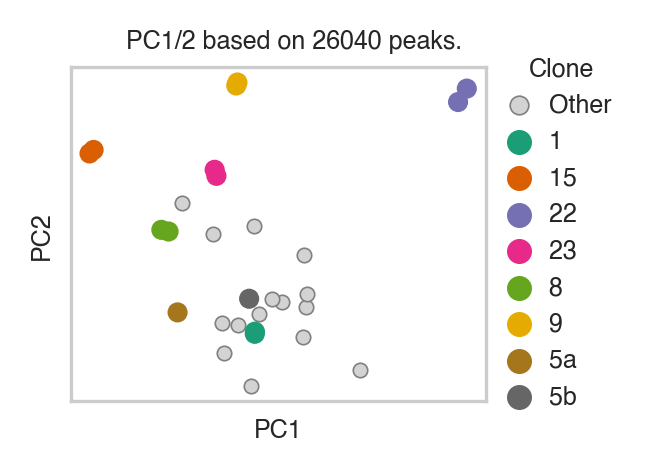

In [30]:
mm = 1/25.4
figsize = (55*mm, 40*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

X = ATAC_data.to_df().copy()
# X = X[tall_peaks]
y = ATAC_data.obs['colorclone']

hue_order = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]
hue_order = ['  ' + hue for hue in hue_order]
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X) # Apply PCA with 20 components.

cl_df = pd.DataFrame(X_pca, columns = ['PC{}'.format(j) for j in range(1,21)], index=X.index) # Just for graphing.
cl_df['Clone'] = '  ' + y
#display(cl_df)

sns.scatterplot(x='PC1', y='PC2', data = cl_df[cl_df['Clone'] == '  Other'], s=12, 
                color='lightgray', edgecolor='gray', linewidth=0.4, ax=ax, label='  Other')

sns.scatterplot(x='PC1', y='PC2', hue='Clone', hue_order = hue_order, palette='Dark2',
                data = cl_df[cl_df['Clone'] != '  Other'], s=20, edgecolor=None, ax=ax)

ax.set_xticks([])
ax.set_yticks([])

lgnd = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.1), ncol=1, framealpha=0.0, title='Clone')

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [20]
for j in range(1,9):
    lgnd.legendHandles[j]._sizes = [25]

plt.suptitle("PC1/2 based on {} peaks.".format(len(X.T)), 
            x=0.6, y=1.0)

set_size(fig, figsize)
plt.savefig("Panels/PC_peakplot.pdf", bbox_inches='tight')

plt.show()

In [31]:
phenotypes = ['MEM','INT','EFF']
phenopal = {'MEM':'blue','INT':'orange','EFF':'red'}

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

phenopal_light = {key:lighten_color(phenopal[key], 0.25) for key in phenopal.keys()}
phenopal_light

{'MEM': (0.75, 0.75, 1.0),
 'INT': (1.0, 0.9117647058823529, 0.75),
 'EFF': (1.0, 0.75, 0.75)}

In [32]:
invivo_genes = pd.read_csv('../Data/Invivo_genes.csv', index_col = 0)
invivo_genes = invivo_genes.loc[ [gene for gene in invivo_genes.index if gene in adata.var_names]]
genes_ct = invivo_genes[invivo_genes.celltype].index
genes_nct = invivo_genes[~invivo_genes.celltype].index
print(genes_ct)

Index(['GZMH', 'NKG7', 'FGFBP2', 'GZMB', 'GPR56', 'GNLY', 'FCGR3A', 'S1PR5',
       'FLNA-1', 'PRF1', 'EFHD2', 'CST7', 'AOAH', 'ITGAL', 'APMAP', 'CCL4',
       'KLRD1', 'FAM211A-AS1', 'RPSA', 'DGKA', 'RPL4', 'RPLP0', 'LDHB',
       'NOSIP', 'SELL', 'IL7R', 'CCR7', 'GZMK', 'LTB'],
      dtype='object')


In [33]:
genes_ct_exp = [gene for gene in genes_ct if gene in adata.var_names]
print(genes_ct_exp)

['GZMH', 'NKG7', 'FGFBP2', 'GZMB', 'GPR56', 'GNLY', 'FCGR3A', 'S1PR5', 'FLNA-1', 'PRF1', 'EFHD2', 'CST7', 'AOAH', 'ITGAL', 'APMAP', 'CCL4', 'KLRD1', 'FAM211A-AS1', 'RPSA', 'DGKA', 'RPL4', 'RPLP0', 'LDHB', 'NOSIP', 'SELL', 'IL7R', 'CCR7', 'GZMK', 'LTB']


In [34]:
peaks_ct = [peak for gene in genes_ct_exp for peak in adata.var.loc[gene, 'near_peaks']]
len(peaks_ct) # peaks neaer celltype genes

131

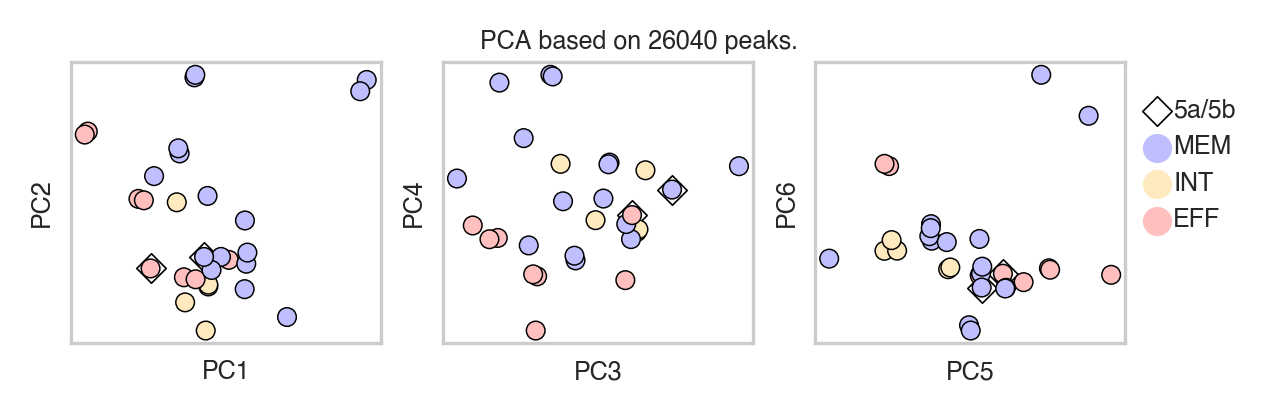

In [35]:
figsize = (108*mm, 35*mm)
fig, ax = plt.subplots(1,3,figsize=figsize, dpi=300)
setfontsize()

X = ATAC_data.to_df().copy()
# X = X[tall_peaks]
y = ATAC_data.obs.founder_pheno

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X) # Apply PCA with 20 components.

cl_df = pd.DataFrame(X_pca, columns = ['PC{}'.format(j) for j in range(1,21)], index=X.index) # Just for graphing.
cl_df['Founder phenotype'] = y
cl_df['Clone'] = ATAC_data.obs['colorclone']
hue_order = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]
#hue_order = ['  ' + hue for hue in hue_order]
#display(cl_df)



sns.scatterplot(x='PC1', y ='PC2', color='white', data=cl_df[cl_df['Clone'].isin(['5a','5b'])],
               s=25, edgecolor='k', ax=ax[0], legend=False, marker='D')
sns.scatterplot(x='PC1', y='PC2', hue='Founder phenotype', hue_order=phenotypes, palette=phenopal_light,
                data = cl_df, s=20, edgecolor='k', ax=ax[0], legend=False)

sns.scatterplot(x='PC3', y ='PC4', color='white', data=cl_df[cl_df['Clone'].isin(['5a','5b'])],
               s=25, edgecolor='k', ax=ax[1], legend=False, marker='D')
sns.scatterplot(x='PC3', y='PC4', hue='Founder phenotype', hue_order=phenotypes, palette=phenopal_light,
                data = cl_df, s=20, edgecolor='k', ax=ax[1], legend=False)

sns.scatterplot(x='PC5', y ='PC6', color='white', data=cl_df[cl_df['Clone'].isin(['5a','5b'])],
               s=25, edgecolor='k', ax=ax[2], marker='D', label='5a/5b')
sns.scatterplot(x='PC5', y='PC6', hue='Founder phenotype', hue_order=phenotypes, palette=phenopal_light,
                data = cl_df, s=20, edgecolor='k', ax=ax[2])

#sns.scatterplot(x='PC1', y='PC2', hue='Clone', palette='Dark2', hue_order = hue_order,
#                data = cl_df[cl_df['Clone'] != 'Other'], s=2, edgecolor=None, ax=ax)

for j in range(3):
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].tick_params(axis='both', pad=-2)

lgnd = ax[2].legend(loc='upper left', bbox_to_anchor=(1.01, 0.95), ncol=1, framealpha=0.0)

#change the marker size manually for both lines
#lgnd.legendHandles[0]._sizes = [20]
#for j in range(1,9):
#    lgnd.legendHandles[j]._sizes = [25]

plt.suptitle("PCA based on {} peaks.".format(len(X.T)), 
            x=0.6, y=1.0)

set_size(fig, figsize)
plt.savefig("Panels/PC_Founderpheno.pdf", bbox_inches='tight')

plt.show()

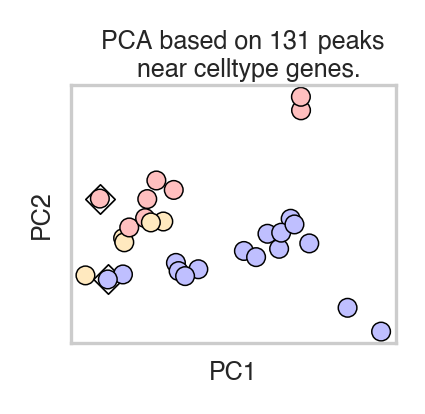

In [36]:
figsize = (36*mm, 35*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

X_ct = ATAC_data.to_df()[peaks_ct].copy()
# X = X[tall_peaks]
y = ATAC_data.obs.founder_pheno

pca = PCA(n_components=20)
X_ct_pca = pca.fit_transform(X_ct) # Apply PCA with 20 components.

cl_df = pd.DataFrame(X_ct_pca, columns = ['PC{}'.format(j) for j in range(1,21)], index=X_ct.index) # Just for graphing.
cl_df['Founder phenotype'] = y
cl_df['Clone'] = ATAC_data.obs['colorclone']
hue_order = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]
#hue_order = ['  ' + hue for hue in hue_order]
#display(cl_df)



sns.scatterplot(x='PC1', y ='PC2', color='white', data=cl_df[cl_df['Clone'].isin(['5a','5b'])],
               s=25, edgecolor='k', ax=ax, legend=False, marker='D')
sns.scatterplot(x='PC1', y='PC2', hue='Founder phenotype', hue_order=phenotypes, palette=phenopal_light,
                data = cl_df, s=20, edgecolor='k', ax=ax, legend=False)


#sns.scatterplot(x='PC1', y='PC2', hue='Clone', palette='Dark2', hue_order = hue_order,
#                data = cl_df[cl_df['Clone'] != 'Other'], s=2, edgecolor=None, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(axis='both', pad=-2)

#lgnd = ax.legend(loc='upper left', bbox_to_anchor=(1.01, 0.95), ncol=1, framealpha=0.0)

#change the marker size manually for both lines
#lgnd.legendHandles[0]._sizes = [20]
#for j in range(1,9):
#    lgnd.legendHandles[j]._sizes = [25]

plt.suptitle("PCA based on {} peaks \n near celltype genes.".format(len(X_ct.T)), 
            x=0.6, y=1.08)

set_size(fig, figsize)
plt.savefig("Panels/PC_Founderpheno_celltypee.pdf", bbox_inches='tight')

plt.show()

In [37]:
genes_clonal = adata.var[adata.var.F_pval < 0.0001].index
print(genes_clonal)

peaks_clonal = [peak for gene in genes_clonal for peak in adata.var.loc[gene, 'near_peaks']]
len(peaks_clonal) # peaks neaer celltype genes

Index(['MTATP6P1', 'ISG15', 'CAPZB', 'CD52', 'IFI6', 'ATPIF1', 'RP4-728D4.2',
       'TMSB4XP1', 'NRD1', 'SH3GLB1',
       ...
       'EGFL6', 'ASB9', 'PIR', 'PIM2-1', 'BRWD3', 'TCEAL1', 'PLS3-1',
       'LINC00892', 'CD40LG', 'VBP1-1'],
      dtype='object', name='gene_name', length=184)


575

In [38]:
print(', '.join(genes_clonal))

MTATP6P1, ISG15, CAPZB, CD52, IFI6, ATPIF1, RP4-728D4.2, TMSB4XP1, NRD1, SH3GLB1, REG4, ARNT, S100A4, RPS27, SLAMF1, FCGR3A, TADA1, XCL1, SELL, TSEN15, SRGN, DNAJC9, IFITM1, TALDO1, RCN1, FTH1, STIP1, NDUFS8, CLNS1A, CCDC90B, CTSC, LAYN, CADM1, FEZ1, GAPDH, KLRB1, KLRD1, KLRK1, KLRC1, STYK1, RP11-392P7.6, CSAD, GTSF1, MYL6, IFNG, RP11-81H14.2, RP11-81H14.4, ALOX5AP, NEK3, GZMH, GZMB, NFKBIA, FKBP3, RP11-349A22.5, FUT8, ACOT2, TMED10, RAD51, B2M, RAB27A, PPIB, CTSH, TM6SF1, PRSS21, IL32, TMEM186, CYB5B, TERF2IP, CENPN, GINS2, PFN1, ACADVL, CCL5, CCL4L1, CCL4L2, MLX, HOXB2, PSMC5, SYNGR2, ARL16, MYL12A, ABHD3, GADD45B, CD70, UBL5, EIF3G, HNRNPL, RPS19, RABAC1, PLAUR, ZC3H4, EMP3, FTL, PRMT1, NKG7, ZNF577, LAIR2, KIR2DL4, KIR2DL3, KIR2DS4, KIR3DL2, CTC-550B14.7, AC092580.4, ID2, LAPTM4A, TMSB10, GNLY, CD8B, CD8BP, STK17B, RQCD1, FKBP1A, SNORD17, TCEA2, GART, LGALS1, APOBEC3C, CXCR6, CCR3, CHDH, IL17RB, C3orf14, PSMD6, CLDND1, GPR15, PCNP, TFDP2, SKIL, DNAJC19, ETV5, APBB2, TXK, TMSB4XP8, 

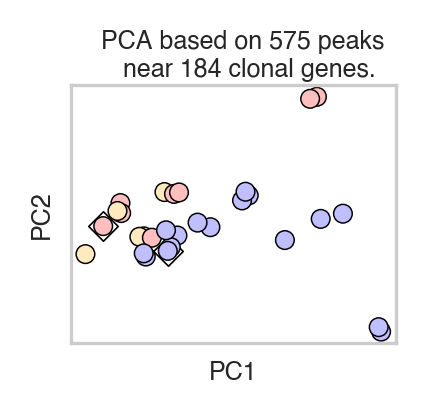

In [39]:
figsize = (36*mm, 35*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

X_cl = ATAC_data.to_df()[peaks_clonal].copy()
# X = X[tall_peaks]
y = ATAC_data.obs.founder_pheno

pca = PCA(n_components=20)
X_cl_pca = pca.fit_transform(X_cl) # Apply PCA with 20 components.

cl_df = pd.DataFrame(X_cl_pca, columns = ['PC{}'.format(j) for j in range(1,21)], index=X_cl.index) # Just for graphing.
cl_df['Founder phenotype'] = y
cl_df['Clone'] = ATAC_data.obs['colorclone']
hue_order = ['1', '15', '22', '23', '8', '9', '5a', '5b'] # ['Clone '+a for a in clr_list]
#hue_order = ['  ' + hue for hue in hue_order]
#display(cl_df)



sns.scatterplot(x='PC1', y ='PC2', color='white', data=cl_df[cl_df['Clone'].isin(['5a','5b'])],
               s=25, edgecolor='k', ax=ax, legend=False, marker='D')
sns.scatterplot(x='PC1', y='PC2', hue='Founder phenotype', hue_order=phenotypes, palette=phenopal_light,
                data = cl_df, s=20, edgecolor='k', ax=ax, legend=False)


#sns.scatterplot(x='PC1', y='PC2', hue='Clone', palette='Dark2', hue_order = hue_order,
#                data = cl_df[cl_df['Clone'] != 'Other'], s=2, edgecolor=None, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(axis='both', pad=-2)

#lgnd = ax.legend(loc='upper left', bbox_to_anchor=(1.01, 0.95), ncol=1, framealpha=0.0)

#change the marker size manually for both lines
#lgnd.legendHandles[0]._sizes = [20]
#for j in range(1,9):
#    lgnd.legendHandles[j]._sizes = [25]

plt.suptitle("PCA based on {} peaks \n near {} clonal genes.".format(len(X_cl.T), len(genes_clonal)), 
            x=0.6, y=1.08)

set_size(fig, figsize)
plt.savefig("Panels/PC_Founderpheno_clonal.pdf", bbox_inches='tight')

plt.show()

In [40]:
pca.explained_variance_ratio_.cumsum()

array([0.15264362, 0.2883844 , 0.38127187, 0.45421427, 0.5169443 ,
       0.57096416, 0.6158068 , 0.6577992 , 0.69638693, 0.73167074,
       0.7645682 , 0.7943714 , 0.82210624, 0.8482303 , 0.8686576 ,
       0.8883688 , 0.9073776 , 0.92242223, 0.9366124 , 0.9498295 ],
      dtype=float32)

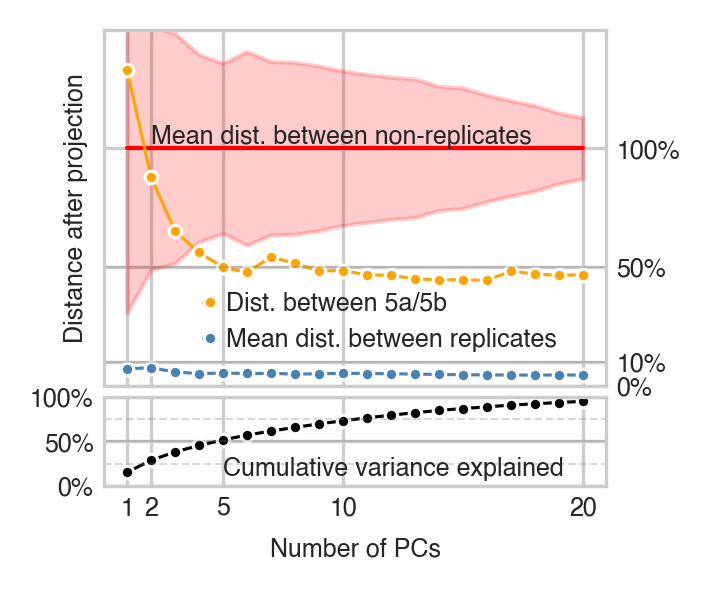

In [41]:
figsize=(60*mm,50*mm)
fig, ax = plt.subplots(2,1,figsize=figsize, dpi=300, sharex=True,
                      gridspec_kw={'height_ratios':[4,1], 'hspace':0.05})

sns.set_style('white')
setfontsize()

plot_df = dist_df.copy()
plot_df['Distance between replicates'] = plot_df['rep_dist_rel']
plot_df['Distance between 5a/5b'] = plot_df['sis_dist_rel']
plot_df['Number of PCs'] = plot_df['PCs']


plot_df['EVR'] = pca.explained_variance_ratio_.cumsum()

sns.lineplot(y='dist', x='n_comp', data=nonrep_dist_df, color='red', ci='sd', linewidth=1, ax=ax[0])


sns.lineplot(y = 'Distance between 5a/5b', x='Number of PCs', data=plot_df, 
             ci=None, estimator=None,
             marker='o', markersize=3, linewidth=0.75, color='orange', 
             ax=ax[0], label='Dist. between 5a/5b')

sns.lineplot(y = 'Distance between replicates', x='Number of PCs', data=plot_df, 
             ci=None, estimator=None,
             marker='o', markersize=3, linewidth=0.75, color='steelblue', 
             ax=ax[0], label='Mean dist. between replicates')

sns.lineplot(y='EVR', x='Number of PCs', data=plot_df, 
            ci=None, estimator=None,
            marker='o', markersize=3, linewidth=0.75, color='k',
            ax=ax[1])

#ax.axhline(1.0, label='Mean dist. between non-replicates', color='red', linewidth=1)
ax[0].legend(bbox_to_anchor=(0.55, 0.18), loc='center', frameon=False)
ax[0].set_ylabel('Distance after projection')
ax[1].set_ylabel('')
ax[1].text(5,0.12,'Cumulative variance explained')
ax[1].set_yticks([0,0.5,1.0])
ax[1].set_yticklabels(['0%','50%','100%'])
ax[0].set_xticks([1,2,5,10,20])
#ax[0].set_xlabel('Number of PCs')
#ax[1].set_xlabel('Principal components')
ax[0].set_yticks([0,0.1,0.5,1.0])
ax[0].set_yticklabels(['0%','10%','50%','100%'])
ax[0].set_ylim(0,1.5)
ax[0].tick_params(axis='both', pad=-1)
ax[1].tick_params(axis='both', pad=-1)
ax[0].tick_params(axis='y', labelright=True, labelleft=False)
ax[0].axhline(0.5, color='gray', alpha=0.3, linewidth=0.5)
ax[0].axhline(0.1, color='gray', alpha=0.3, linewidth=0.5)

ax[1].axhline(0.5, color='gray', alpha=0.3, linewidth=0.5)
ax[1].axhline(0.25, color='gray', alpha=0.3, linewidth=0.5, linestyle='--')
ax[1].axhline(0.75, color='gray', alpha=0.3, linewidth=0.5, linestyle='--')

ax[0].text(2,1.0,'Mean dist. between non-replicates', va='bottom')
set_size(fig, figsize)
plt.savefig("Panels/PC_dists.pdf", bbox_inches='tight')

plt.show()

# Founder phenotype peaks

In [42]:
ATAC_data.obs.founder_pheno.value_counts()

MEM    16
EFF     8
INT     5
Name: founder_pheno, dtype: int64

In [43]:
from scipy.stats import f_oneway

In [44]:
phenos = ATAC_data.obs.founder_pheno
groups = ['EFF','MEM']
me_cells = phenos[phenos.isin(groups)].index
phenos = phenos.loc[me_cells]
ATAC_me = ATAC_data[me_cells,:]
ATAC_df = ATAC_me.to_df()

In [45]:
pvals = pd.DataFrame(f_oneway(*[ATAC_df.loc[phenos == k] for k in groups])[1])
pvals.index = ATAC_data.var_names
pvals.columns = ['pvalue']
pvals['logp'] = -np.log10(pvals['pvalue'])
pvals['chr'] = ATAC_data.var['chr']
pvals['mid'] = ATAC_data.var['mid']
pvals['in_gene'] = ATAC_data.var['in_gene']
pvals.sort_values(by='pvalue') 

pvalue      logp chr          mid        in_gene
PeakID                                                                
Interval_56307  8.201988e-09  8.086081   4  140872073.5          MAML3
Interval_33405  8.050505e-08  7.094177  18   64933329.0            nan
Interval_31015  1.329343e-07  6.876363  17   61523867.5         CYB561
Interval_21644  3.458676e-07  6.461090  14   52753677.0  RP11-452D12.1
Interval_10688  6.567299e-07  6.182613  10  124304091.5            nan
...                      ...       ...  ..          ...            ...
Interval_55089  9.998267e-01  0.000075   4   88906888.5            nan
Interval_54897  9.998350e-01  0.000072   4   81103495.0  RP11-377G16.2
Interval_78159  9.998932e-01  0.000046   X    2556530.0         CD99P1
Interval_46488  9.999539e-01  0.000020  22   23528092.5            BCR
Interval_16651  9.999746e-01  0.000011  12   56554274.0           MYL6

[26040 rows x 5 columns]

In [46]:
genes_ct = 'GZMH, NKG7, FGFBP2, GZMB, GPR56, GNLY, SPON2, FCGR3A, S1PR5, ITGB2, FLNA-1, PRF1, FCRL6, ZNF683, EFHD2, CST7, AOAH, ITGAL, FGR, APMAP, CCL4, KLRD1, FAM211A-AS1, LDLRAP1, DGKA, RPL4, RPLP0, LDHB, NOSIP, SELL, IL7R, CCR7, TCF7, GZMK, LTB'.split(', ')
pvals_ct = pvals[pvals['in_gene'].isin(genes_ct)].sort_values('pvalue')

In [47]:
pvals.sort_values(by='pvalue').to_csv('peaks_memeff.csv')

In [48]:
pvals_ct[pvals_ct.pvalue < 1e-2].sort_values('pvalue')

pvalue      logp chr          mid in_gene
PeakID                                                     
Interval_4965   0.000292  3.535162   1  169677652.0    SELL
Interval_21241  0.000460  3.337215  14   25076577.0    GZMH
Interval_18355  0.001845  2.734098  12  120639226.0   RPLP0
Interval_53228  0.003165  2.499633   4    1171117.5   SPON2
Interval_60386  0.007916  2.101471   5  133450442.5    TCF7

In [49]:
pvals[pvals.pvalue < 1e-2].sort_values('pvalue')[:10]

pvalue      logp chr          mid        in_gene
PeakID                                                                
Interval_56307  8.201988e-09  8.086081   4  140872073.5          MAML3
Interval_33405  8.050505e-08  7.094177  18   64933329.0            nan
Interval_31015  1.329343e-07  6.876363  17   61523867.5         CYB561
Interval_21644  3.458676e-07  6.461090  14   52753677.0  RP11-452D12.1
Interval_10688  6.567299e-07  6.182613  10  124304091.5            nan
Interval_7272   1.228235e-06  5.910719   1  248645343.5            nan
Interval_43678  1.233119e-06  5.908995  20   13201891.5           ISM1
Interval_8941   1.516649e-06  5.819115  10   64616207.5           EGR2
Interval_33082  1.524295e-06  5.816931  18   48678328.5            nan
Interval_61654  1.548717e-06  5.810028   5  175080264.0            nan

In [50]:
tallpeaks = ATAC_data.var[ATAC_data.var.max_height > 100].index

me_peaks = pvals[pvals.pvalue < 1e-2].sort_values('pvalue').index
me_peaks = [peak for peak in me_peaks if peak in tallpeaks]

In [51]:
pvals.loc[me_peaks].sort_values('pvalue')[:30]

pvalue      logp chr          mid      in_gene
PeakID                                                              
Interval_56307  8.201988e-09  8.086081   4  140872073.5        MAML3
Interval_30868  4.008814e-06  5.396984  17   56595535.5        MTMR4
Interval_39143  4.420225e-06  5.354556   2   95688799.5          nan
Interval_39152  9.869808e-06  5.005691   2   95740401.5          nan
Interval_34952  1.463754e-05  4.834532  19   18315198.0  AC068499.10
Interval_24785  2.119588e-05  4.673748  15   67358280.5        SMAD3
Interval_48488  2.177423e-05  4.662057   3   27902882.5   AC098973.2
Interval_30617  2.387677e-05  4.622024  17   47841349.5      FAM117A
Interval_38447  3.478982e-05  4.458548   2   65283499.5        CEP68
Interval_34043  4.239240e-05  4.372712  19    4065577.5       ZBTB7A
Interval_35597  4.550034e-05  4.341985  19   41257024.5     C19orf54
Interval_77943  4.572145e-05  4.339880   9  139001911.0  RP11-83N9.5
Interval_77584  5.278502e-05  4.277489   9  131843366.5       DOLPP1
Interval_39144  5.546714e-05  4.255964   2   95691468.0          MAL
Interval_24257  5.659045e-05  4.247257  15   52263905.5         LEO1
Interval_60332  6.095454e-05  4.214994   5  131999387.5   AC004041.2
Interval_24292  6.345117e-05  4.197560  15   52821172.0        MYO5A
Interval_36209  7.195096e-05  4.142963  19   50145390.5        SCAF1
Interval_60333  7.562324e-05  4.121345   5  132010726.0          IL4
Interval_13140  7.666472e-05  4.115404  11   73587972.0        PAAF1
Interval_45111  9.668834e-05  4.014626  20   61371653.5        NTSR1
Interval_12737  1.073520e-04  3.969190  11   65337610.5       SSSCA1
Interval_36505  1.098292e-04  3.959282  19   55850819.5     SUV420H2
Interval_29922  1.184708e-04  3.926389  17   37026047.5        LASP1
Interval_20735  1.219985e-04  3.913646  13  103432221.5          nan
Interval_29167  1.254505e-04  3.901528  17   16439254.5          nan
Interval_26489  1.341810e-04  3.872309  16   15149812.0        NTAN1
Interval_34661  1.372365e-04  3.862530  19   14063143.5       DCAF15
Interval_10115  1.415790e-04  3.849001  10  103578210.0        MGEA5
Interval_12568  1.455942e-04  3.836856  11   62521572.5        ZBTB3

In [52]:
peaks_to_plot = ['Interval_60333','Interval_56307','Interval_30868','Interval_30617']

In [53]:
LEF1_peaks = ATAC_data.var[ATAC_data.var['in_gene'] == 'LEF1'].index
pvals.loc[LEF1_peaks]

pvalue      logp chr          mid in_gene
PeakID                                                     
Interval_55546  0.301527  0.520674   4  108971224.5    LEF1
Interval_55553  0.001505  2.822324   4  109088942.0    LEF1
Interval_55550  0.147765  0.830429   4  109037926.5    LEF1
Interval_55547  0.165560  0.781045   4  108993715.0    LEF1
Interval_55551  0.352309  0.453076   4  109040382.5    LEF1
Interval_55548  0.000991  3.003872   4  109029095.0    LEF1
Interval_55549  0.406200  0.391261   4  109034586.5    LEF1

In [54]:
ZEB2_peaks = ATAC_data.var[ATAC_data.var['in_gene'] == 'ZEB2'].index
pvals.loc[ZEB2_peaks]

pvalue      logp chr          mid in_gene
PeakID                                                     
Interval_40444  0.977265  0.009988   2  145232785.5    ZEB2
Interval_40450  0.356847  0.447519   2  145281704.0    ZEB2
Interval_40448  0.372988  0.428305   2  145274533.0    ZEB2
Interval_40449  0.436629  0.359888   2  145277691.0    ZEB2
Interval_40440  0.795323  0.099457   2  145210204.0    ZEB2
Interval_40447  0.757486  0.120626   2  145268321.5    ZEB2
Interval_40441  0.381848  0.418109   2  145212312.0    ZEB2
Interval_40438  0.059264  1.227212   2  145188666.5    ZEB2
Interval_40446  0.087177  1.059596   2  145263269.5    ZEB2
Interval_40445  0.327537  0.484739   2  145247872.5    ZEB2
Interval_40439  0.093667  1.028412   2  145206619.0    ZEB2
Interval_40442  0.506674  0.295271   2  145217439.5    ZEB2

In [55]:
phenorder = ['MEM','INT','EFF']

In [56]:
def me_plot(peak):
    sns.set_style('whitegrid')
    figsize=(40*mm,30*mm)
    fig,ax = plt.subplots(1,1,figsize=figsize,dpi=300)
    setfontsize()
    
    plot_df = pd.DataFrame(index=ATAC_data.obs_names)
    plot_df['Phenotype'] = ATAC_data.obs.founder_pheno
    plot_df['Clone'] = ATAC_data.obs.colorclone
    plot_df['Height'] = np.exp(ATAC_data.to_df()[peak]) - 1

    sns.violinplot(x='Phenotype', y='Height', data = plot_df, inner=None, 
                   order=phenorder, palette=phenopal_light, cut=0, ax=ax,
                  linewidth=0.5, scale='width')
    
    sns.swarmplot(x='Phenotype', y='Height', data=plot_df[plot_df['Clone'] == 'Other'], 
                  order=phenorder, s=3, ax=ax, color='white',linewidth=0.5, edgecolor='k')
    
    sns.swarmplot(x='Phenotype', y='Height', hue='Clone', hue_order = hue_order, palette='Dark2',
                  data=plot_df[plot_df['Clone'] != 'Other'], 
                  order=phenorder, s=3, ax=ax, linewidth=0.5, edgecolor='k')
    ax.legend().set_visible(False)
    ax.tick_params(axis='both', pad=-1)
    peakno = peak.split('_')[1]
    gene = ATAC_data.var.loc[peak,'in_gene']
    plt.suptitle('Interval {} in {}'.format(peakno, gene), x=0.57, y=1.02)
    set_size(fig, figsize)
    plt.savefig("Panels/ME_plots/ME_plot_{}.pdf".format(peakno), bbox_inches='tight')
    plt.show()

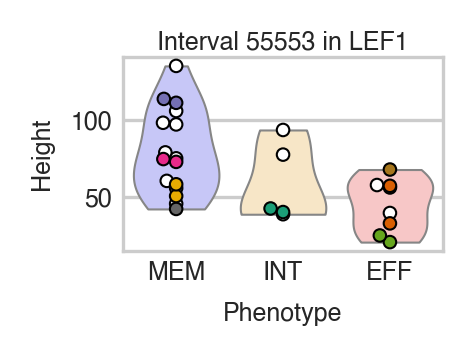

In [57]:
me_plot('Interval_55553')

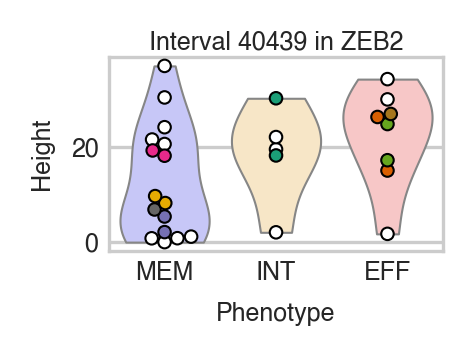

In [58]:
me_plot('Interval_40439')

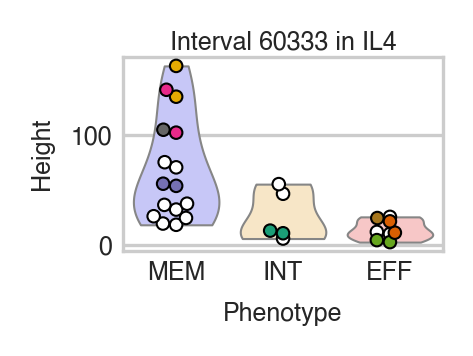

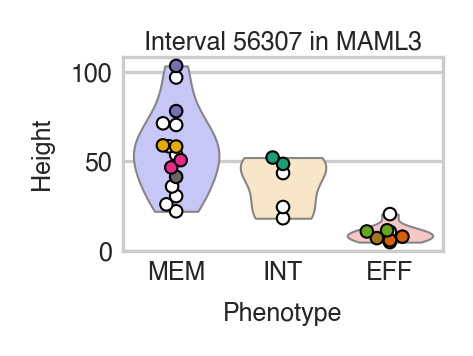

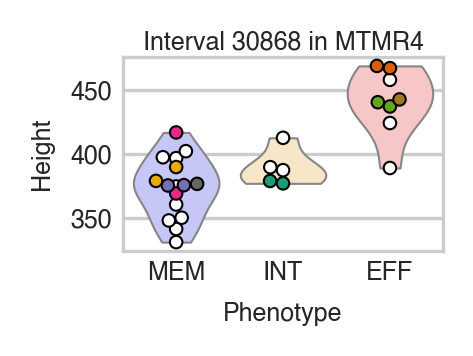

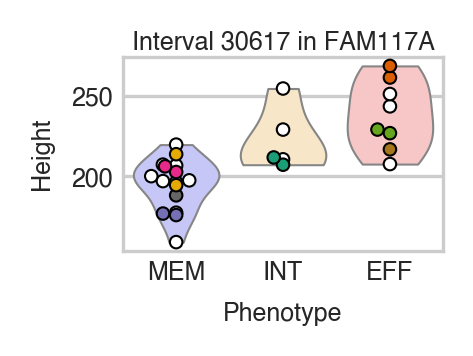

In [59]:
for peak in peaks_to_plot:
    me_plot(peak)

In [60]:
def make_shuff(meta, no_shuffs=10, topratio = 10):
    tot_shuffs = no_shuffs * topratio
    ms_df = pd.DataFrame(index=meta.index, columns=range(tot_shuffs))
    ms_df = pd.concat([meta.astype(str) for j in range(tot_shuffs)], axis=1)
    
    ms_vals = ms_df.values
    [np.random.shuffle(x) for x in ms_vals.T]
    
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(tot_shuffs)]
    scores = ms_df.groupby(meta).nunique().sum()
    good_shuffs = scores.sort_values()[-no_shuffs:].index
    ms_df = ms_df[good_shuffs].astype('category')
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(no_shuffs)]
    return ms_df

In [61]:
pheno_df = pd.DataFrame(ATAC_me.obs.founder_pheno).copy()
pheno_df = pd.concat([pheno_df, make_shuff(pheno_df.founder_pheno, no_shuffs=1000, topratio=10)], axis=1)
pheno_df

founder_pheno Shuffle_0 Shuffle_1 Shuffle_2 Shuffle_3 Shuffle_4  \
Sample_name                                                                   
P9855_2097            MEM       MEM       MEM       EFF       MEM       MEM   
P9855_2099            MEM       MEM       EFF       MEM       EFF       MEM   
P9855_2100            EFF       EFF       MEM       EFF       EFF       MEM   
P9855_2101            EFF       EFF       EFF       MEM       MEM       EFF   
P9855_2102            EFF       MEM       MEM       EFF       EFF       MEM   
P9855_2103            EFF       EFF       MEM       MEM       MEM       MEM   
P9855_2106            EFF       MEM       MEM       MEM       MEM       MEM   
P9855_2105            MEM       MEM       MEM       MEM       MEM       MEM   
P9855_2086            MEM       MEM       EFF       MEM       MEM       MEM   
P9855_2108            MEM       MEM       MEM       MEM       MEM       EFF   
P9855_2109            MEM       MEM       MEM       MEM       EFF       EFF   
P9855_2110            MEM       MEM       EFF       MEM       EFF       EFF   
P9855_2111            MEM       MEM       MEM       MEM       MEM       EFF   
P9855_2104            MEM       MEM       MEM       MEM       MEM       MEM   
P9855_2112            MEM       MEM       MEM       EFF       MEM       EFF   
P9855_2113            MEM       EFF       MEM       EFF       EFF       MEM   
P9855_2087            MEM       MEM       MEM       MEM       EFF       EFF   
P9855_2098            EFF       EFF       MEM       EFF       MEM       MEM   
P9855_2095            MEM       MEM       EFF       MEM       EFF       MEM   
P9855_2088            MEM       EFF       MEM       MEM       MEM       EFF   
P9855_2089            EFF       MEM       EFF       MEM       MEM       MEM   
P9855_2090            EFF       EFF       MEM       EFF       MEM       MEM   
P9855_2091            MEM       MEM       EFF       EFF       MEM       MEM   
P9855_2096            MEM       EFF       EFF       MEM       MEM       MEM   

            Shuffle_5 Shuffle_6 Shuffle_7 Shuffle_8  ... Shuffle_990  \
Sample_name                                          ...               
P9855_2097        MEM       MEM       MEM       EFF  ...         EFF   
P9855_2099        MEM       MEM       MEM       MEM  ...         EFF   
P9855_2100        MEM       EFF       MEM       MEM  ...         EFF   
P9855_2101        MEM       MEM       MEM       EFF  ...         MEM   
P9855_2102        EFF       EFF       EFF       MEM  ...         MEM   
P9855_2103        MEM       MEM       MEM       MEM  ...         MEM   
P9855_2106        MEM       EFF       EFF       MEM  ...         EFF   
P9855_2105        MEM       MEM       MEM       MEM  ...         MEM   
P9855_2086        MEM       MEM       MEM       EFF  ...         MEM   
P9855_2108        MEM       MEM       MEM       MEM  ...         MEM   
P9855_2109        EFF       MEM       MEM       EFF  ...         MEM   
P9855_2110        EFF       MEM       EFF       MEM  ...         MEM   
P9855_2111        EFF       MEM       MEM       MEM  ...         MEM   
P9855_2104        MEM       MEM       MEM       EFF  ...         EFF   
P9855_2112        EFF       MEM       MEM       MEM  ...         EFF   
P9855_2113        MEM       MEM       MEM       MEM  ...         MEM   
P9855_2087        MEM       EFF       MEM       MEM  ...         MEM   
P9855_2098        EFF       EFF       EFF       MEM  ...         MEM   
P9855_2095        EFF       MEM       EFF       MEM  ...         MEM   
P9855_2088        MEM       MEM       EFF       EFF  ...         MEM   
P9855_2089        EFF       EFF       EFF       EFF  ...         EFF   
P9855_2090        MEM       EFF       MEM       MEM  ...         MEM   
P9855_2091        MEM       EFF       EFF       MEM  ...         MEM   
P9855_2096        MEM       MEM       MEM       EFF  ...         EFF   

            Shuffle_991 Shuffle_992 Shuffle_993 Shuffle_994 Shuffle_995  \
Sample_na

In [62]:
from time import time
from scipy.stats import f_oneway

def make_pvals(ad, real_group, shuffle_label = 'Shuffle', no_shuffs=100):
    '''
    Expects an AnnData object ad.
    real_group is usually "cloneID", or the equivalent.
    Also expects a lot of shuffled real_group labels, called
    Shuffle_0, Shuffle_1, up to Shuffle_n, where n = no_shuffs.
    real_group and shuffles should be within the ad.obs dataframe.
    Computes p-values by applying scipy's f_oneway to each column of shuffled labels.
    Vectorized for all genes at once.
    '''
    before = time()    
    cols = [real_group] + [shuffle_label + '_' + str(j) for j in range(no_shuffs)]
    pval_df = pd.DataFrame(columns=cols)

    groups = ad.obs[real_group].unique()
    ad_df = ad.to_df()
    pval_df = ad.obs[cols].apply(lambda col : f_oneway(*[ad_df[col == k] for k in groups])[1])
    pval_df.index = ad.var_names
    after = time()
    print('{:1.0f} seconds to compute ANOVA F p-values for {} samples and {} groups.'.format(after - before,
                                                                                          ad.shape[0], len(groups)))
    return pval_df

In [63]:
ad_pheno = ATAC_me.copy()
ad_pheno.obs = pheno_df

In [64]:
pvals_df = make_pvals(ad_pheno, 'founder_pheno', no_shuffs=1000)

32 seconds to compute ANOVA F p-values for 24 samples and 2 groups.


In [65]:
pvals_df

founder_pheno  Shuffle_0  Shuffle_1  Shuffle_2  Shuffle_3  \
PeakID                                                                      
Interval_51938       0.152067   0.476684   0.417109   0.650234   0.380741   
Interval_13433       0.422780   0.146351   0.577585   0.786676   0.092441   
Interval_27763       0.013142   0.840968   0.700633   0.674043   0.108460   
Interval_53540       0.905193   0.818711   0.786740   0.160221   0.579297   
Interval_4280        0.005378   0.432155   0.628639   0.412328   0.188890   
...                       ...        ...        ...        ...        ...   
Interval_76540       0.859921   0.472330   0.218779   0.274350   0.266597   
Interval_57434       0.918619   0.748448   0.771477   0.343760   0.480528   
Interval_28417       0.454594   0.588572   0.921144   0.175989   0.002718   
Interval_45676       0.532038   0.284031   0.851859   0.296585   0.428642   
Interval_8387        0.310205   0.645937   0.195374   0.254801   0.233691   

                Shuffle_4  Shuffle_5  Shuffle_6  Shuffle_7  Shuffle_8  ...  \
PeakID                                                                 ...   
Interval_51938   0.248207   0.378973   0.501242   0.274855   0.977046  ...   
Interval_13433   0.585743   0.220636   0.644371   0.481049   0.331581  ...   
Interval_27763   0.201753   0.556809   0.045177   0.600603   0.479338  ...   
Interval_53540   0.911205   0.598760   0.952379   0.694793   0.960975  ...   
Interval_4280    0.481373   0.717244   0.020046   0.037126   0.889680  ...   
...                   ...        ...        ...        ...        ...  ...   
Interval_76540   0.790051   0.978676   0.239468   0.786106   0.947021  ...   
Interval_57434   0.642662   0.257705   0.050358   0.937981   0.379927  ...   
Interval_28417   0.745325   0.640684   0.483817   0.607906   0.364430  ...   
Interval_45676   0.031483   0.725927   0.768839   0.812286   0.594598  ...   
Interval_8387    0.218359   0.244981   0.762191   0.417576   0.987544  ...   

                Shuffle_990  Shuffle_991  Shuffle_992  Shuffle_993  \
PeakID                                                               
Interval_51938     0.226937     0.999314     0.278448     0.729077   
Interval_13433     0.033080     0.819192     0.819568     0.775303   
Interval_27763     0.397145     0.489261     0.641405     0.134021   
Interval_53540     0.424597     0.617630     0.090403     0.157515   
Interval_4280      0.370938     0.895827     0.368660     0.726196   
...                     ...          ...          ...          ...   
Interval_76540     0.342908     0.944286     0.998176     0.516268   
Interval_57434     0.059851     0.425981     0.987856     0.169208   
Interval_28417     0.577014     0.136825     0.819799     0.686445   
Interval_45676     0.528157     0.716167     0.079682     0.802305   
Interval_8387      0.340673     0.253687     0.466795     0.370074   

                Shuffle_994  Shuffle_995  Shuffle_996  Shuffle_997  \
PeakID                                                               
Interval_51938     0.058550     0.653523     0.966709     0.653982   
Interval_13433     0.938765     0.493533     0.902199     0.263940   
Interval_27763     0.725098     0.419428     0.079362     0.731526   
Interval_53540     0.916369     0.850827     0.425281     0.483787   
Interval_4280      0.293835     0.668231     0.282258     0.318949   
...                     ...          ...          ...          ...   
Interval_76540     0.057504     0.440537     0.555698     0.449339   
Interval_57434     0.684253     0.265803     0.277477     0.276109   
Interval_28417     0.705872     0.663946     0.498027     0.038626   
Interval_45676     0.548407     0.540261     0.620466     0.874832   
Interval_8387      0.364502     0.355016     0.008078     0.433659   

                Shuffle_998  Shuffle_999  
PeakID                                    
Interval_51938     0.478816     0.627847  
Interval_13433     0.273121     0.786109  
Inter

In [66]:
(pvals_df < 0.0005).sum().quantile(0.5) # Median false discoveries.

7.0

In [67]:
fp_peaks = pvals_df[pvals_df.founder_pheno < 0.0005].index
len(fp_peaks)

249

In [68]:
fp_nears = ATAC_data.var.loc[fp_peaks].near_genes.apply(lambda x : len(x))
f_peaks = fp_nears[fp_nears > 0].index
len(f_peaks)

122

In [69]:
8 * 122 / 249

3.9196787148594376

In [70]:
ATAC_data.obs.founder_pheno.value_counts()

MEM    16
EFF     8
INT     5
Name: founder_pheno, dtype: int64

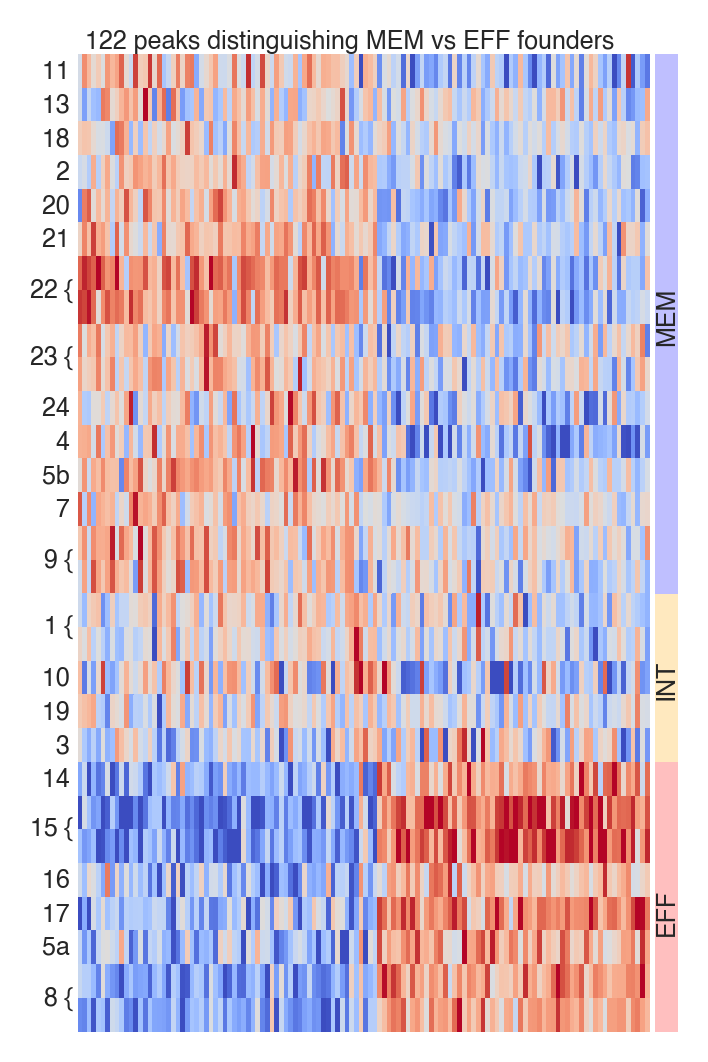

In [71]:
figsize=(60*mm, 90*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)

samples = [samp for ph in phenotypes for samp in ATAC_data.obs[ATAC_data.obs.founder_pheno == ph].index]
AT_df = ATAC_data.to_df()[f_peaks].copy()


groupmaxs = AT_df.groupby(ATAC_data.obs.founder_pheno).mean().idxmax()
marker_peaks = [peak for ph in phenotypes for peak in groupmaxs[groupmaxs == ph].index]

AT_z = AT_df.loc[samples, marker_peaks]
AT_z = (AT_z - AT_z.mean()) / AT_z.std()

me_index = AT_z.index.map(ATAC_data.obs.founder_pheno)

AT_z.index = AT_z.index.map(ATAC_data.obs.loc[samples,'ATAC_clone'])

sns.heatmap(AT_z, cmap='coolwarm', vmin=-2, vmax=2, cbar=None, ax=ax)

for y,clone in [(17,1), (23,15), (7,22), (9,23), (28,8), (15,9)]:
    ax.text(-1,y,str(clone) + ' {', va='center', ha='right', fontsize=6)
    
for j,clone in enumerate(AT_z.index):
    par = clone.split('_')[0]
    if par not in ['1','15','22','23','8','9']: #,'5a','5b']:
        ax.text(-0.1,j+0.5,par + ' ', va='center', ha='right', fontsize=6)

for j in range(len(me_index)):
    me_color = phenopal_light[me_index[j]]
    rect_x = len(marker_peaks)
    rect = Rectangle((rect_x+1, j), 5, 1, linewidth=0, edgecolor=None,
                     facecolor=me_color, fill=True, alpha=1.0, clip_on=False)
    ax.add_patch(rect)
    #ax.text(1,j+0.5,me_index[j], va='center')
#ax.tick_params(axis='both', pad=10)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticks([])

ax.text(rect_x + 1, 8.5, 'MEM', rotation=90)
ax.text(rect_x + 1, 19, 'INT', rotation=90)
ax.text(rect_x + 1, 26, 'EFF', rotation=90)

plt.suptitle('{} peaks distinguishing MEM vs EFF founders'.format(len(marker_peaks)), x=0.55, y=0.93)

#ax2=plt.twinx()
#ax2.set_yticks([1,2,3])
set_size(fig, figsize)
plt.savefig("Panels/ME_plots/ME_heatmap.pdf", bbox_inches='tight')
plt.show()
plt.show()

In [72]:
ATAC_data.var.loc[fp_peaks].to_csv('founder_pheno_peaks.csv')

In [73]:
ATAC_data.var.loc[fp_peaks].in_gene.unique()

array(['PDE7B', 'ASCL5', 'PITRM1', 'MPRIP', 'SMAD3', 'PARK7', 'FTO',
       'DAAM1', 'AC002451.3', 'RP11-355N15.1', 'CACNA1D', 'LGALS1', 'nan',
       'KHSRP', 'NMT1', 'MAP2K1', 'LINC00893', 'SAMD4A', 'AC004237.1',
       'CD44', 'CHODL', 'KCNA6', 'NRP1', 'DSEL', 'POU2F2', 'SNAPIN',
       'XXYLT1-AS2', 'RP11-83N9.5', 'PSEN2', 'LINC00924', 'CDCP1', 'E2F3',
       'TSGA10', 'SLC9A9', 'ZBTB3', 'ZFPM1', 'CTD-2503O16.4', 'POLR1A',
       'C19orf54', 'AC093627.9', 'Y_RNA-396', 'CTD-2058B24.2', 'SFMBT2',
       'ADK', 'CSF2', 'RGS18', 'RORA', 'DNAJB1', 'ATXN1', 'MAMLD1-1',
       'ERAP2', 'IL17RB', 'AC098973.2', 'RP11-438H8.8', 'EEF1A2', 'USP35',
       'RP11-543F8.2', 'WIPF1', 'PLXNC1', 'STARD9', 'RCN1', 'ARHGEF7',
       'GABARAP', 'RNF44', 'KDM4B', 'C11orf58', 'HOMER2', 'EGR2',
       'PLA2G6', 'WHSC1', 'ARHGAP10', 'MAL', 'AC004041.2', 'MIR3191',
       'CD59', 'CNGA1', 'NTAN1', 'LEO1', 'TIAM2', 'MGEA5', 'BICD2',
       'ADRB2', 'MCOLN2', 'SLC11A1', 'ELOVL6', 'INPP4A', 'HINT2', 'TXK',
   

In [74]:
excess = (pvals_df < 0.01).sum()['founder_pheno'] - (pvals_df < 0.01).sum()[1:].quantile(0.95)
excess

1006.0

# New analysis of peak variability

The first thing we do is look at foldchanges in heights within each replicate pair.  If these are too big, i.e., the peak height varies too much within replicate pairs, we exclude the peak from later analysis.  "Too big" means "Above the 98th percentile among peaks with similar maximum heights."

This data contains 12 samples, with 2 bulks from each clone.  These 2 bulks are considered replicates (R1 and R2).

In [75]:
parents = ATACR_data.obs.ATAC_parent.unique()
parents

array(['1', '15', '22', '23', '8', '9'], dtype=object)

In [76]:
ATAC_data.var['max_height'] = np.exp(ATAC_data.to_df().max()) - 1
ATAC_data.var['replicate_foldchange'] = np.exp(2 * ATACR_data.to_df().groupby(ATACR_data.obs.ATAC_parent).agg(np.std, ddof=0)).max()
ATAC_data.var

PeakID chr        end          in_ensg    in_gene  \
PeakID                                                                      
Interval_51938  Interval_51938   3  156852899             None        nan   
Interval_13433  Interval_13433  11   82997741  ENSG00000137500    CCDC90B   
Interval_27763  Interval_27763  16   68564473  ENSG00000184939      ZFP90   
Interval_53540  Interval_53540   4    7967411  ENSG00000163995     ABLIM2   
Interval_4280    Interval_4280   1  153644524  ENSG00000143621       ILF2   
...                        ...  ..        ...              ...        ...   
Interval_76540  Interval_76540   9   95394458  ENSG00000127080       IPPK   
Interval_57434  Interval_57434   4  186347634  ENSG00000205129    C4orf47   
Interval_28417  Interval_28417  16   88730354  ENSG00000167508        MVD   
Interval_45676  Interval_45676  21   35310937  ENSG00000237945  LINC00649   
Interval_8387    Interval_8387  10   33624658  ENSG00000099250       NRP1   

                       itype  max_height          mid      start  \
PeakID                                                             
Interval_51938      Intergen   30.484528  156852750.0  156852601   
Interval_13433  promoter-TSS  301.374023   82997180.5   82996620   
Interval_27763  promoter-TSS   55.443855   68564084.5   68563696   
Interval_53540           TTS   51.684940    7966923.5    7966436   
Interval_4280   promoter-TSS  189.036224  153643788.5  153643053   
...                      ...         ...          ...        ...   
Interval_76540        intron   35.414661   95394099.5   95393741   
Interval_57434  promoter-TSS  201.101410  186347041.5  186346449   
Interval_28417  promoter-TSS  136.937500   88729670.5   88728987   
Interval_45676          exon   34.971249   35310572.5   35310208   
Interval_8387   promoter-TSS  118.396477   33623619.5   33622581   

                               near_genes  replicate_foldchange  
PeakID                                                           
Interval_51938                         []              2.687325  
Interval_13433                  [CCDC90B]              1.248479  
Interval_27763                    [ZFP90]              1.375773  
Interval_53540                         []              3.022383  
Interval_4280                      [ILF2]              1.314471  
...                                   ...                   ...  
Interval_76540                         []              4.861817  
Interval_57434                    [UFSP2]              1.166461  
Interval_28417  [CYBA, MVD, CTU2, PIEZO1]              1.274999  
Interval_45676         [ATP5O, LINC00649]              3.212020  
Interval_8387                      [NRP1]              1.634522  

[26040 rows x 11 columns]

Now we assess the variability of general peaks.  We consider peaks variable if their spread (maximum - minimum) exceeds all spreads of replicate pairs of similar minimum.  

In [77]:
A_df = ATAC_data.to_df()
A_df_raw = np.exp(A_df) - 1 #Removed Pseudo-log normalization.

AR_df = ATACR_data.to_df()  # Replicates only.
AR_df_raw = np.exp(AR_df) - 1

nonreps = [samp for samp in A_df.index if samp not in AR_df.index]
ANR_df = A_df.loc[nonreps] # Non-replicates only.
ANR_df_raw = A_df_raw.loc[nonreps]
ANR_df

PeakID       Interval_51938  Interval_13433  Interval_27763  Interval_53540  \
Sample_name                                                                   
P9855_2092         2.287843        5.560565        3.709698        3.762476   
P9855_2097         1.853198        5.436592        3.504991        3.114438   
P9855_2099         2.070839        5.550882        3.751593        3.182416   
P9855_2100         1.499256        5.567874        3.670255        0.000000   
P9855_2103         0.000000        5.558466        4.033247        3.964330   
P9855_2106         1.439738        5.445604        3.782548        3.326111   
P9855_2105         2.734340        5.545929        3.732867        2.624641   
P9855_2107         2.775430        5.629741        3.436920        2.986031   
P9855_2086         1.972389        5.437860        3.517708        2.451669   
P9855_2108         2.128885        5.444118        3.869145        2.991982   
P9855_2109         2.142275        5.506553        3.272452        2.885766   
P9855_2113         2.009289        5.711665        2.902595        2.009289   
P9855_2094         2.426444        5.683740        3.585825        3.326052   
P9855_2087         3.449496        5.493403        3.700081        3.607240   
P9855_2098         2.591159        5.644123        3.638525        3.083403   
P9855_2095         2.937437        5.609965        3.565594        2.779974   
P9855_2088         2.824024        5.619921        3.443976        3.507894   

PeakID       Interval_4280  Interval_6501  Interval_68580  Interval_72287  \
Sample_name                                                                 
P9855_2092        5.194549       4.519068        5.543390        5.414121   
P9855_2097        5.243369       4.985421        5.780162        5.169667   
P9855_2099        4.955405       4.738075        5.546385        5.314034   
P9855_2100        5.240854       4.515653        5.513281        5.240854   
P9855_2103        5.195662       4.471122        5.540189        5.331752   
P9855_2106        5.217739       4.788531        5.638725        5.398186   
P9855_2105        5.105916       4.442622        5.510977        5.307248   
P9855_2107        5.123996       4.585413        5.571364        5.132912   
P9855_2086        5.108484       4.493093        5.533124        5.205187   
P9855_2108        5.031900       4.856232        5.418911        5.213133   
P9855_2109        4.928832       4.404608        5.451651        5.266151   
P9855_2113        4.852090       4.561402        5.443871        5.049807   
P9855_2094        5.100070       4.740612        5.524294        5.149168   
P9855_2087        5.154146       4.445949        5.408775        5.033196   
P9855_2098        5.247215       4.287120        5.610814        5.226705   
P9855_2095        5.127997       4.283169        5.553022        5.346686   
P9855_2088        5.158548       4.699069        5.427788        5.309041   

PeakID       Interval_7590  Interval_38287  ...  Interval_78898  \
Sample_name                                 ...                   
P9855_2092        5.077458        4.879703  ...        2.658895   
P9855_2097        4.403090        4.662625  ...        1.853198   
P9855_2099        4.879333        4.796993  ...        0.000000   
P9855_2100        4.515653        4.810088  ...        1.827373   
P9855_2103        4.523455        4.843583  ...        1.892865   
P9855_2106        4.770501        4.634279  ...        1.439738   
P9855_2105        4.506425        4.808897  ...        1.887044   
P9855_2107        4.754437        4.841271  ...        2.907030   
P9855_2086        4.681770        4.768009  ...        1.972389   
P9855_2108        4.755282        4.823701  ...        2.650796   
P9855_2109        4.955668        4.836282  ...        2.341661   
P9855_2113        4.515379        4.800323  ...        2.009289   
P9855_2094        4.758474        4.859426  ...        2.862755   
P9855_2087        3.900287   

In [78]:
A_mins = A_df_raw.min()
A_maxs = A_df_raw.max()

ANR_mins = ANR_df_raw.min()
ANR_maxs = ANR_df_raw.max()

AR_mins = AR_df_raw.groupby(ATACR_data.obs.ATAC_parent).min() 
AR_maxs = AR_df_raw.groupby(ATACR_data.obs.ATAC_parent).max()

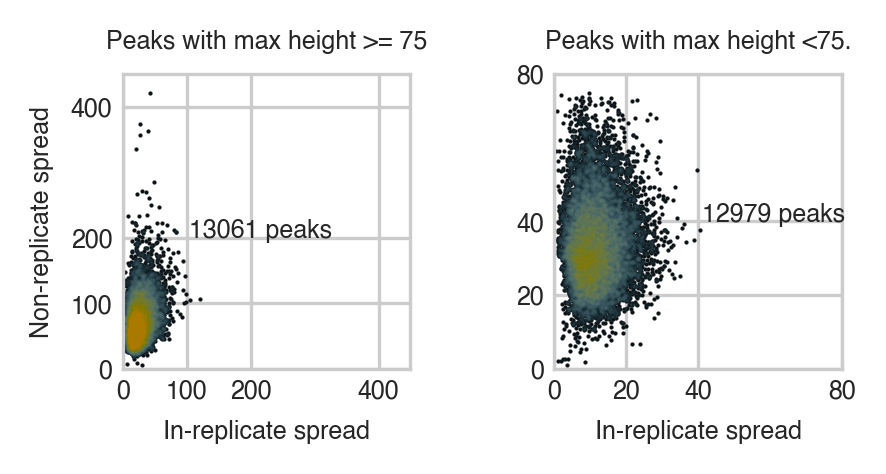

In [79]:

plot_df.head()
figsize=(75*mm, 40*mm)
fig,ax = plt.subplots(1,2,figsize=figsize, dpi=300,
                     gridspec_kw={'wspace':0.5})

sns.set_style('whitegrid')
setfontsize()

plot_df = pd.DataFrame(index = A_maxs[A_maxs >= 75].index)
plot_df['In-replicate spread'] = (AR_maxs - AR_mins).max()
plot_df['Non-replicate spread'] = (ANR_maxs - ANR_mins)
sns.scatterplot(x='In-replicate spread', y='Non-replicate spread', data=plot_df, 
                edgecolor=None, color='k', s=0.8, ax=ax[0], alpha=1)

sns.scatterplot(x='In-replicate spread', y='Non-replicate spread', data=plot_df, 
                edgecolor=None, color='steelblue', s=1, ax=ax[0], alpha=0.1)

sns.scatterplot(x='In-replicate spread', y='Non-replicate spread', data=plot_df, 
                edgecolor=None, color='orange', s=1, ax=ax[0], alpha=0.01)

ax[0].set_title('Peaks with max height >= 75')
ax[0].set_xlim(0,450)
ax[0].set_ylim(0,450)
ax[0].set_xticks([0,100,200,400])
ax[0].set_yticks([0,100,200,400])
ax[0].tick_params(axis='both',pad=-1)
ax[0].text(104,200,'{} peaks'.format(len(plot_df)))

plot_df = pd.DataFrame(index = A_maxs[A_maxs < 75].index)

plot_df['In-replicate spread'] = (AR_maxs - AR_mins).max()
plot_df['Non-replicate spread'] = (ANR_maxs - ANR_mins)
sns.scatterplot(x='In-replicate spread', y='Non-replicate spread', data=plot_df, 
                edgecolor=None, color='k', s=0.8, ax=ax[1], alpha=1)

sns.scatterplot(x='In-replicate spread', y='Non-replicate spread', data=plot_df, 
                edgecolor=None, color='steelblue', s=1, ax=ax[1], alpha=0.1)

sns.scatterplot(x='In-replicate spread', y='Non-replicate spread', data=plot_df, 
                edgecolor=None, color='orange', s=1, ax=ax[1], alpha=0.01)

ax[1].set_title('Peaks with max height <75.')
ax[1].set_xlim(0,80)
ax[1].set_ylim(0,80)
ax[1].set_ylabel('')
ax[1].tick_params(axis='both',pad=-1)
ax[1].set_xticks([0,20,40,80])
ax[1].set_yticks([0,20,40,80])
ax[1].text(41,40,'{} peaks'.format(len(plot_df)))

set_size(fig, figsize)
plt.savefig("Panels/Spread_v_spread.pdf", bbox_inches='tight')
plt.show()

# Relative peak variability

In [80]:
ATAC_data.var['replicate_spread'] = (AR_maxs - AR_mins).max()
ATAC_data.var

PeakID chr        end          in_ensg    in_gene  \
PeakID                                                                      
Interval_51938  Interval_51938   3  156852899             None        nan   
Interval_13433  Interval_13433  11   82997741  ENSG00000137500    CCDC90B   
Interval_27763  Interval_27763  16   68564473  ENSG00000184939      ZFP90   
Interval_53540  Interval_53540   4    7967411  ENSG00000163995     ABLIM2   
Interval_4280    Interval_4280   1  153644524  ENSG00000143621       ILF2   
...                        ...  ..        ...              ...        ...   
Interval_76540  Interval_76540   9   95394458  ENSG00000127080       IPPK   
Interval_57434  Interval_57434   4  186347634  ENSG00000205129    C4orf47   
Interval_28417  Interval_28417  16   88730354  ENSG00000167508        MVD   
Interval_45676  Interval_45676  21   35310937  ENSG00000237945  LINC00649   
Interval_8387    Interval_8387  10   33624658  ENSG00000099250       NRP1   

                       itype  max_height          mid      start  \
PeakID                                                             
Interval_51938      Intergen   30.484528  156852750.0  156852601   
Interval_13433  promoter-TSS  301.374023   82997180.5   82996620   
Interval_27763  promoter-TSS   55.443855   68564084.5   68563696   
Interval_53540           TTS   51.684940    7966923.5    7966436   
Interval_4280   promoter-TSS  189.036224  153643788.5  153643053   
...                      ...         ...          ...        ...   
Interval_76540        intron   35.414661   95394099.5   95393741   
Interval_57434  promoter-TSS  201.101410  186347041.5  186346449   
Interval_28417  promoter-TSS  136.937500   88729670.5   88728987   
Interval_45676          exon   34.971249   35310572.5   35310208   
Interval_8387   promoter-TSS  118.396477   33623619.5   33622581   

                               near_genes  replicate_foldchange  \
PeakID                                                            
Interval_51938                         []              2.687325   
Interval_13433                  [CCDC90B]              1.248479   
Interval_27763                    [ZFP90]              1.375773   
Interval_53540                         []              3.022383   
Interval_4280                      [ILF2]              1.314471   
...                                   ...                   ...   
Interval_76540                         []              4.861817   
Interval_57434                    [UFSP2]              1.166461   
Interval_28417  [CYBA, MVD, CTU2, PIEZO1]              1.274999   
Interval_45676         [ATP5O, LINC00649]              3.212020   
Interval_8387                      [NRP1]              1.634522   

                replicate_spread  
PeakID                            
Interval_51938         11.172881  
Interval_13433         56.279495  
Interval_27763         14.676781  
Interval_53540          6.080252  
Interval_4280          36.200294  
...                          ...  
Interval_76540          7.766854  
Interval_57434         21.593552  
Interval_28417         29.751160  
Interval_45676          6.876513  
Interval_8387          22.711807  

[26040 rows x 12 columns]

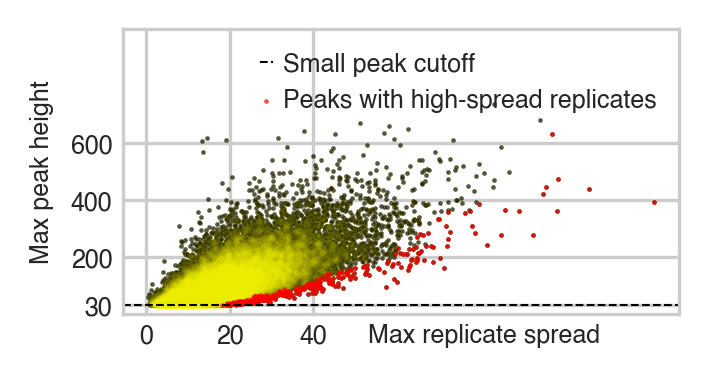

In [81]:
plot_df = ATAC_data.var[['replicate_spread','max_height']].copy()
figsize = (60*mm, 32*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()


#fc_line = pd.DataFrame(columns=['fc','ph'])
#fc_line['fc'] = np.linspace(1.2,6,50)
#fc_line['ph'] = -80 + 100 / (np.log(fc_line['fc']))
#sns.lineplot(x='fc',y='ph', data=fc_line, color='green', linewidth=0.7)

bigspread = plot_df.sort_values(by='max_height').rolling(500).quantile(0.99)['replicate_spread']
plot_df['outlier'] = (plot_df.sort_values(by='max_height')['replicate_spread'] > bigspread)

sns.scatterplot(x='replicate_spread', y='max_height', data=plot_df, s=1.0, color='k', edgecolor=None, alpha=0.7)
sns.scatterplot(x='replicate_spread', y='max_height', data=plot_df, s=2.0, color='yellow', edgecolor=None, alpha=0.05)
sns.scatterplot(x='replicate_spread', y='max_height', data=plot_df[plot_df['outlier']], 
                color='red', s=1.0, edgecolor=None, alpha=0.7, label='Peaks with high-spread replicates')

#ax.axhline(15, color='green', linewidth=0.7, linestyle='-')
ax.axhline(30, color='k', linewidth=0.5, linestyle='--', label='Small peak cutoff')

ax.legend(frameon=False)
ax.set_yticks([30,200,400,600])
ax.set_xticks([0,20,40])
ax.set_ylim(0,1000)
ax.tick_params(axis='both', pad=-1)

ax.set_xlabel('Max replicate spread', x=0.65, labelpad=-6)
ax.set_ylabel('Max peak height')

set_size(fig, figsize)
plt.savefig("Panels/PeakHeightDiff.pdf", bbox_inches='tight')
plt.show()

In [82]:
#print('{} peaks excluded for bad replicates.'.format(plot_df['outlier'].sum()))
#ATAC_data.var['good_peak'] = ~plot_df['outlier']
#ATAC_data = ATAC_data[:,ATAC_data.var['good_peak']]
#ATACR_data = ATACR_data[:, ATAC_data.var_names]

In [83]:
AR_maxmin = {}
for j in range(1,700):
    if j%50 == 0:
        print('{} out of 700 complete'.format(j))
    AR_maxmin[j] = ((AR_mins < j+10) * AR_maxs).values.max()
    
AR_gap = {}
for j in range(1,700):
    AR_gap[j] = AR_maxmin[j] - j

50 out of 700 complete
100 out of 700 complete
150 out of 700 complete
200 out of 700 complete
250 out of 700 complete
300 out of 700 complete
350 out of 700 complete
400 out of 700 complete
450 out of 700 complete
500 out of 700 complete
550 out of 700 complete
600 out of 700 complete
650 out of 700 complete


Six replicate pairs and 26040 peak intervals yield 156,240 replicate peak pairs (RPPs).  We write $bottom_i$ and $top_i$ for the mininum height and maximum height of each RPP (for $i$ between 1 and 156240).  If $h$ is some peak height, we define the maximum expected partner (MEP) of that peak height by $MEP(h) = max \{ top_i : bottom_i < h+10 \}$.  In other words, it is the maximum peak height among RPPs whose lowest peak height is lower than $h+10$.  We use $h+10$ instead of $h$ to account for some low-end noise, and it makes our final measure of peak variability a bit more conservative.

The maximum expected gap (MEG) of that peak height $h$ will be defined by $MEG(h) = MEP(h) - h$.  It captures the largest gap one might expect between heights of a peak, if the lowest height is $h$.  Applying a cubic smoothing filter (Savitzky-Golay) to the function $MEG(h)$ yields a function $MEG_{smooth}(h)$.

To evaluate the variability of a peak interval, we consider its minimum height $h$ and maximum height $H$ among all samples (replicate or not).  The full range of heights of the peak interval is therefore $G = H - h$.  We define the *relative peak variability* of the interval by $RPV = G / MEG_{smooth}(h)$, comparing the range of peak heights $G = H-h$ to the maximum range one might expect for a replicate pair.  

Using 156,240 peak pairs, we compute the maximum expected gap (MEG) between heights of a replicate pair, whose lowest height is $h$.  
$$MEG(h) = max \{ top_i : bottom_i < h+10 \}.$$
Smoothing this function, we compute the relative peak variability $RPV$ for a peak interval, by letting $h$ and $H$ be its minimum and maximum heights, and defining
$$RPV = \frac{H - h}{MEG_{smooth}(h)}$$


In [84]:
len(AR_mins.values.flatten())

156240

In [85]:
AR_mins

PeakID       Interval_51938  Interval_13433  Interval_27763  Interval_53540  \
ATAC_parent                                                                   
1                  9.129194      260.021179       23.032169       22.426058   
15                13.643296      294.407959       38.057606        0.775505   
22                 5.271756      298.309174       28.467484        2.695565   
23                 3.511219      225.495743       35.391712        0.000000   
8                  5.330869      231.596695       45.222027       28.431303   
9                 15.999111      226.299088       42.179478        1.939286   

PeakID       Interval_4280  Interval_6501  Interval_68580  Interval_72287  \
ATAC_parent                                                                 
1               114.114937     107.724480      234.564468      161.831314   
15              176.644745      90.734184      263.531036      202.495193   
22              145.560486     153.647186      186.620117      212.949646   
23              142.204330      74.613403      240.663666      193.137589   
8               166.607513      84.493797      236.225662      189.218552   
9               167.263412      51.391083      220.950180      183.262512   

PeakID       Interval_7590  Interval_38287  ...  Interval_78898  \
ATAC_parent                                 ...                   
1                92.734764      120.505394  ...        9.091646   
15               78.269417      127.816132  ...       33.031136   
22               94.891617       99.109016  ...        8.086695   
23               94.802902      132.466080  ...        7.900241   
8                72.855232      120.790443  ...       11.846376   
9                72.723251      127.550369  ...       11.635717   

PeakID       Interval_2270  Interval_27499  Interval_69022  Interval_56910  \
ATAC_parent                                                                  
1               327.738098       29.093264       53.862255      276.385986   
15              384.650787       36.448772       54.573177      300.152496   
22              384.838196       34.143818       50.317207      319.873718   
23              363.411072       23.700724       63.201912      276.055298   
8               376.714722       27.966263       63.667862      242.175858   
9               338.214294       30.858963       60.072109      234.116592   

PeakID       Interval_76540  Interval_57434  Interval_28417  Interval_45676  \
ATAC_parent                                                                   
1                 14.606714      128.721680      101.826431       20.607731   
15                 6.462613      152.230438      108.570793       17.061127   
22                15.815269      164.478760      102.272049        2.108702   
23                 1.011192      150.667603      107.186340        6.067150   
8                  4.760214      141.616379      107.209709        4.165188   
9                  2.908929      137.204468      118.498436       11.520679   

PeakID       Interval_8387  
ATAC_parent                 
1                60.252693  
15               18.669773  
22               34.793591  
23               45.503616  
8                52.716377  
9                86.298241  

[6 rows x 26040 columns]

In [86]:
from scipy.signal import savgol_filter
AR_gap_smooth = savgol_filter(pd.Series(AR_gap), 601,3) # Cubic polynomial, window size=601.
AR_gap_smooth = {j : AR_gap_smooth[j-1] for j in range(699)}

In [87]:
AR_gap_smooth

{0: 31.146682382259982,
 1: 38.91561255993924,
 2: 39.42311812538765,
 3: 39.92772334663199,
 4: 40.42943544538009,
 5: 40.928261643339795,
 6: 41.42420916221892,
 7: 41.91728522372532,
 8: 42.40749704956682,
 9: 42.894851861451265,
 10: 43.37935688108649,
 11: 43.86101933018031,
 12: 44.339846430440595,
 13: 44.81584540357516,
 14: 45.28902347129184,
 15: 45.759387855298485,
 16: 46.226945777302916,
 17: 46.691704459012975,
 18: 47.153671122136494,
 19: 47.61285298838132,
 20: 48.06925727945528,
 21: 48.52289121706621,
 22: 48.973762022921946,
 23: 49.42187691873033,
 24: 49.86724312619919,
 25: 50.30986786703637,
 26: 50.74975836294969,
 27: 51.18692183564701,
 28: 51.62136550683615,
 29: 52.05309659822495,
 30: 52.48212233152124,
 31: 52.908449928432866,
 32: 53.33208661066766,
 33: 53.75303959993345,
 34: 54.17131611793808,
 35: 54.586923386389394,
 36: 54.99986862699521,
 37: 55.410159061463375,
 38: 55.817801911501725,
 39: 56.2228043988181,
 40: 56.62517374512032,
 41: 57.024917

In [88]:
A_df

PeakID       Interval_51938  Interval_13433  Interval_27763  Interval_53540  \
Sample_name                                                                   
P9855_2085         2.315422        5.671244        3.377605        3.313264   
P9855_2093         2.743844        5.564601        3.179393        3.153849   
P9855_2092         2.287843        5.560565        3.709698        3.762476   
P9855_2097         1.853198        5.436592        3.504991        3.114438   
P9855_2099         2.070839        5.550882        3.751593        3.182416   
P9855_2100         1.499256        5.567874        3.670255        0.000000   
P9855_2101         2.683983        5.688357        3.665038        0.890413   
P9855_2102         3.251001        5.707511        3.984053        0.574085   
P9855_2103         0.000000        5.558466        4.033247        3.964330   
P9855_2106         1.439738        5.445604        3.782548        3.326111   
P9855_2105         2.734340        5.545929        3.732867        2.624641   
P9855_2107         2.775430        5.629741        3.436920        2.986031   
P9855_2086         1.972389        5.437860        3.517708        2.451669   
P9855_2108         2.128885        5.444118        3.869145        2.991982   
P9855_2109         2.142275        5.506553        3.272452        2.885766   
P9855_2110         1.836056        5.708737        3.383287        1.836056   
P9855_2111         2.102691        5.701477        3.479647        1.307133   
P9855_2104         1.506567        5.644652        3.610647        0.000000   
P9855_2112         2.495113        5.422726        3.594341        1.106046   
P9855_2113         2.009289        5.711665        2.902595        2.009289   
P9855_2094         2.426444        5.683740        3.585825        3.326052   
P9855_2087         3.449496        5.493403        3.700081        3.607240   
P9855_2098         2.591159        5.644123        3.638525        3.083403   
P9855_2095         2.937437        5.609965        3.565594        2.779974   
P9855_2088         2.824024        5.619921        3.443976        3.507894   
P9855_2089         1.845438        5.449306        3.879200        3.382059   
P9855_2090         1.938780        5.587162        3.833457        3.569858   
P9855_2091         2.833161        5.439472        3.765365        1.078167   
P9855_2096         2.905863        5.426267        3.834274        2.078779   

PeakID       Interval_4280  Interval_6501  Interval_68580  Interval_72287  \
Sample_name                                                                 
P9855_2085        4.745931       4.688817        5.477601        5.187494   
P9855_2093        5.019365       4.815708        5.461985        5.092715   
P9855_2092        5.194549       4.519068        5.543390        5.414121   
P9855_2097        5.243369       4.985421        5.780162        5.169667   
P9855_2099        4.955405       4.738075        5.546385        5.314034   
P9855_2100        5.240854       4.515653        5.513281        5.240854   
P9855_2101        5.179786       4.634396        5.577959        5.315642   
P9855_2102        5.185097       4.518895        5.676119        5.356292   
P9855_2103        5.195662       4.471122        5.540189        5.331752   
P9855_2106        5.217739       4.788531        5.638725        5.398186   
P9855_2105        5.105916       4.442622        5.510977        5.307248   
P9855_2107        5.123996       4.585413        5.571364        5.132912   
P9855_2086        5.108484       4.493093        5.533124        5.205187   
P9855_2108        5.031900       4.856232        5.418911        5.213133   
P9855_2109        4.928832       4.404608        5.451651        5.266151   
P9855_2110        5.176583       5.096018        5.234419        5.427965   
P9855_2111        4.987438       5.041146        5.476916        5.365741   
P9855_2104        4.964272       4.325634        5.529636        5.312689   
P9855_2112

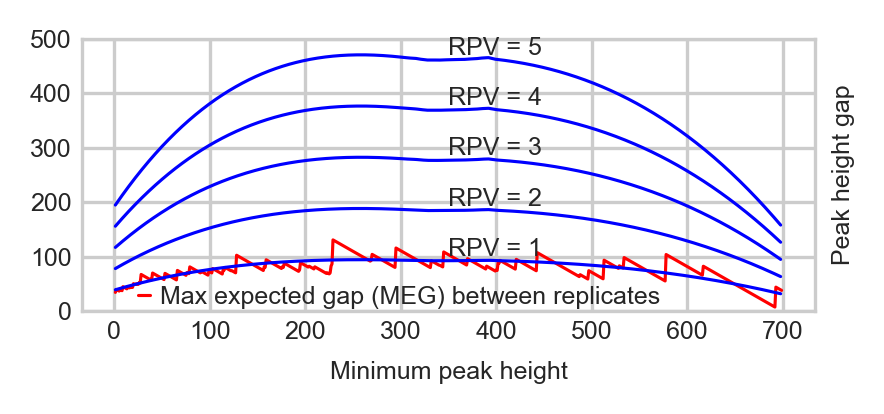

In [89]:
sns.set_style('whitegrid')
figsize=(75*mm,35*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
plot_df = pd.DataFrame(np.arange(1,700), columns=['min_height'])
plot_df['max_rep_gap'] = plot_df['min_height'].map(AR_gap)


sns.lineplot(x='min_height', y='max_rep_gap', data=plot_df, estimator=None, linewidth=0.75, color='red',
            label='Max expected gap (MEG) between replicates')

plot_df['RPV_1'] = plot_df['min_height'].map(AR_gap_smooth)
for j in [1,2,3,4,5]:
    plot_df['RPV_{}'.format(j)] = j*plot_df['RPV_1']
    sns.lineplot(x='min_height', y='RPV_{}'.format(j), data=plot_df, estimator=None, linewidth=0.75, color='blue')
    ax.text(350,plot_df.iloc[350]['RPV_{}'.format(j)],'RPV = {}'.format(j), va='bottom')

#ax.get_legend().remove()
ax.legend(bbox_to_anchor=(0.82,0.175), frameon=False)
ax.set_ylim(0,500)
ax.set_ylabel('')
ax.yaxis.set_label_position("right")
ax.set_xlabel('Minimum peak height')
ax.set_ylabel('Peak height gap')
ax.tick_params(axis='both', pad=-1)
#plt.suptitle('Replicate peak height gaps')

set_size(fig, figsize)
plt.savefig("Panels/RPV.pdf", bbox_inches='tight')
plt.show()

In [90]:
AR_mins

PeakID       Interval_51938  Interval_13433  Interval_27763  Interval_53540  \
ATAC_parent                                                                   
1                  9.129194      260.021179       23.032169       22.426058   
15                13.643296      294.407959       38.057606        0.775505   
22                 5.271756      298.309174       28.467484        2.695565   
23                 3.511219      225.495743       35.391712        0.000000   
8                  5.330869      231.596695       45.222027       28.431303   
9                 15.999111      226.299088       42.179478        1.939286   

PeakID       Interval_4280  Interval_6501  Interval_68580  Interval_72287  \
ATAC_parent                                                                 
1               114.114937     107.724480      234.564468      161.831314   
15              176.644745      90.734184      263.531036      202.495193   
22              145.560486     153.647186      186.620117      212.949646   
23              142.204330      74.613403      240.663666      193.137589   
8               166.607513      84.493797      236.225662      189.218552   
9               167.263412      51.391083      220.950180      183.262512   

PeakID       Interval_7590  Interval_38287  ...  Interval_78898  \
ATAC_parent                                 ...                   
1                92.734764      120.505394  ...        9.091646   
15               78.269417      127.816132  ...       33.031136   
22               94.891617       99.109016  ...        8.086695   
23               94.802902      132.466080  ...        7.900241   
8                72.855232      120.790443  ...       11.846376   
9                72.723251      127.550369  ...       11.635717   

PeakID       Interval_2270  Interval_27499  Interval_69022  Interval_56910  \
ATAC_parent                                                                  
1               327.738098       29.093264       53.862255      276.385986   
15              384.650787       36.448772       54.573177      300.152496   
22              384.838196       34.143818       50.317207      319.873718   
23              363.411072       23.700724       63.201912      276.055298   
8               376.714722       27.966263       63.667862      242.175858   
9               338.214294       30.858963       60.072109      234.116592   

PeakID       Interval_76540  Interval_57434  Interval_28417  Interval_45676  \
ATAC_parent                                                                   
1                 14.606714      128.721680      101.826431       20.607731   
15                 6.462613      152.230438      108.570793       17.061127   
22                15.815269      164.478760      102.272049        2.108702   
23                 1.011192      150.667603      107.186340        6.067150   
8                  4.760214      141.616379      107.209709        4.165188   
9                  2.908929      137.204468      118.498436       11.520679   

PeakID       Interval_8387  
ATAC_parent                 
1                60.252693  
15               18.669773  
22               34.793591  
23               45.503616  
8                52.716377  
9                86.298241  

[6 rows x 26040 columns]

In [91]:
A_gap_expected = (A_mins.astype(int) + 1).map(AR_gap_smooth)
mm_peaks = (A_maxs - A_mins) / A_gap_expected
mm_peaks.sort_values()

PeakID
Interval_55431    0.311093
Interval_57334    0.314030
Interval_9031     0.326581
Interval_26043    0.335871
Interval_68690    0.339834
                    ...   
Interval_72937    6.807849
Interval_53565    6.859019
Interval_42183    7.232115
Interval_33636    7.714061
Interval_20259    8.807651
Length: 26040, dtype: float64

In [92]:
ATAC_data.var['RPV'] = mm_peaks

# Quick peak viz

In [93]:
def ATAC_miniplot(peak_name, save=False):
    if type(peak_name) == int:
        peak = 'Interval_'+str(peak_name)
    else:
        peak = peak_name
    figsize=(25*mm,35*mm)
    fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
    sns.set_style('white')
    setfontsize()
    peak_heights = np.exp(pd.DataFrame(ATAC_data.to_df()[peak])) - 1
    peak_heights.columns = ['height']
    peak_heights['parent'] = ATAC_data.obs.ATAC_clone.apply(lambda c : c.split('_')[0])
    peak_heights['hue'] = ATAC_data.obs.colorclone
    peak_heights['x'] = (peak_heights['hue'] != 'Other').astype(int) + (peak_heights['hue'].isin(['5a','5b']))
    
    sns.scatterplot(x='x', y='height', color='gray',edgecolor='k',
                    data=peak_heights[peak_heights['hue'] == 'Other'], 
                    legend=False, ax=ax, s=5, alpha=0.8)
    
    parents = ['1','15','22','23','8','9']
    rgb_values = sns.color_palette("Dark2", 8)

    # Map label to RGB
    color_map = dict(zip(parents+['5a','5b'], rgb_values))
    
    for j,parent in enumerate(['1','15','22','23','8','9']):
        x = 0.5 + j*0.2 # 0.5, 0.7, 0.9, 1.1, 1.3, 1.5
        ymin = peak_heights[peak_heights['parent'] == parent].height.min()
        ymax = peak_heights[peak_heights['parent'] == parent].height.max()
        ax.plot([x,x],[ymin,ymax], color=color_map[parent], linewidth=1.0)
        ax.plot(x,ymin,'o',markersize=3, color=color_map[parent], alpha=0.75, 
                markeredgecolor=None, markeredgewidth=0)
        ax.plot(x,ymax,'o',markersize=3, color=color_map[parent], alpha=0.75, 
                markeredgecolor=None, markeredgewidth=0)
        
    for cl in ['5a','5b']:
        ax.plot(2, peak_heights[peak_heights['parent'] == cl].height, 'o', markersize=3,
               color=color_map[cl], alpha=0.8, markeredgewidth=0)
    ax.set_xlim(-0.5,2.5)
    #ax.set_ylim(0, peak_heights['height'].max()*1.2)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['non-reps','reps','5a/5b'], rotation=90, ha='center')
    ax.set_ylabel('Peak height'.format(peak_name))
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('')
    ax.tick_params(axis='both', pad=-1)
    hmin = peak_heights['height'].min()
    hmax = peak_heights['height'].max()
    if hmin < 10:
        ax.set_ylim(-1,peak_heights['height'].max()*1.1)
    ax.axhline(hmin, linewidth=0.5, color='steelblue')
    ax.axhline(hmax, linewidth=0.5, color='steelblue')
    plt.arrow(-0.3, hmin, 0, hmax-hmin, head_width=0.1, head_length=2, linewidth=0.5, color='steelblue', 
              length_includes_head=True)
    plt.arrow(-0.3, hmax, 0, hmin-hmax, head_width=0.1, head_length=2, linewidth=0.5, color='steelblue', 
              length_includes_head=True)
    #plt.annotate(text='', xy=(0.2,hmin), xytext=(0.2,hmax), arrowprops=dict(arrowstyle='<->'), color='k')
    j = 1
    while j <= mm_peaks[peak]:
        ax.axhline(hmin + j*AR_gap_smooth[int(hmin)+1], color='red', linewidth=0.5, zorder=-5)
        j += 1
    plt.suptitle('Int. {} \n RPV={:1.1f}'.format(peak_name, ATAC_data.var.loc[peak,'RPV']), y=1.15, x=0.55)
    set_size(fig, figsize)
    if save:
        plt.savefig("Panels/ATACminis/ATACmini_{}.pdf".format(peak_name), bbox_inches='tight')
    plt.show()

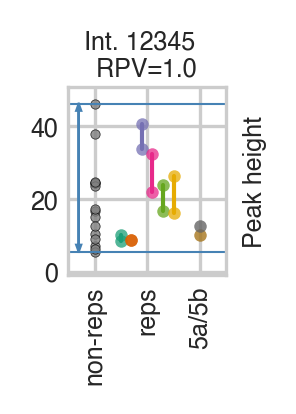

In [94]:
ATAC_miniplot(12345)

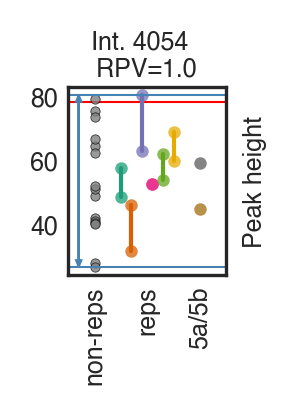

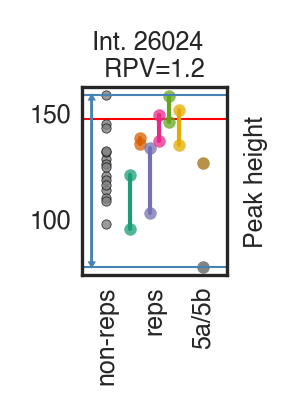

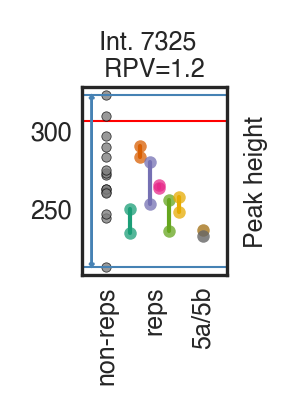

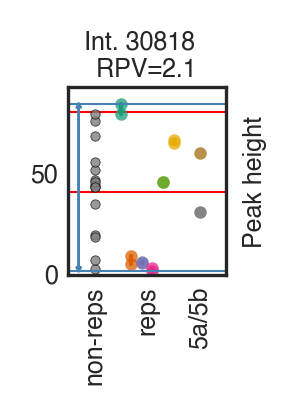

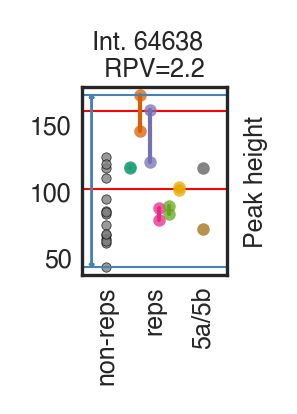

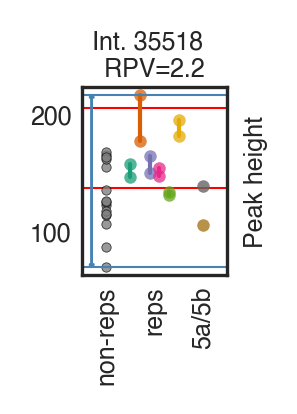

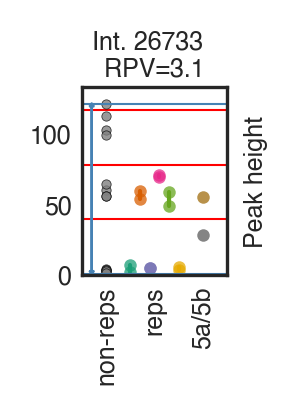

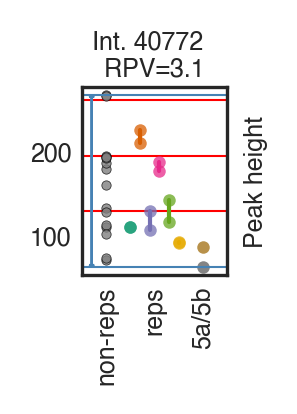

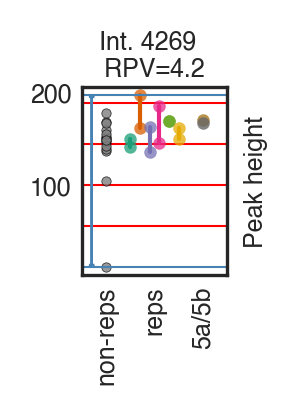

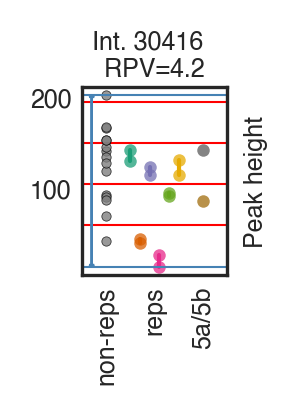

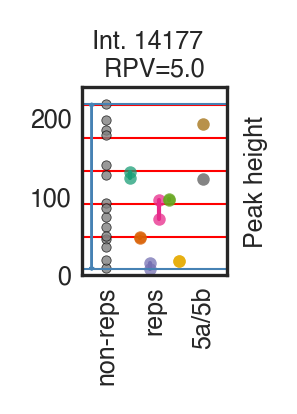

In [95]:
peak_samples = []
for m in [1,2,3,4,5]:
    for ht in [50,100,200]:
        m_list = mm_peaks[(mm_peaks > m) & (mm_peaks < m+0.25)].index
        h_list = A_maxs[(A_maxs > ht) & (A_maxs < ht*2)].index
        p_list = [peak for peak in m_list if peak in h_list]
        if len(p_list) > 0:
            ATAC_miniplot(int(p_list[0].split('_')[1]), save=True)
            peak_samples.append(p_list[0])
        

In [96]:
ATAC_data.var.loc[peak_samples].to_csv('peak_samples.csv')

In [97]:
mm_peaks[mm_peaks > 2].sort_values()

PeakID
Interval_41399    2.000427
Interval_76296    2.001921
Interval_68502    2.003072
Interval_40991    2.003240
Interval_78139    2.004915
                    ...   
Interval_72937    6.807849
Interval_53565    6.859019
Interval_42183    7.232115
Interval_33636    7.714061
Interval_20259    8.807651
Length: 803, dtype: float64

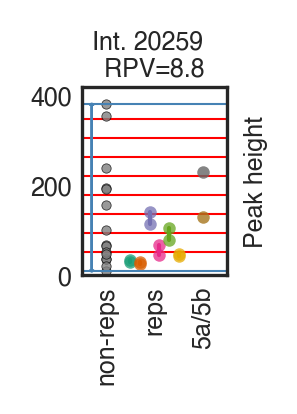

In [98]:
ATAC_miniplot(20259)

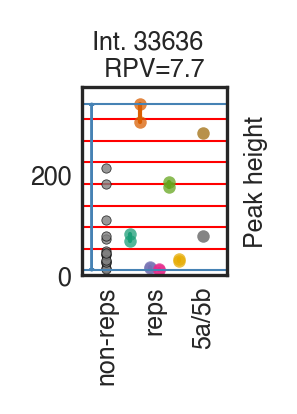

In [99]:
ATAC_miniplot(33636)

## Clonality of different types of peaks

In [100]:
ATAC_data.var.itype.value_counts()

promoter-TSS    10497
intron           8546
Intergen         4340
exon             1571
TTS              1086
Name: itype, dtype: int64

In [101]:
itypes = ['Intergen','intron','promoter-TSS','exon','TTS']

In [102]:
Q1 = mm_peaks.groupby(ATAC_data.var.itype).quantile(0.25)
Q3 = mm_peaks.groupby(ATAC_data.var.itype).quantile(0.75)
IQR = Q3 - Q1
flier_cutoff = Q3 + 1.5*IQR
fliers = {}
totpeaks = {}
sigpeaks = {}
for it in flier_cutoff.index:
    itpeaks = ATAC_data.var[ATAC_data.var.itype == it].index
    totpeaks[it] = len(itpeaks)
    mmit = mm_peaks.loc[itpeaks]
    fliers[it] = len(mmit[mmit > flier_cutoff[it]].index)
    sigpeaks[it] = len(mmit[mmit > 1.0].index)
fliers

{'Intergen': 256, 'TTS': 67, 'exon': 89, 'intron': 476, 'promoter-TSS': 471}

In [103]:
sigpeaks

{'Intergen': 1683,
 'TTS': 402,
 'exon': 573,
 'intron': 3166,
 'promoter-TSS': 4022}

In [104]:
totpeaks

{'Intergen': 4340,
 'TTS': 1086,
 'exon': 1571,
 'intron': 8546,
 'promoter-TSS': 10497}

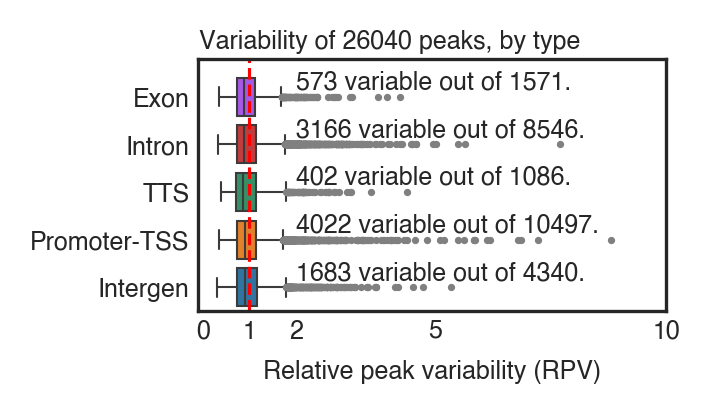

In [105]:
plot_df = pd.DataFrame(index = mm_peaks.index)

plot_df['itype'] = ATAC_data.var.itype
plot_df['Itype'] = plot_df['itype'].apply(lambda s :s[0].upper() + s[1:])
plot_df['variability'] = mm_peaks

sns.set_style('white')
figsize=(60*mm, 35*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

flierprops = dict(marker='o', markerfacecolor='gray', markersize=0.75, linestyle='none', 
                  linewidth=0, markeredgecolor='gray')

sns.boxplot(y='Itype', x='variability', data=plot_df, ax=ax, linewidth=0.5,
           flierprops=flierprops)

for j,it in enumerate(plot_df['itype'].unique()):
    ax.text(2,j+0.05,'{0:3d} variable out of {1:4d}.'.format(sigpeaks[it], totpeaks[it]), va='bottom')

ax.tick_params(axis='both', pad=-1.5)
ax.set_ylabel('')
ax.set_xlabel('Relative peak variability (RPV)')
ax.axvline(1.0, linewidth=0.75, color='red', linestyle='--')
ax.set_xticks([0,1,2,5,10])
ax.set_ylim(-0.5,4.8)
#ax.set_xlim(0,10)
plt.suptitle('Variability of {} peaks, by type'.format(len(plot_df)), y=1.0)
set_size(fig, figsize)
plt.savefig("Panels/Clonal_peaks.pdf", bbox_inches='tight')
plt.show()

In [106]:
ATAC_data.var.itype.value_counts()

promoter-TSS    10497
intron           8546
Intergen         4340
exon             1571
TTS              1086
Name: itype, dtype: int64

In [107]:
ATAC_data.var['Itype'] = ATAC_data.var.itype.map({'promoter-TSS':'Promoter-TSS',
                                              'intron':'Intron',
                                              'Intergen':'Intergen',
                                              'exon':'Exon',
                                              'TTS':'TTS'})

In [108]:
ATAC_data.var.Itype.value_counts()

Promoter-TSS    10497
Intron           8546
Intergen         4340
Exon             1571
TTS              1086
Name: Itype, dtype: int64

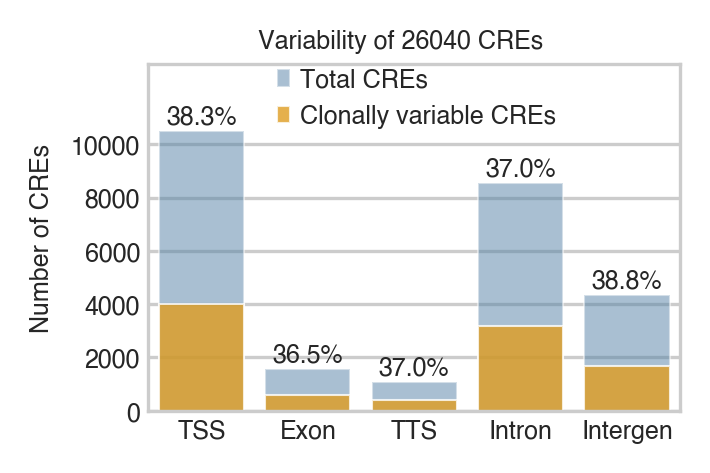

In [109]:
Itypes = ['Promoter-TSS','Exon','TTS','Intron','Intergen']
short_dict = {'Promoter-TSS':'TSS', 'Exon':'Exon', 'TTS':'TTS', 
              'Intron':'Intron', 'Intergen':'Intergen'}
plot_df = pd.DataFrame(index = Itypes)
plot_df['Itype'] = plot_df.index
plot_df['Itype'] = plot_df['Itype'].map(short_dict)

plot_df['Total CREs'] = ATAC_data.var.Itype.value_counts()
var_peaks = mm_peaks[mm_peaks >= 1.0].index
plot_df['Clonally variable CREs'] = ATAC_data.var.loc[var_peaks].Itype.value_counts()
plot_df['proportion'] = plot_df['Clonally variable CREs'] / plot_df['Total CREs']

sns.set_style('whitegrid')
figsize=(60*mm, 40*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sns.barplot(x='Itype', y='Total CREs', color='steelblue', alpha=0.5, data=plot_df, ax=ax, linewidth=0.5,
           label='Total CREs')

sns.barplot(x='Itype', y='Clonally variable CREs', color='orange', alpha=0.8, data=plot_df, ax=ax, linewidth=0.5,
           label = 'Clonally variable CREs')

for j,it in enumerate(plot_df.index):
    ax.text(j,plot_df.loc[it,'Total CREs']+100,
            '{0:1.1%}'.format(plot_df.loc[it,'proportion']), va='bottom', ha='center')

ax.tick_params(axis='both', pad=-1.5)
ax.legend(frameon=False, bbox_to_anchor=(0.2,0.75))
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=0, ha='center')
ax.set_ylabel('Number of CREs')
ax.set_xlabel('')
ax.set_ylim(0,12999)
ax.set_yticks([0,2000,4000,6000,8000,10000])

#ax.set_xlim(0,10)
plt.suptitle('Variability of {} CREs'.format(plot_df['Total CREs'].sum()), y=0.99, x=0.55)
set_size(fig, figsize)
plt.savefig("Panels/Clonal_peaks_bar.pdf", bbox_inches='tight')
plt.show()

## Clonally variable CREs, near expressed genes?

In [110]:
var_peaks = mm_peaks[mm_peaks > 1.0].index
len(var_peaks)

9846

In [111]:
near_expgenes = pd.Series(0, index=var_peaks)
#near_expgenes['num_genes'] = 0
for chrome in ATAC_data.var['chr'].unique():
    num_genes = near_dfs[chrome].sum()
    chr_peaks = [peak for peak in var_peaks if peak in num_genes.index]
    near_expgenes.loc[chr_peaks] = num_genes

var_peaks_ng = near_expgenes[near_expgenes > 0].index # peaks near a gene.

In [112]:
pie_df = pd.Series(0, index = ['Not near gene'] + ['Intron','Promoter-TSS','Exon','TTS','Intergen'])
pie_df['Not near gene'] = len(near_expgenes) - len(var_peaks_ng)
counts_near_gene = ATAC_data.var.loc[var_peaks_ng].Itype.value_counts()
for it in Itypes:
    pie_df[it] = counts_near_gene[it]
pie_df

Not near gene    3750
Intron           1771
Promoter-TSS     3068
Exon              372
TTS               272
Intergen          613
dtype: int64

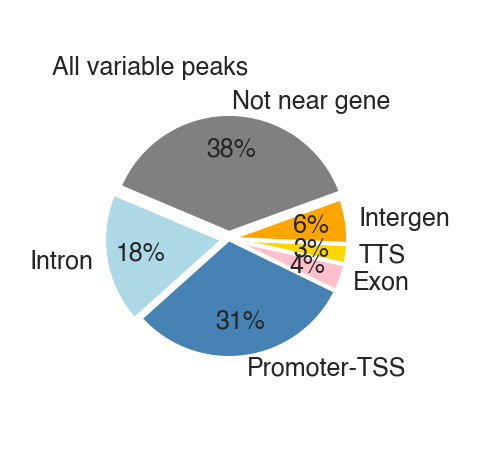

In [113]:
sns.set_style('white')
setfontsize()
figsize=(40*mm, 40*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)

ax.pie(pie_df, explode=[0.05,0.05,0,0,0,0], labels=pie_df.index, autopct='%1.f%%',
        shadow=False, startangle=20, pctdistance=0.7, 
      colors=['gray','lightblue','steelblue','pink','gold','orange'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.suptitle('All variable peaks', x=0.35, y=0.86)

set_size(fig, figsize)
plt.savefig("Panels/Var_peaks_type_PIE.pdf", bbox_inches='tight')

plt.show()

In [114]:
sig_genes = adata.var[adata.var.F_pval < 0.05].index
gp_df = pd.DataFrame(0, columns = sig_genes, index=Itypes)
for gene in sig_genes:
    chrome = adata.var.loc[gene,'chr']
    if chrome in near_dfs.keys():
        near_peaks = near_dfs[chrome].loc[gene]
        near_peaks = near_peaks[near_peaks].index
        mmp = mm_peaks.loc[near_peaks]
        near_varpeaks = mmp[mmp > 1.0].index
        gp_df[gene] = ATAC_data.var.loc[near_varpeaks].Itype.value_counts()
gp_df = gp_df.fillna(0).astype(np.int32)

In [115]:
gp_df

gene_name     hsa-mir-6723  MTATP6P1  ISG15  RP11-465B22.3  TNFRSF18  UBE2J2  \
Promoter-TSS             0         0      0              2         0       1   
Exon                     0         0      0              0         0       0   
TTS                      0         0      0              0         0       0   
Intron                   0         0      0              0         0       0   
Intergen                 0         0      0              0         1       0   

gene_name     RP3-395M20.8  TNFRSF14  LRRC47  C1orf174  ...  IDH3G-1  NAA10-1  \
Promoter-TSS             2         2       0         1  ...        0        2   
Exon                     0         0       0         0  ...        0        0   
TTS                      1         1       0         0  ...        0        0   
Intron                   1         1       0         0  ...        0        0   
Intergen                 0         0       0         0  ...        0        0   

gene_name     EMD-1  RPL10-1  ATP6AP1-1  FAM50A-1  DKC1-1  VBP1-1  TMLHE-1  \
Promoter-TSS      2        2          0         0       0       0        0   
Exon              0        0          0         0       0       0        0   
TTS               0        0          0         0       0       0        0   
Intron            1        1          0         0       1       0        0   
Intergen          0        0          0         0       0       0        0   

gene_name     AC010970.2  
Promoter-TSS           0  
Exon                   0  
TTS                    0  
Intron                 0  
Intergen               0  

[5 rows x 1899 columns]

In [116]:
plot_ser = pd.Series(0, index=['No variable peaks','TSS only','TSS+Enhancers','Enhancers only'])
plot_ser['No variable peaks'] = (gp_df.sum() == 0).sum()
plot_ser['TSS only'] = ((gp_df.sum() > 0) & (gp_df.sum() == gp_df.loc['Promoter-TSS'])).sum()
plot_ser['Enhancers only'] = ((gp_df.sum() > 0) & (gp_df.loc['Promoter-TSS'] == 0)).sum()
plot_ser['TSS+Enhancers'] = len(gp_df.columns) - plot_ser.sum()
#plot_df['TSS + Enhancers'] = len(gp_df.columns) - (plot_df['No variable peaks'] + plot_df['TSS only'])

plot_ser

No variable peaks    743
TSS only             536
TSS+Enhancers        297
Enhancers only       323
dtype: int64

In [117]:
plot_df = pd.DataFrame(plot_ser, columns=['Number'])
plot_df['class'] = plot_ser.index
plot_df

Number              class
No variable peaks     743  No variable peaks
TSS only              536           TSS only
TSS+Enhancers         297      TSS+Enhancers
Enhancers only        323     Enhancers only

In [118]:
insig_genes = adata.var[adata.var.F_pval >= 0.05].index
gp_null_df = pd.DataFrame(0, columns = insig_genes, index=Itypes)
for gene in insig_genes:
    chrome = adata.var.loc[gene,'chr']
    if chrome in near_dfs.keys():
        near_peaks = near_dfs[chrome].loc[gene]
        near_peaks = near_peaks[near_peaks].index
        mmp = mm_peaks.loc[near_peaks]
        near_varpeaks = mmp[mmp > 1.0].index
        gp_null_df[gene] = ATAC_data.var.loc[near_varpeaks].Itype.value_counts()
gp_null_df = gp_null_df.fillna(0).astype(np.int32)

In [119]:
plot_ser = pd.Series(0, index=['No variable peaks','TSS only','TSS+Enhancers','Enhancers only'])
plot_ser['No variable peaks'] = (gp_null_df.sum() == 0).sum()
plot_ser['TSS only'] = ((gp_null_df.sum() > 0) & (gp_null_df.sum() == gp_null_df.loc['Promoter-TSS'])).sum()
plot_ser['Enhancers only'] = ((gp_null_df.sum() > 0) & (gp_null_df.loc['Promoter-TSS'] == 0)).sum()
plot_ser['TSS+Enhancers'] = len(gp_null_df.columns) - plot_ser.sum()
#plot_df['TSS + Enhancers'] = len(gp_df.columns) - (plot_df['No variable peaks'] + plot_df['TSS only'])

plot_ser

No variable peaks    3139
TSS only             2316
TSS+Enhancers         973
Enhancers only       1226
dtype: int64

In [120]:
plot_df_null = pd.DataFrame(plot_ser, columns=['Number'])
plot_df_null['class'] = plot_ser.index
plot_df_null['Number'] = plot_df_null['Number'] * (plot_df['Number'].sum() / plot_df_null['Number'].sum())
plot_df_null

Number              class
No variable peaks  778.803371  No variable peaks
TSS only           574.612490           TSS only
TSS+Enhancers      241.406715      TSS+Enhancers
Enhancers only     304.177424     Enhancers only

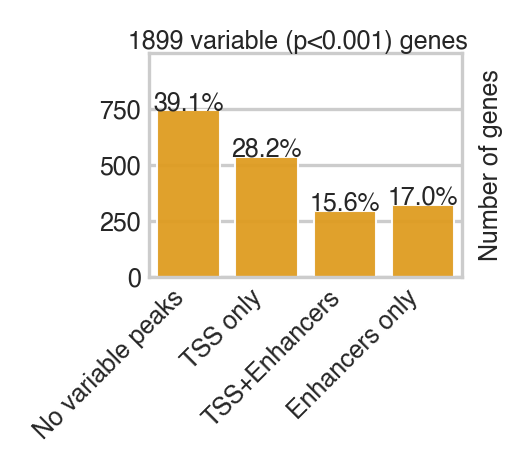

In [121]:
mm = 1 / 25.4
sns.set_style('whitegrid')
figsize=(45*mm, 40*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

#sns.barplot(x='class', y='Number', color='k', alpha=0.96, 
#            data=plot_df_null, ax=ax, linewidth=0.5, label=None)

sns.barplot(x='class', y='Number', color='orange', alpha=0.95, 
            data=plot_df, ax=ax, linewidth=0.5, label=None)

ax.tick_params(axis='both', pad=-1.5)

for j,(index,row) in enumerate(plot_df.iterrows()):
    ax.text(j, row['Number'], '{:1.1%}'.format(row['Number'] / plot_df.Number.sum()), ha='center')
#ax.legend(frameon=False, bbox_to_anchor=(0.2,0.75))
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.set_ylabel('Number of genes')
ax.yaxis.set_label_position("right")
ax.set_xlabel('')
ax.set_ylim(0,1000)
ax.set_yticks([0,250,500,750])

#ax.set_xlim(0,10)
plt.suptitle('{} variable (p<0.001) genes'.format(plot_df.Number.sum()), y=0.99, x=0.55)
set_size(fig, figsize)
plt.savefig("Panels/Var_genes_bar.pdf", bbox_inches='tight')
plt.show()

In [122]:
var_peaks = mm_peaks[mm_peaks > 1.0].index
len(var_peaks)

9846

In [123]:
top_freqs = pd.DataFrame(ATAC_data.to_df()[var_peaks].idxmax().value_counts())
top_freqs.columns = ['Number of wins']
top_freqs['clone'] = ATAC_data.obs.ATAC_clone
top_freqs['Cell Number'] = ATAC_data.obs['Cell Number']
top_freqs

Number of wins  clone  Cell Number
P9855_2087             811   4_R1        410.0
P9855_2102             757  15_R2       1000.0
P9855_2097             737  11_R1        269.0
P9855_2113             723  24_R1       1000.0
P9855_2094             658   3_R1        506.0
P9855_2101             537  15_R1       1000.0
P9855_2110             506  22_R1       1000.0
P9855_2092             500  10_R1        350.0
P9855_2100             446  14_R1        500.0
P9855_2095             412  5b_R1       1000.0
P9855_2106             401  17_R1       1000.0
P9855_2099             356  13_R1        500.0
P9855_2111             339  22_R2       1000.0
P9855_2109             312  21_R1       1000.0
P9855_2103             248  16_R1        700.0
P9855_2112             220  23_R2       1000.0
P9855_2104             191  23_R1       1000.0
P9855_2098             191  5a_R1        500.0
P9855_2108             171  20_R1        918.0
P9855_2088             164   7_R1       1000.0
P9855_2086             161   2_R1        705.0
P9855_2096             158   9_R2       1000.0
P9855_2105             150  18_R1       1000.0
P9855_2091             148   9_R1       1000.0
P9855_2089             139   8_R1       1000.0
P9855_2090             131   8_R2       1000.0
P9855_2085             110   1_R1       1000.0
P9855_2107             100  19_R1       1000.0
P9855_2093              69   1_R2       1000.0

# Panel:  Peak heatmap

In [124]:
mm_peaks.sort_values()[-1000:]

PeakID
Interval_76395    1.897334
Interval_1833     1.898406
Interval_15336    1.898746
Interval_15760    1.899788
Interval_192      1.900395
                    ...   
Interval_72937    6.807849
Interval_53565    6.859019
Interval_42183    7.232115
Interval_33636    7.714061
Interval_20259    8.807651
Length: 1000, dtype: float64

In [125]:
p_peaks = mm_peaks.sort_values()[-1000:].index

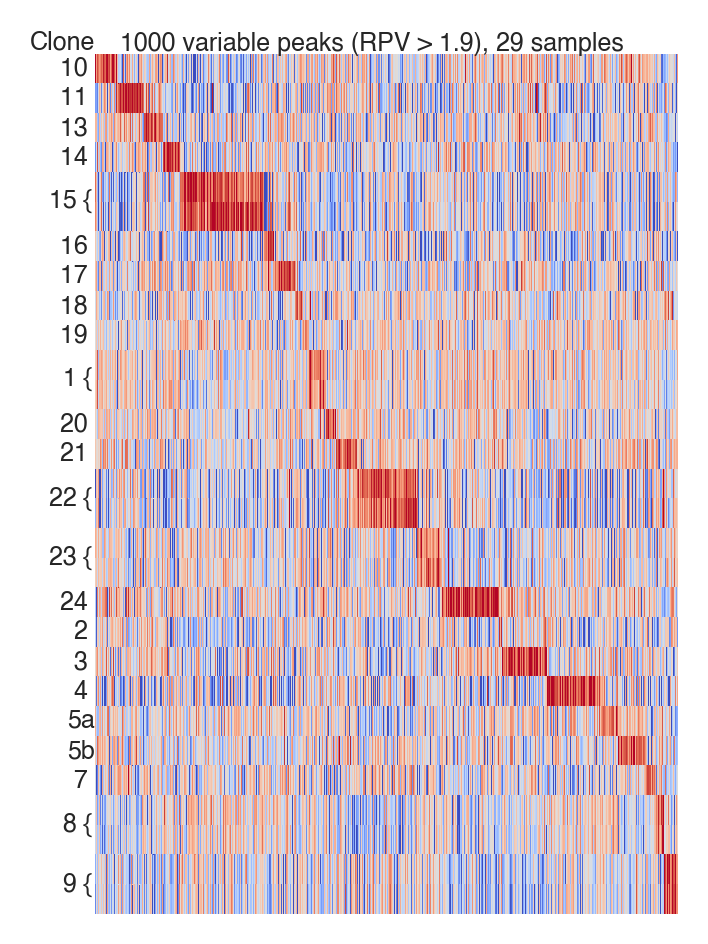

In [126]:
plot_df = ATAC_data.to_df()[p_peaks].copy()

plot_df.index = ATAC_data.obs.ATAC_clone
plot_df.sort_index(inplace=True)

plot_df = (plot_df - plot_df.mean()) / plot_df.std()

#display(plot_df.idxmax().sort_values())

var_peaks = plot_df.idxmax().sort_values().index
plot_df = plot_df[var_peaks]

figsize=(60*mm, 80*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sns.heatmap(plot_df, vmin=-2, vmax=2, cmap='coolwarm', 
            xticklabels=False, yticklabels=False,
            cbar=False, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')
for y,clone in [(11,1), (5,15), (15,22), (17,23), (26,8), (28,9)]:
    ax.text(-5,y,str(clone) + ' {', va='center', ha='right', fontsize=6)
    
for j,clone in enumerate(plot_df.index):
    par = clone.split('_')[0]
    if par not in ['1','15','22','23','8','9','5a','5b']:
        ax.text(-0.1,j+0.5,par + ' ', va='center', ha='right', fontsize=6)
    
ax.text(-0.1,22.5,'5a', va='center', ha='right', fontsize=6)
ax.text(-0.1,23.5,'5b', va='center', ha='right', fontsize = 6)


ax.text(0.5,0,'Clone', va='bottom', ha='right', fontsize=6)
RPV_min = mm_peaks[p_peaks].min()
plt.suptitle('{} variable peaks (RPV > {:1.1f}), {} samples'.format(len(var_peaks), RPV_min, len(plot_df)), 
             x=0.55,y=0.93)
set_size(fig, figsize)
plt.savefig("Panels/PeakHeatmap_new.pdf", bbox_inches='tight')

plt.show()

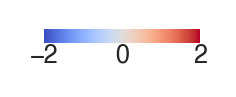

In [127]:
import matplotlib as mpl

figsize = (20*mm, 8*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
sns.set_style('white')
setfontsize()

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-2, vmax=2)

cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                  cax=ax, orientation='horizontal')

#[s.set_visible(False) for s in ax.spines.values()]
cb.outline.set_visible(False)
ax.tick_params(axis='x', pad=0, length=0)

set_size(fig, figsize)
plt.savefig('Panels/Heatmap_colorbar.pdf', bbox_inches='tight')
    
plt.show()

Here are the genes near the most clonal peaks, in order.

In [128]:
near_genes = ATACR_data.var.loc[mm_peaks.sort_values()[-100:].index].in_gene
near_genes = near_genes[near_genes != 'nan']
near_genes = near_genes[near_genes.isin(adata.var_names)]
near_genes = near_genes.values
print(', '.join(near_genes))

RP11-611E13.2, AC104820.2, NMRAL1, GPHN, C21orf33, RASGRP2, CPNE8, IKZF2, ADAT1, CPOX, SPG20, DNAJB6, IKZF2, NR1H2, CD226, IL4, RAPGEF1, ASPH, AUTS2, S100A4, AUTS2, WWOX, CDK5RAP1, PIP5K1B, CADM1, HPGD, ARL4A, GOLIM4, TIAM1, LAYN, MAP3K7CL, FAM46A, MSC, ATP9B, SPRY2


# Peak-gene correlations

Now we create a giant correlation matrix -- one for each chromosome -- between gene expression (clonal average) and peak height (clonal average), for all genes and peaks on that chromosome.  We only use the "good clones" (16 out of 24 clones) found in preprocessing, when computing these correlations.  We also restrict to "good" peaks, where replicates have close peak heights.

In [129]:
genes = adata.var_names
genes

Index(['MTND2P28', 'hsa-mir-6723', 'MTATP6P1', 'RP11-206L10.9', 'LINC01128',
       'NOC2L', 'ISG15', 'RP11-465B22.3', 'TNFRSF18', 'TNFRSF4',
       ...
       'F8-1', 'FUNDC2-1', 'BRCC3-1', 'VBP1-1', 'RAB39B-1', 'TMLHE-1', 'VAMP7',
       'SRIP3', 'AC010970.2', 'RNA5-8SP6'],
      dtype='object', name='gene_name', length=9553)

In [130]:
ATAC_data

AnnData object with n_obs × n_vars = 29 × 26040
    obs: 'ATAC_clone', 'ATAC_parent', 'Batch', 'Cell Number', 'Clone ID', 'Clone_ID', 'Clone_ID_InVitro', 'Condition', 'D', 'D.1', 'Donor', 'HLA Type', 'In_Vivo_Clone_Number', 'Is_replicate', 'Ja', 'Ja2', 'Jb', 'Jb2', 'Nuc_Seq_TRA', 'Nuc_Seq_TRA_2', 'Nuc_Seq_TRB', 'Read_Count', 'Read_Count.1', 'Sample_name', 'TCR Alpha', 'TCR Alpha2', 'TCR Beta', 'TRB', 'Unnamed: 21', 'Va', 'Va2', 'Vb', 'Vb2', 'count', 'founder_pheno', 'notes', 'protein_pheno', 'sequence', 'colorclone'
    var: 'PeakID', 'chr', 'end', 'in_ensg', 'in_gene', 'itype', 'max_height', 'mid', 'start', 'near_genes', 'replicate_foldchange', 'replicate_spread', 'RPV', 'Itype'

In [131]:
peaks = ATAC_data.var_names
peaks

Index(['Interval_51938', 'Interval_13433', 'Interval_27763', 'Interval_53540',
       'Interval_4280', 'Interval_6501', 'Interval_68580', 'Interval_72287',
       'Interval_7590', 'Interval_38287',
       ...
       'Interval_78898', 'Interval_2270', 'Interval_27499', 'Interval_69022',
       'Interval_56910', 'Interval_76540', 'Interval_57434', 'Interval_28417',
       'Interval_45676', 'Interval_8387'],
      dtype='object', name='PeakID', length=26040)

In [132]:
chromes = [str(j) for j in range(1,23)] + ['X','Y']
print(chromes)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']


For each of the good clones, we create dataframes of the clonal averages for gene expression and peak height.

In [133]:
test_clones = adata.obs[adata.obs['Good clone'] == True].Clone_ID.unique()
test_clones = [clone for clone in test_clones if clone in ATAC_data.obs.Clone_ID.unique()]

pd_peak = ATAC_data[ATAC_data.obs['Clone_ID'].isin(test_clones)]
pd_gene = adata[adata.obs['Clone_ID'].isin(test_clones)]

gene_clonal = pd_gene.to_df().groupby(pd_gene.obs.Clone_ID).mean()
peak_clonal = pd_peak.to_df().groupby(pd_peak.obs.Clone_ID).mean()

In [134]:
gene_clonal

gene_name  MTND2P28  hsa-mir-6723  MTATP6P1  RP11-206L10.9  LINC01128  \
Clone_ID                                                                
P1_A03     3.230169      2.079046  5.749669       0.000000   0.000000   
P1_A05     2.709148      1.453811  5.383322       0.000000   0.000000   
P1_A08     3.050509      1.614846  5.801980       0.000000   0.000000   
P1_A12     3.035853      1.859284  5.475892       0.887302   0.958630   
P1_B10     3.112417      2.253648  5.691962       0.000000   0.902409   
P1_C11     2.745569      1.978039  5.837260       0.000000   0.000000   
P1_D09     2.575861      1.505550  5.739470       0.948192   1.076902   
P1_F10     2.922449      1.693547  5.865429       0.000000   0.000000   
P1_H01     3.106876      1.949256  5.824675       0.000000   0.000000   
P1_H10     2.250069      1.485239  5.613591       0.000000   0.000000   
P2_A04     3.237091      1.334472  5.566094       0.957045   0.000000   
P2_B11     3.307103      2.163680  5.705452       1.188340   0.000000   
P2_G01     3.005000      0.545083  4.770329       0.000000   0.000000   
P2_G09     2.708898      1.455621  5.396387       0.000000   1.132141   
P2_H04     2.315471      1.711872  5.294865       0.351379   0.000000   
P2_H05     2.047147      0.479275  4.363872       0.000000   0.000000   

gene_name     NOC2L     ISG15  RP11-465B22.3  TNFRSF18   TNFRSF4  ...  \
Clone_ID                                                          ...   
P1_A03     2.308283  7.334683       0.000000  3.254865  1.157134  ...   
P1_A05     2.970573  6.024615       0.000000  4.569802  1.087413  ...   
P1_A08     0.000000  7.358630       0.000000  5.370294  1.082879  ...   
P1_A12     2.351700  6.635680       0.000000  5.170679  0.412726  ...   
P1_B10     2.168520  6.953883       1.071905  5.509768  0.000000  ...   
P1_C11     2.254454  4.855477       0.000000  3.198215  0.000000  ...   
P1_D09     1.631425  5.360824       3.277528  4.126095  2.221344  ...   
P1_F10     2.471754  6.654633       1.307794  3.869681  1.221896  ...   
P1_H01     2.190555  6.236783       0.000000  3.081303  0.337937  ...   
P1_H10     3.127002  5.592022       0.000000  4.690275  0.942922  ...   
P2_A04     1.419956  5.599187       0.000000  3.480796  0.000000  ...   
P2_B11     2.022410  5.456667       0.000000  1.635330  1.342189  ...   
P2_G01     1.528105  8.190660       0.000000  0.885717  0.000000  ...   
P2_G09     0.000000  6.837132       0.000000  4.499185  0.000000  ...   
P2_H04     0.000000  5.778849       0.000000  3.573749  0.000000  ...   
P2_H05     0.000000  5.500018       0.000000  0.172438  0.147221  ...   

gene_name      F8-1  FUNDC2-1   BRCC3-1    VBP1-1  RAB39B-1   TMLHE-1  \
Clone_ID                                                                
P1_A03     0.000000  2.843147  2.523289  3.442465  0.000000  0.000000   
P1_A05     0.000000  3.934277  3.737265  4.640422  0.000000  1.077093   
P1_A08     1.002046  4.011677  2.558638  4.284044  0.000000  2.961611   
P1_A12     0.224331  4.294168  2.767888  4.635580  0.864102  3.820885   
P1_B10     0.000000  2.429938  0.000000  2.663473  0.772005  3.728553   
P1_C11     0.000000  2.998382  1.462838  3.882571  0.891281  1.206362   
P1_D09     0.548206  3.907003  3.097841  4.354332  0.685584  1.847692   
P1_F10     1.232553  1.618218  3.844646  4.177619  0.901349  0.000000   
P1_H01     0.000000  2.998327  2.415796  4.209680  0.000000  1.493295   
P1_H10     0.000000  2.596592  1.918516  4.173988  0.000000  0.761494   
P2_A04     0.000000  3.139159  0.000000  2.827251  0.000000  2.954389   
P2_B11     0.000000  3.682788  2.343420  4.453341  0.000000  4.217452   
P2_G01     0.000000  1.196341  1.552464  0.000000  0.000000  1.926167   
P2_G09     0.000000  3.030712  1.711892  4.846723  2.136081  0.000000   
P2_H04     0.000000  2.841082  0.465016  2.514537  1.168372  0.000000   
P2_H05     0.000000  4.360162  0.000000  0.000000  1.405290  0.000000   

gene_name     VAMP7     SRIP3  AC010970.2  RNA5-8SP6  


In [135]:
peak_clonal

PeakID    Interval_51938  Interval_13433  Interval_27763  Interval_53540  \
Clone_ID                                                                   
P1_A03          2.529633        5.617923        3.278499        3.233557   
P1_A05          1.972389        5.437860        3.517708        2.451669   
P1_A08          2.287843        5.560565        3.709698        3.762476   
P1_A12          2.426444        5.683740        3.585825        3.326052   
P1_B10          1.853198        5.436592        3.504991        3.114438   
P1_C11          2.591159        5.644123        3.638525        3.083403   
P1_D09          3.449496        5.493403        3.700081        3.607240   
P1_F10          2.824024        5.619921        3.443976        3.507894   
P1_H01          1.892109        5.518234        3.856328        3.475958   
P1_H10          2.869512        5.432869        3.799819        1.578473   
P2_A04          2.967492        5.697934        3.824545        0.732249   
P2_B11          0.000000        5.558466        4.033247        3.964330   
P2_G01          2.775430        5.629741        3.436920        2.986031   
P2_G09          2.128885        5.444118        3.869145        2.991982   
P2_H04          1.969373        5.705107        3.431467        1.571595   
P2_H05          2.000840        5.533689        3.602494        0.553023   

PeakID    Interval_4280  Interval_6501  Interval_68580  Interval_72287  \
Clone_ID                                                                 
P1_A03         4.882648       4.752263        5.469793        5.140104   
P1_A05         5.108484       4.493093        5.533124        5.205187   
P1_A08         5.194549       4.519068        5.543390        5.414121   
P1_A12         5.100070       4.740612        5.524294        5.149168   
P1_B10         5.243369       4.985421        5.780162        5.169667   
P1_C11         5.247215       4.287120        5.610814        5.226705   
P1_D09         5.154146       4.445949        5.408775        5.033196   
P1_F10         5.158548       4.699069        5.427788        5.309041   
P1_H01         5.182631       4.508285        5.476674        5.253664   
P1_H10         5.147631       4.061644        5.429313        5.223673   
P2_A04         5.182442       4.576645        5.627039        5.335967   
P2_B11         5.195662       4.471122        5.540189        5.331752   
P2_G01         5.123996       4.585413        5.571364        5.132912   
P2_G09         5.031900       4.856232        5.418911        5.213133   
P2_H04         5.082010       5.068582        5.355668        5.396853   
P2_H05         5.061416       4.439970        5.508592        5.290628   

PeakID    Interval_7590  Interval_38287  ...  Interval_78898  Interval_2270  \
Clone_ID                                 ...                                  
P1_A03         4.547335        4.800413  ...        2.701310       5.834497   
P1_A05         4.681770        4.768009  ...        1.972389       5.811915   
P1_A08         5.077458        4.879703  ...        2.658895       5.847285   
P1_A12         4.758474        4.859426  ...        2.862755       5.690734   
P1_B10         4.403090        4.662625  ...        1.853198       5.919521   
P1_C11         4.618135        4.895682  ...        2.591159       5.834918   
P1_D09         3.900287        5.033196  ...        3.031354       5.705334   
P1_F10         4.800375        4.817234  ...        1.974084       5.943502   
P1_H01         4.320146        4.823890  ...        2.577711       5.941096   
P1_H10         4.303802        4.909767  ...        2.593704       5.857391   
P2_A04         4.433029        4.902121  ...        3.553975       5.967187   
P2_B11         4.523455        4.843583  ...        1.892865       5.867593   
P2_G01         4.754437        4.841271  ...        2.907030       5.825328   
P2_G09         4.755282        4.823701  ...        2.650796       5.956059   
P2_H04         4.630580        4.7

The following function creates the giant correlation matrix.

In [136]:
def pg_corr(chrome, method='pearson'):
    pd_peak = peak_clonal.loc[:,ATAC_data.var.chr == chrome]
    pd_gene = gene_clonal.loc[:,adata.var.chr == chrome]
    
    print('Making corr. matrix for chromosome {} with {} peaks and {} genes.'.format(
        chrome, pd_peak.shape[1], pd_gene.shape[1]))

    A = pd_peak
    E = pd_gene
    
    if method == 'spearman':
        A = A.rank()
        E = E.rank()
    Az = (A - A.mean())
    Ez = (E - E.mean())
    C = Az.T.dot(Ez).div(len(A)).div(Ez.std(ddof=0)).div(Az.std(ddof=0), axis=0)
    return C.sort_index()

It will take just a few seconds to make the correlation matrices for every chromosome.

In [137]:
pg_corrs = {}
for chrome in chromes:
    pg_corrs[chrome] = pg_corr(chrome).fillna(0)

Making corr. matrix for chromosome 1 with 2506 peaks and 1009 genes.
Making corr. matrix for chromosome 2 with 2029 peaks and 667 genes.
Making corr. matrix for chromosome 3 with 1602 peaks and 569 genes.
Making corr. matrix for chromosome 4 with 946 peaks and 348 genes.
Making corr. matrix for chromosome 5 with 1281 peaks and 444 genes.
Making corr. matrix for chromosome 6 with 1636 peaks and 509 genes.
Making corr. matrix for chromosome 7 with 1227 peaks and 444 genes.
Making corr. matrix for chromosome 8 with 1036 peaks and 304 genes.
Making corr. matrix for chromosome 9 with 1013 peaks and 362 genes.
Making corr. matrix for chromosome 10 with 1201 peaks and 367 genes.
Making corr. matrix for chromosome 11 with 1299 peaks and 526 genes.
Making corr. matrix for chromosome 12 with 1361 peaks and 540 genes.
Making corr. matrix for chromosome 13 with 540 peaks and 174 genes.
Making corr. matrix for chromosome 14 with 885 peaks and 323 genes.
Making corr. matrix for chromosome 15 with 85

In [138]:
pg_corrs['1']

gene_name      MTND2P28  hsa-mir-6723  MTATP6P1  RP11-206L10.9  LINC01128  \
PeakID                                                                      
Interval_1    -0.317932      0.009631 -0.343913       0.316497   0.193828   
Interval_1001  0.207955     -0.159308 -0.146043      -0.160552   0.300706   
Interval_1004 -0.074754      0.094863 -0.007304      -0.283963  -0.209247   
Interval_1009 -0.289785     -0.049635 -0.049130       0.145286  -0.361560   
Interval_1010 -0.273243     -0.378463 -0.266250      -0.106453  -0.587399   
...                 ...           ...       ...            ...        ...   
Interval_991   0.176444      0.117449  0.266096      -0.060272  -0.343233   
Interval_995   0.011107     -0.343523 -0.325749      -0.046307  -0.551203   
Interval_997  -0.152221     -0.245598 -0.044715      -0.118949  -0.316882   
Interval_998   0.000540     -0.432170 -0.192172       0.242101  -0.558788   
Interval_999  -0.347316     -0.321408  0.035192      -0.068291  -0.256247   

gene_name         NOC2L     ISG15  RP11-465B22.3  TNFRSF18   TNFRSF4  ...  \
PeakID                                                                ...   
Interval_1    -0.297667 -0.325455      -0.055647 -0.323858 -0.367857  ...   
Interval_1001  0.233133  0.264491      -0.162487  0.113121 -0.180023  ...   
Interval_1004  0.176431  0.170090      -0.462917  0.234146 -0.163163  ...   
Interval_1009  0.162530 -0.532717      -0.146296 -0.308913  0.051631  ...   
Interval_1010 -0.081949 -0.141852      -0.375423 -0.485912  0.083750  ...   
...                 ...       ...            ...       ...       ...  ...   
Interval_991  -0.350101  0.194163      -0.096308 -0.136911  0.101305  ...   
Interval_995  -0.245097  0.135524      -0.484733 -0.492846 -0.243990  ...   
Interval_997  -0.390602  0.008088      -0.154562 -0.228409 -0.246629  ...   
Interval_998  -0.110987 -0.083619      -0.152698 -0.426442  0.118764  ...   
Interval_999  -0.029454 -0.197141      -0.001764 -0.030616  0.338192  ...   

gene_name         TFB2M      CNST    SCCPDH    AHCTF1    ZNF669    ZNF124  \
PeakID                                                                      
Interval_1    -0.311465 -0.275282 -0.014443 -0.336016  0.086990 -0.093568   
Interval_1001  0.120046  0.237814  0.150684  0.047232  0.362900  0.398546   
Interval_1004 -0.112560 -0.086692  0.502731  0.299630 -0.092145  0.451824   
Interval_1009 -0.095524  0.257785 -0.442627  0.305698 -0.367654 -0.078354   
Interval_1010 -0.048376 -0.071486 -0.533886  0.272569 -0.559236 -0.025300   
...                 ...       ...       ...       ...       ...       ...   
Interval_991   0.349567 -0.208921  0.280601  0.290480 -0.370121 -0.223564   
Interval_995  -0.317146 -0.122135 -0.327152 -0.086278 -0.553602  0.197859   
Interval_997   0.033061 -0.092109 -0.294508 -0.011848 -0.231603  0.119117   
Interval_998  -0.116647 -0.211763 -0.315617 -0.095478 -0.338501  0.203160   
Interval_999   0.236259  0.041793 -0.402750  0.452414 -0.460727  0.302607   

gene_name      RP11-488L18.10   MIR3916    ZNF692     PGBD2  
PeakID                                                       
Interval_1          -0.337207 -0.021783 -0.435901 -0.229391  
Interval_1001        0.117896  0.043546  0.008821 -0.013694  
Interval_1004       -0.057915 -0.252789 -0.375001 -0.501619  
Interval_1009       -0.214645 -0.022370 -0.065405 -0.079010  
Interval_1010       -0.514999 -0.273531  0.062069  0.050686  
...                       ...       ...       ...       ...  
Interval_991        -0.175046  0.130657 -0.104250  0.074720  
Interval_995        -0.580991 -0.567036  0.091625 -0.180315  
Interval_997        -0.212631 -0.151427  0.068947  0.177233  
Interval_998        -0.572683 -0.461430  0.266006  0.041937  
Interval_999        -0.292522 -0.082497 -0.011437  0.099932  

[2506 rows x 1009 columns]

In [139]:
near_dfs['1']

PeakID          Interval_4280  Interval_6501  Interval_1833  Interval_6988  \
gene_name                                                                    
MTND2P28                False          False          False          False   
hsa-mir-6723            False          False          False          False   
MTATP6P1                False          False          False          False   
RP11-206L10.9           False          False          False          False   
LINC01128               False          False          False          False   
...                       ...            ...            ...            ...   
ZNF124                  False          False          False          False   
RP11-488L18.10          False          False          False          False   
MIR3916                 False          False          False          False   
ZNF692                  False          False          False          False   
PGBD2                   False          False          False          False   

PeakID          Interval_4054  Interval_4855  Interval_1797  Interval_4353  \
gene_name                                                                    
MTND2P28                False          False          False          False   
hsa-mir-6723            False          False          False          False   
MTATP6P1                False          False          False          False   
RP11-206L10.9           False          False          False          False   
LINC01128               False          False          False          False   
...                       ...            ...            ...            ...   
ZNF124                  False          False          False          False   
RP11-488L18.10          False          False          False          False   
MIR3916                 False          False          False          False   
ZNF692                  False          False          False          False   
PGBD2                   False          False          False          False   

PeakID          Interval_5131  Interval_2915  ...  Interval_3900  \
gene_name                                     ...                  
MTND2P28                False          False  ...          False   
hsa-mir-6723            False          False  ...          False   
MTATP6P1                False          False  ...          False   
RP11-206L10.9           False          False  ...          False   
LINC01128               False          False  ...          False   
...                       ...            ...  ...            ...   
ZNF124                  False          False  ...          False   
RP11-488L18.10          False          False  ...          False   
MIR3916                 False          False  ...          False   
ZNF692                  False          False  ...          False   
PGBD2                   False          False  ...          False   

PeakID          Interval_911  Interval_6725  Interval_4067  Interval_69  \
gene_name                                                                 
MTND2P28               False          False          False        False   
hsa-mir-6723           False          False          False        False   
MTATP6P1               False          False          False        False   
RP11-206L10.9          False          False          False        False   
LINC01128              False          False          False        False   
...                      ...            ...            ...          ...   
ZNF124                 False          False          False        False   
RP11-488L18.10         False          False          False        False   
MIR3916                False          False          False        False   
ZNF692                 False          False          False        False   
PGBD2                  False          False          False        False   

PeakID          Interval_3085  Interval_4909  Interval_1890  Interval_3465  \
gene_name                      

# Looking at correlations within windows.  OLD STUFF HERE

We look at peaks within a window around each gene.  For a close-up look, we consider peaks within 50kb upstream of the TSS, together with the region between the gene start and end sites.  (We add a little 5kb wiggle-room too.)  For a broader look, we look at peaks within 500kb of the TSS.  The following function finds the peaks within such windows around a given gene.

In [140]:
adata.var.loc['PGBD2', 'near_peaks']

['Interval_7285',
 'Interval_7287',
 'Interval_7286',
 'Interval_7284',
 'Interval_7283']

In [141]:
def peaks_near(gene, window=50000):
    return adata.var.loc[gene, 'near_peaks']

In [142]:
# def peaks_near(gene, window=50000, tol = 5000.0, method='TSSUp'):
#    gene_chrome = adata.var.chr[gene]
#    gene_TSS = adata.var.TSS[gene]
#    gene_start = adata.var.start[gene]
#    gene_end = adata.var.end[gene]
#    gene_dir = adata.var.dir[gene]
#
#    p_df = ATAC_data.var[ATAC_data.var.chr == gene_chrome]
#    dist_peak_TSS = gene_dir * (gene_TSS - p_df.mid)
#    if method == 'TSSCenter':
#        p_range = abs(dist_peak_TSS) < window
#    elif method == 'TSSUp':
#        up_range = (dist_peak_TSS < window) & (dist_peak_TSS >= -tol)
#        in_range = (p_df.mid > gene_start - tol) & (p_df.mid < gene_end + tol)
#        p_range = up_range | in_range
#    else:
#        print('Method unknown.')
#        return None
#    p_df = p_df[p_range]
#    return p_df.index

The following function adds up the coefficients of determination for all peaks within a window around a gene. 

In [143]:
def total_corr_near(gene, window=500000):
    pn = peaks_near(gene, window, method='TSSCenter')
    gene_chrome = adata.var.chr[gene]
    R_list = pg_corrs[gene_chrome][gene][pn]
    R_sq_list_pos = R_list.clip(0,1)**2
    R_sq_list_neg = R_list.clip(-1,0)**2
    R_sq_list = R_list**2
    loc_list = ATAC_data.var.loc[pn].mid - adata.var.TSS[gene]
    tcn_df = pd.DataFrame(index=pn)
    tcn_df['R_sq'] = R_sq_list
    tcn_df['R_sq_pos'] = R_sq_list_pos
    tcn_df['R_sq_neg'] = R_sq_list_neg
    tcn_df['relative_loc'] = loc_list
    tcn_df['loc_bin'] = pd.cut(loc_list, bins=np.arange(-500000,500001,5000))
    return tcn_df.drop('relative_loc', axis=1).groupby('loc_bin').sum()

## Computation of background R^2 values

For each gene, we look at the R^2 values for correlations with all peaks on the same chromosome.  This gives a sense of "background noise" to filter out.  It's probably best to leave off the Y-chromosome, since we have so few genes there!  We do the same thing for each peak, looking at R^2 values with all genes on the same chromosome.

In [144]:
pg_corrs['1']

gene_name      MTND2P28  hsa-mir-6723  MTATP6P1  RP11-206L10.9  LINC01128  \
PeakID                                                                      
Interval_1    -0.317932      0.009631 -0.343913       0.316497   0.193828   
Interval_1001  0.207955     -0.159308 -0.146043      -0.160552   0.300706   
Interval_1004 -0.074754      0.094863 -0.007304      -0.283963  -0.209247   
Interval_1009 -0.289785     -0.049635 -0.049130       0.145286  -0.361560   
Interval_1010 -0.273243     -0.378463 -0.266250      -0.106453  -0.587399   
...                 ...           ...       ...            ...        ...   
Interval_991   0.176444      0.117449  0.266096      -0.060272  -0.343233   
Interval_995   0.011107     -0.343523 -0.325749      -0.046307  -0.551203   
Interval_997  -0.152221     -0.245598 -0.044715      -0.118949  -0.316882   
Interval_998   0.000540     -0.432170 -0.192172       0.242101  -0.558788   
Interval_999  -0.347316     -0.321408  0.035192      -0.068291  -0.256247   

gene_name         NOC2L     ISG15  RP11-465B22.3  TNFRSF18   TNFRSF4  ...  \
PeakID                                                                ...   
Interval_1    -0.297667 -0.325455      -0.055647 -0.323858 -0.367857  ...   
Interval_1001  0.233133  0.264491      -0.162487  0.113121 -0.180023  ...   
Interval_1004  0.176431  0.170090      -0.462917  0.234146 -0.163163  ...   
Interval_1009  0.162530 -0.532717      -0.146296 -0.308913  0.051631  ...   
Interval_1010 -0.081949 -0.141852      -0.375423 -0.485912  0.083750  ...   
...                 ...       ...            ...       ...       ...  ...   
Interval_991  -0.350101  0.194163      -0.096308 -0.136911  0.101305  ...   
Interval_995  -0.245097  0.135524      -0.484733 -0.492846 -0.243990  ...   
Interval_997  -0.390602  0.008088      -0.154562 -0.228409 -0.246629  ...   
Interval_998  -0.110987 -0.083619      -0.152698 -0.426442  0.118764  ...   
Interval_999  -0.029454 -0.197141      -0.001764 -0.030616  0.338192  ...   

gene_name         TFB2M      CNST    SCCPDH    AHCTF1    ZNF669    ZNF124  \
PeakID                                                                      
Interval_1    -0.311465 -0.275282 -0.014443 -0.336016  0.086990 -0.093568   
Interval_1001  0.120046  0.237814  0.150684  0.047232  0.362900  0.398546   
Interval_1004 -0.112560 -0.086692  0.502731  0.299630 -0.092145  0.451824   
Interval_1009 -0.095524  0.257785 -0.442627  0.305698 -0.367654 -0.078354   
Interval_1010 -0.048376 -0.071486 -0.533886  0.272569 -0.559236 -0.025300   
...                 ...       ...       ...       ...       ...       ...   
Interval_991   0.349567 -0.208921  0.280601  0.290480 -0.370121 -0.223564   
Interval_995  -0.317146 -0.122135 -0.327152 -0.086278 -0.553602  0.197859   
Interval_997   0.033061 -0.092109 -0.294508 -0.011848 -0.231603  0.119117   
Interval_998  -0.116647 -0.211763 -0.315617 -0.095478 -0.338501  0.203160   
Interval_999   0.236259  0.041793 -0.402750  0.452414 -0.460727  0.302607   

gene_name      RP11-488L18.10   MIR3916    ZNF692     PGBD2  
PeakID                                                       
Interval_1          -0.337207 -0.021783 -0.435901 -0.229391  
Interval_1001        0.117896  0.043546  0.008821 -0.013694  
Interval_1004       -0.057915 -0.252789 -0.375001 -0.501619  
Interval_1009       -0.214645 -0.022370 -0.065405 -0.079010  
Interval_1010       -0.514999 -0.273531  0.062069  0.050686  
...                       ...       ...       ...       ...  
Interval_991        -0.175046  0.130657 -0.104250  0.074720  
Interval_995        -0.580991 -0.567036  0.091625 -0.180315  
Interval_997        -0.212631 -0.151427  0.068947  0.177233  
Interval_998        -0.572683 -0.461430  0.266006  0.041937  
Interval_999        -0.292522 -0.082497 -0.011437  0.099932  

[2506 rows x 1009 columns]

We use the 95th percentile of all R^2 values with peaks on the same gene, as a cutoff for "significant correlation".  For example, here are those 95th percentiles for genes on chromosome 2.  

In [145]:
R2_geneback = pd.Series(index=adata.var_names, dtype=np.float64)
for chrome in chromes:
    if chrome != 'Y':
        chrome_genes = pg_corrs[chrome].columns
        R2_geneback.loc[chrome_genes] = (pg_corrs[chrome]**2).quantile(0.95)
R2_geneback.describe()

count    9517.000000
mean        0.250909
std         0.047939
min         0.129764
25%         0.216859
50%         0.244522
75%         0.278524
max         0.482361
dtype: float64

In [146]:
R2_peakback = pd.Series(index=ATAC_data.var_names, dtype=np.float64)
for chrome in chromes:
    if chrome != 'Y':
        chrome_peaks = pg_corrs[chrome].index
        R2_peakback.loc[chrome_peaks] = (pg_corrs[chrome]**2).T.quantile(0.95)
R2_peakback.describe()

count    26040.000000
mean         0.248984
std          0.045250
min          0.132176
25%          0.216683
50%          0.239507
75%          0.272359
max          0.536480
dtype: float64

In [147]:
promoters = ATAC_data.var[ATAC_data.var.itype == 'promoter-TSS'].groupby('in_ensg')['PeakID'].unique()
num_promoters = ATAC_data.var[ATAC_data.var.itype == 'promoter-TSS'].groupby('in_ensg')['PeakID'].nunique()

In [148]:
def peak_corrmatrix(peaklist):
    pc_df = peak_clonal[peaklist]
    return pc_df.corr()

In [149]:
def PCR_analysis(gene, peaklist=None, window=50000, theta = 0.05, verbose=False):
    if not peaklist:
        peaklist = peaks_near(gene, window=window)
    else:
        peaklist = peaklist
        
    out_df = pd.DataFrame(np.eye(len(peaklist)), index = peaklist, columns = peaklist)
    
    chrome = adata.var.chr[gene]
    corr_with_gene = pg_corrs[chrome][gene][peaklist]
    max_peaks = max(0,len(peak_clonal) - 1) # Cannot use too many peaks!
    cwg_sq = corr_with_gene**2
    cwg_sq = cwg_sq.sort_values(ascending=False)[:max_peaks]
    sel_peaks = cwg_sq[cwg_sq > theta].index
    
    cwg = corr_with_gene[sel_peaks]
    
    #print(sel_peaks)
    out_df = out_df.loc[sel_peaks]
    
    # display(out_df)
    
    peak_corrs = peak_corrmatrix(sel_peaks)
    
    #display(peak_corrs)
    #display(corr_with_gene**2)
    C = peak_corrs
    #C = C.multiply(corr_with_gene)
    #C = C.multiply(corr_with_gene, axis=0)
    eigens = np.linalg.eigh(C) #[0]
    #display(C)
    evals = eigens[0]
    evecs = eigens[1]
    #print(evecs)
    realpeaks = peak_clonal[sel_peaks]
    normpeaks = (realpeaks - realpeaks.mean()) / realpeaks.std()
    #display(normpeaks)
    eigenpeaks = pd.DataFrame(np.dot(normpeaks, evecs), index=normpeaks.index)
    eig_cols = ['Eigenpeak {}'.format(str(j)) for j in range(len(sel_peaks))]
    out_df[eig_cols] = evecs
    eigenpeaks.columns = eig_cols
    if verbose: 
        display(eigenpeaks)
        display(eigenpeaks.corr())
    out_df.loc['{}_R'.format(gene), peaklist] = corr_with_gene
    out_df.loc['{}_Rsq'.format(gene), peaklist] = corr_with_gene**2
    
    gene_ensg = adata.var.loc[gene].ENSG
    if gene_ensg in promoters.index:
        prom_list = promoters[gene_ensg]
    else:
        prom_list = []
        
    out_df.loc[gene+'_promoter', peaklist] = [(peak in prom_list) for peak in peaklist] #peaklist.isin(prom_list)
    
    out_df.loc['{}_R'.format(gene), eig_cols] = (eigenpeaks).corrwith(gene_clonal[gene])
    out_df.loc['{}_Rsq'.format(gene), eig_cols] = out_df.loc['{}_R'.format(gene), eig_cols]**2
    
    return out_df

We carry out a brief analysis of all (non-mito) genes here.  It will take a minute or two.

In [150]:
PCR_ans = {}
for j,gene in enumerate(adata.var_names.unique()):
    if j == 100:
        print('100 genes complete')
    if j%500 == 0:
        print('{} genes completed'.format(j))
    if adata.var.chr[gene] != 'MT': # No Mito genes in ATAC data.
        PCR_ans[gene] = PCR_analysis(gene)

0 genes completed
100 genes complete
500 genes completed
1000 genes completed
1500 genes completed
2000 genes completed
2500 genes completed
3000 genes completed
3500 genes completed
4000 genes completed
4500 genes completed
5000 genes completed
5500 genes completed
6000 genes completed
6500 genes completed
7000 genes completed
7500 genes completed
8000 genes completed
8500 genes completed
9000 genes completed
9500 genes completed


In [151]:
PCR_ans['GNLY']

Interval_38958 Interval_38960 Interval_38956 Interval_38959  \
PeakID                                                                       
Interval_38960            0.0            1.0            0.0            0.0   
Interval_38959            0.0            0.0            0.0            1.0   
Interval_38958            1.0            0.0            0.0            0.0   
Interval_38957            0.0            0.0            0.0            0.0   
Interval_38956            0.0            0.0            1.0            0.0   
GNLY_R               0.517133       0.793981       0.276248        0.64894   
GNLY_Rsq             0.267427       0.630406       0.076313       0.421123   
GNLY_promoter           False           True          False           True   

               Interval_38957  Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  \
PeakID                                                                 
Interval_38960            0.0    -0.754734     0.208345    -0.280400   
Interval_38959            0.0     0.643796     0.310545    -0.460989   
Interval_38958            0.0     0.091754     0.346097     0.833137   
Interval_38957            1.0     0.067776    -0.672983     0.036704   
Interval_38956            0.0     0.053765    -0.536157     0.115762   
GNLY_R               0.459197    -0.188025     0.132948    -0.050249   
GNLY_Rsq             0.210862     0.035353     0.017675     0.002525   
GNLY_promoter           False          NaN          NaN          NaN   

                Eigenpeak 3  Eigenpeak 4  
PeakID                                    
Interval_38960     0.022591    -0.554828  
Interval_38959     0.034893    -0.524748  
Interval_38958    -0.053697    -0.418088  
Interval_38957    -0.624437    -0.388885  
Interval_38956     0.778118    -0.301291  
GNLY_R            -0.058006    -0.781008  
GNLY_Rsq           0.003365     0.609974  
GNLY_promoter           NaN          NaN

## Promoter R^2 vs Enhancer R^2

In [152]:
PE_df = pd.DataFrame(0, index = PCR_ans.keys(), columns=['TSS R2', 'Enhancer R2'])
for j,gene in enumerate(PE_df.index):
    if j%1000 == 0:
        print('{} genes complete'.format(j))
    PCRa = PCR_ans[gene]
    prom_bools = PCRa.loc[gene+'_promoter']
    proms = prom_bools[prom_bools == True].index
    enhs = prom_bools[prom_bools == False].index
    Rsqs = PCRa.loc[gene+'_Rsq'].astype(float)
    if len(proms) > 0:
        promoter = Rsqs[proms].idxmax()
        PE_df.loc[gene, 'TSS R2'] = Rsqs[promoter]
    if len(enhs) > 0:
        enhancer = Rsqs[enhs].idxmax()
        PE_df.loc[gene, 'Enhancer R2'] = Rsqs[enhancer]
    

0 genes complete
1000 genes complete
2000 genes complete
3000 genes complete
4000 genes complete
5000 genes complete
6000 genes complete
7000 genes complete
8000 genes complete
9000 genes complete


In [153]:
PE_df

TSS R2  Enhancer R2
MTND2P28       0.000000     0.000000
hsa-mir-6723   0.000000     0.000000
MTATP6P1       0.000000     0.000000
RP11-206L10.9  0.011958     0.000000
LINC01128      0.152240     0.004326
...                 ...          ...
TMLHE-1        0.000000     0.000000
VAMP7          0.000048     0.000000
SRIP3          0.000000     0.000000
AC010970.2     0.000000     0.000000
RNA5-8SP6      0.000000     0.000000

[9520 rows x 2 columns]

In [154]:
PE_both_df = PE_df[PE_df.min(axis=1) > 0]
PE_TSS_df = PE_df[(PE_df['TSS R2'] > 0) & (PE_df['Enhancer R2'] == 0)].copy()
PE_Enh_df = PE_df[(PE_df['Enhancer R2'] > 0) & (PE_df['TSS R2'] == 0)].copy()
PE_TSS_df['Enhancer R2'] = np.random.random(len(PE_TSS_df))
PE_Enh_df['TSS R2'] = np.random.random(len(PE_Enh_df))

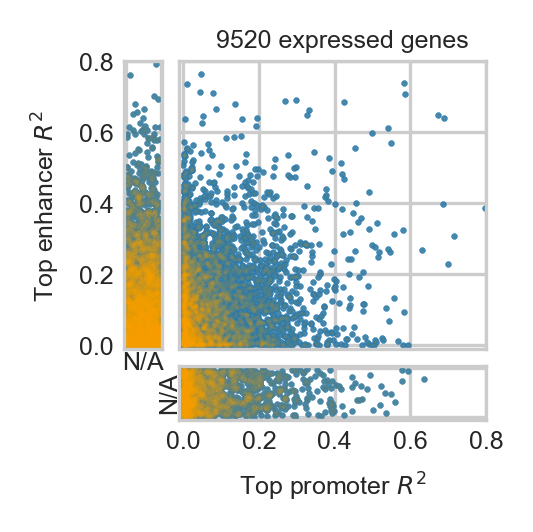

In [155]:
sns.set_style('whitegrid')
figsize = (45*mm, 45*mm)
fig,ax = plt.subplots(2,2,figsize=figsize, dpi=300,
                     gridspec_kw = {'height_ratios':[8,1.5], 'width_ratios':[1,8],
                                   'hspace':0.1, 'wspace':0.1})

sns.scatterplot(x='TSS R2', y='Enhancer R2', s=2, data=PE_both_df, ax=ax[0,1], 
                edgecolor=None, alpha=0.9)
sns.scatterplot(x='TSS R2', y='Enhancer R2', s=1, data=PE_both_df, ax=ax[0,1], 
                color='orange', edgecolor=None, alpha=0.1)
sns.scatterplot(x='TSS R2', y='Enhancer R2', s=2, data=PE_TSS_df, ax=ax[1,1],
               edgecolor=None, alpha=0.9)
sns.scatterplot(x='TSS R2', y='Enhancer R2', s=2, data=PE_TSS_df, ax=ax[1,1],
               color='orange', edgecolor=None, alpha=0.1)

sns.scatterplot(x='TSS R2', y='Enhancer R2', s=2, data=PE_Enh_df, ax=ax[0,0],
               edgecolor=None, alpha=0.9)
sns.scatterplot(x='TSS R2', y='Enhancer R2', s=2, data=PE_Enh_df, ax=ax[0,0],
               color='orange', edgecolor=None, alpha=0.1)

ax[0,1].set_xlim(-0.01,0.8)
ax[0,1].set_ylim(-0.01,0.8)

ax[1,1].set_xlim(-0.01,0.8)
ax[0,0].set_ylim(-0.01,0.8)

ax[1,1].set_xlabel('Top promoter $R^2$')
ax[0,0].set_ylabel('Top enhancer $R^2$')
ax[1,1].tick_params(axis='both', pad=-1)
ax[0,0].tick_params(axis='both', pad=-1)

xt = [0,0.2,0.4,0.6,0.8]
yt = xt
ax[1,1].set_xticks(xt)
ax[0,1].set_xticks(xt)
ax[0,0].set_yticks(yt)
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[1,1].set_yticklabels([])
ax[1,1].set_ylabel('N/A', labelpad=-3)
ax[0,0].set_xlabel('N/A', labelpad=-2)
ax[1,0].set_axis_off()
plt.suptitle('{} expressed genes'.format(len(PE_df)), x=0.65)
set_size(fig, figsize)
plt.savefig("Panels/TSSvsEnhancers_R2.pdf", bbox_inches='tight')
plt.show()

We can hunt for *repressor* peaks by looking for very negative R values as below.

In [156]:
for gene in PCR_ans.keys():
    PCR_df = PCR_ans[gene]
    int_cols = [col for col in PCR_df.columns if col[:5] == 'Inter']
    R_vals = PCR_df.loc[gene+'_R', int_cols]
    if R_vals.min() < -0.8:
        display(PCR_df)

Interval_7914 Interval_7913 Interval_7915  Eigenpeak 0  \
PeakID                                                                  
Interval_7915            0.0           0.0           1.0     0.668010   
Interval_7914            1.0           0.0           0.0     0.589642   
Interval_7913            0.0           1.0           0.0    -0.453965   
PTPLA_R             0.414438     -0.368511     -0.824421    -0.248589   
PTPLA_Rsq           0.171759        0.1358      0.679671     0.061796   
PTPLA_promoter         False          True         False          NaN   

                Eigenpeak 1  Eigenpeak 2  
PeakID                                    
Interval_7915      0.091402     0.738518  
Interval_7914      0.540411    -0.600232  
Interval_7913      0.836422     0.307106  
PTPLA_R           -0.150364    -0.777197  
PTPLA_Rsq          0.022609     0.604035  
PTPLA_promoter          NaN          NaN

Interval_9298 Interval_9295 Interval_9299 Interval_9294  \
PeakID                                                                    
Interval_9299             0.0           0.0           1.0           0.0   
Interval_9294             0.0           0.0           0.0           1.0   
Interval_9298             1.0           0.0           0.0           0.0   
CAMK2G_R            -0.326675      0.164377     -0.831283     -0.545174   
CAMK2G_Rsq           0.106717       0.02702      0.691031      0.297215   
CAMK2G_promoter         False         False         False          True   

                 Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  
PeakID                                                  
Interval_9299      -0.727214    -0.074664    -0.682338  
Interval_9294       0.620359    -0.496967    -0.606778  
Interval_9298       0.293795     0.864552    -0.407719  
CAMK2G_R            0.338951     0.053391     0.758114  
CAMK2G_Rsq          0.114888     0.002851     0.574737  
CAMK2G_promoter          NaN          NaN          NaN

Interval_18478 Interval_18474 Interval_18476 Interval_18479  \
PeakID                                                                       
Interval_18475            0.0            0.0            0.0            0.0   
Interval_18478            1.0            0.0            0.0            0.0   
Interval_18476            0.0            0.0            1.0            0.0   
Interval_18479            0.0            0.0            0.0            1.0   
Interval_18474            0.0            1.0            0.0            0.0   
RHOF_R              -0.652424        0.27937      -0.386091      -0.382163   
RHOF_Rsq             0.425657       0.078048       0.149066       0.146048   
RHOF_promoter           False           True          False          False   

               Interval_18475  Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  \
PeakID                                                                 
Interval_18475            1.0    -0.644676    -0.190786     0.416929   
Interval_18478            0.0     0.398195    -0.654675    -0.307765   
Interval_18476            0.0     0.389744     0.414261     0.553541   
Interval_18479            0.0    -0.172282     0.582552    -0.638286   
Interval_18474            0.0    -0.494219    -0.154994    -0.132796   
RHOF_R               -0.84318     0.163681     0.246367    -0.173762   
RHOF_Rsq             0.710953     0.026791     0.060697     0.030193   
RHOF_promoter           False          NaN          NaN          NaN   

                Eigenpeak 3  Eigenpeak 4  
PeakID                                    
Interval_18475     0.279794    -0.543949  
Interval_18478    -0.134974    -0.547635  
Interval_18476    -0.446863    -0.412788  
Interval_18479     0.034701    -0.471529  
Interval_18474    -0.838217     0.107156  
RHOF_R            -0.195241     0.781166  
RHOF_Rsq           0.038119     0.610220  
RHOF_promoter           NaN          NaN

Interval_30034 Interval_30040 Interval_30035 Interval_30037  \
PeakID                                                                       
Interval_30040            0.0            1.0            0.0            0.0   
Interval_30035            0.0            0.0            1.0            0.0   
Interval_30037            0.0            0.0            0.0            1.0   
WIPF2_R             -0.109659      -0.800048       -0.53906      -0.440815   
WIPF2_Rsq            0.012025       0.640077       0.290585       0.194318   
WIPF2_promoter          False          False          False           True   

               Interval_30039  Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  
PeakID                                                                
Interval_30040            0.0    -0.783775    -0.192439    -0.590477  
Interval_30035            0.0     0.576831    -0.577898    -0.577322  
Interval_30037            0.0     0.230136     0.793096    -0.563947  
WIPF2_R             -0.121055     0.279514     0.143685     0.778097  
WIPF2_Rsq            0.014654     0.078128     0.020645     0.605435  
WIPF2_promoter          False          NaN          NaN          NaN

Interval_62672 Interval_62661 Interval_62671 Interval_62657  \
PeakID                                                                        
Interval_62680             0.0            0.0            0.0            0.0   
Interval_62671             0.0            0.0            1.0            0.0   
Interval_62668             0.0            0.0            0.0            0.0   
Interval_62679             0.0            0.0            0.0            0.0   
Interval_62678             0.0            0.0            0.0            0.0   
Interval_62666             0.0            0.0            0.0            0.0   
Interval_62669             0.0            0.0            0.0            0.0   
FAM65B_R              0.142548       0.075706       0.452142       -0.04674   
FAM65B_Rsq             0.02032       0.005731       0.204432       0.002185   
FAM65B_promoter          False           True          False          False   

                Interval_62673 Interval_62668 Interval_62667 Interval_62664  \
PeakID                                                                        
Interval_62680             0.0            0.0            0.0            0.0   
Interval_62671             0.0            0.0            0.0            0.0   
Interval_62668             0.0            1.0            0.0            0.0   
Interval_62679             0.0            0.0            0.0            0.0   
Interval_62678             0.0            0.0            0.0            0.0   
Interval_62666             0.0            0.0            0.0            0.0   
Interval_62669             0.0            0.0            0.0            0.0   
FAM65B_R             -0.102844       0.447132       0.208032      -0.077491   
FAM65B_Rsq            0.010577       0.199927       0.043277       0.006005   
FAM65B_promoter          False          False           True          False   

                Interval_62654 Interval_62669  ... Interval_62680  \
PeakID                                         ...                  
Interval_62680             0.0            0.0  ...            1.0   
Interval_62671             0.0            0.0  ...            0.0   
Interval_62668             0.0            0.0  ...            0.0   
Interval_62679             0.0            0.0  ...            0.0   
Interval_62678             0.0            0.0  ...            0.0   
Interval_62666             0.0            0.0  ...            0.0   
Interval_62669             0.0            1.0  ...            0.0   
FAM65B_R              0.182379       0.230485  ...      -0.844059   
FAM65B_Rsq            0.033262       0.053124  ...       0.712436   
FAM65B_promoter          False          False  ...          False   

                Interval_62678 Interval_62679 Eigenpeak 0  Eigenpeak 1  \
PeakID                                                                   
Interval_62680             0.0            0.0   -0.226816     0.650949   
Interval_62671             0.0            0.0    0.130908     0.392599   
Interval_62668             0.0            0.0   -0.680522    -0.163563   
Interval_62679             0.0            1.0    0.032509    -0.582858   
Interval_62678             1.0            0.0    0.190773     0.008348   
Interval_62666             0.0            0.0   -0.144613     0.229177   
Interval_62669             0.0            0.0    0.640268     0.055352   
FAM65B_R             -0.277194      -0.445607   -0.039366    -0.178486   
FAM65B_Rsq            0.076836       0.198566    0.001550     0.031857   
FAM65B_promoter          False          False         NaN          NaN   

                 Eigenpeak 2  Eigenpeak 3  Eigenpeak 4  Eigenpeak 5  \
PeakID                                                                
Interval_62680      0.235260     0.236512    -0.166436     0.501641   
Interval_62671      0.541728     0.274953     0.227692    -0.601244   
Interval_62668     -0.042579     0.448031     0.048425     0.122723   
Interval_62679      0.418711     0.452468    

Interval_69611 Interval_69613 Interval_69612 Interval_69614  \
PeakID                                                                        
Interval_69611             1.0            0.0            0.0            0.0   
Interval_69614             0.0            0.0            0.0            1.0   
Interval_69613             0.0            1.0            0.0            0.0   
PMS2P1_R             -0.807427      -0.266749      -0.204034        0.36336   
PMS2P1_Rsq            0.651938       0.071155        0.04163        0.13203   
PMS2P1_promoter          False          False          False          False   

                 Eigenpeak 0  Eigenpeak 1  Eigenpeak 2  
PeakID                                                  
Interval_69611      0.718879    -0.014654    -0.694981  
Interval_69614      0.547623     0.627741     0.553218  
Interval_69613     -0.428161     0.778284    -0.459295  
PMS2P1_R           -0.420666     0.033018     0.691210  
PMS2P1_Rsq          0.176960     0.001090     0.477772  
PMS2P1_promoter          NaN          NaN          NaN

## Panel:  Principal Component Regression -- summary.

We create a dataframe summarizing our PCR analysis, and make a plot of the peaks found.

In [157]:
PCR_summary = pd.DataFrame(index = PCR_ans.keys(), 
                           columns=['promoter_R_sq', 'num_eig'])

i = 0
for gene in PCR_ans.keys():
    i += 1
    if i%1000 == 0:
        print('{} genes processed.'.format(i))
    PCR_df = PCR_ans[gene]
    
    intcols = [col for col in PCR_df.columns if col[:5] == 'Inter']
    PCR_summary.loc[gene,'num_peaks'] = len(intcols)
    
    eigencols = [col for col in PCR_df.columns if col[:3] == 'Eig']
    promcols = (PCR_df.loc[gene+'_promoter'] == True)
    promcols = promcols[promcols].index
    #print(promcols)
    if len(promcols) > 0:
        #print(PCR_df.loc[gene+'_Rsq',promcols].max())
        PCR_summary.loc[gene, 'promoter_R_sq'] = PCR_df.loc[gene+'_Rsq',promcols].max()
    else:
        PCR_summary.loc[gene, 'promoter_R_sq'] = 0
    R2_int = PCR_df.loc[gene+'_Rsq',intcols]
    R2_cutoff = R2_geneback[gene]
    PCR_summary.loc[gene, 'num_sigpeaks'] = (R2_int > R2_cutoff).sum()
    if len(eigencols) > 0:
        R2_eig = PCR_df.loc[gene+'_Rsq',eigencols]
        num_eig = (R2_eig > R2_cutoff).sum()
        PCR_summary.loc[gene,'num_eig'] = num_eig
        eig_R_sq = R2_eig.sort_values(ascending=False)
        for j in range(len(eigencols)):
            PCR_summary.loc[gene, 'eigen{}_R_sq'.format(j)] = eig_R_sq[j]
    else:
        PCR_summary.loc[gene,'num_eig'] = 0
    #print(PCR_summary.loc[gene])

1000 genes processed.
2000 genes processed.
3000 genes processed.
4000 genes processed.
5000 genes processed.
6000 genes processed.
7000 genes processed.
8000 genes processed.
9000 genes processed.


In [158]:
PCR_summary

promoter_R_sq num_eig  num_peaks  num_sigpeaks  eigen0_R_sq  \
MTND2P28                  0       0        0.0           0.0          NaN   
hsa-mir-6723              0       0        0.0           0.0          NaN   
MTATP6P1                  0       0        0.0           0.0          NaN   
RP11-206L10.9      0.011958       0        1.0           0.0          NaN   
LINC01128           0.15224       0        2.0           0.0      0.15224   
...                     ...     ...        ...           ...          ...   
TMLHE-1                   0       0        0.0           0.0          NaN   
VAMP7              0.000048       0        1.0           0.0          NaN   
SRIP3                     0       0        0.0           0.0          NaN   
AC010970.2                0       0        0.0           0.0          NaN   
RNA5-8SP6                 0       0        0.0           0.0          NaN   

               eigen1_R_sq  eigen2_R_sq  eigen3_R_sq  eigen4_R_sq  \
MTND2P28               NaN          NaN          NaN          NaN   
hsa-mir-6723           NaN          NaN          NaN          NaN   
MTATP6P1               NaN          NaN          NaN          NaN   
RP11-206L10.9          NaN          NaN          NaN          NaN   
LINC01128              NaN          NaN          NaN          NaN   
...                    ...          ...          ...          ...   
TMLHE-1                NaN          NaN          NaN          NaN   
VAMP7                  NaN          NaN          NaN          NaN   
SRIP3                  NaN          NaN          NaN          NaN   
AC010970.2             NaN          NaN          NaN          NaN   
RNA5-8SP6              NaN          NaN          NaN          NaN   

               eigen5_R_sq  eigen6_R_sq  eigen7_R_sq  eigen8_R_sq  \
MTND2P28               NaN          NaN          NaN          NaN   
hsa-mir-6723           NaN          NaN          NaN          NaN   
MTATP6P1               NaN          NaN          NaN          NaN   
RP11-206L10.9          NaN          NaN          NaN          NaN   
LINC01128              NaN          NaN          NaN          NaN   
...                    ...          ...          ...          ...   
TMLHE-1                NaN          NaN          NaN          NaN   
VAMP7                  NaN          NaN          NaN          NaN   
SRIP3                  NaN          NaN          NaN          NaN   
AC010970.2             NaN          NaN          NaN          NaN   
RNA5-8SP6              NaN          NaN          NaN          NaN   

               eigen9_R_sq  eigen10_R_sq  eigen11_R_sq  
MTND2P28               NaN           NaN           NaN  
hsa-mir-6723           NaN           NaN           NaN  
MTATP6P1               NaN           NaN           NaN  
RP11-206L10.9          NaN           NaN           NaN  
LINC01128              NaN           NaN           NaN  
...                    ...           ...           ...  
TMLHE-1                NaN           NaN           NaN  
VAMP7                  NaN           NaN           NaN  
SRIP3                  NaN           NaN           NaN  
AC010970.2             NaN           NaN           NaN  
RNA5-8SP6              NaN           NaN           NaN  

[9520 rows x 16 columns]

In [159]:
genes_with_peaks = PCR_summary[PCR_summary.num_sigpeaks > 0].index
len(genes_with_peaks)

1430

In [160]:
(adata.var.loc[genes_with_peaks].F_pval < 0.01).sum()

205

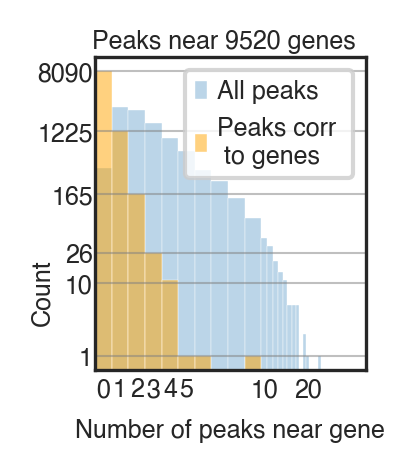

In [161]:
plot_genes = adata.var.index
plot_genes = [gene for gene in plot_genes if gene in PCR_summary.index]

sns.set_style('white')
figsize=(35*mm, 40*mm)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()


gwp_count = (PCR_summary.num_sigpeaks > 0).sum().astype(int)
p_count = (PCR_summary.num_sigpeaks).sum().astype(int)

bins=np.arange(0,75,1)
sns.histplot(PCR_summary.loc[plot_genes,'num_peaks'], bins=bins, ax=ax, alpha=0.3, label='All peaks')
sns.histplot(PCR_summary.loc[plot_genes,'num_sigpeaks'], bins=bins, ax=ax, color='orange', 
             label='Peaks corr \n to genes', alpha=0.5) #, \
  #           label='Peaks correlated to gene \n ({} peaks corr. to {} genes total.)'.format(p_count, gwp_count))
#sns.histplot(PCR_summary.loc[plot_genes,'num_eig'], bins=bins, ax=ax, color='darkgreen', label='Eigenpeaks correlated to gene')
ax.legend()
plt.yscale('log')
plt.xscale('symlog',linthresh=10.0)
xt = [0,1,2,3,4,5,10,20]
ax.set_xticks([x + 0.5 for x in xt])
ax.set_xticklabels([0,1,2,3,4,5,10,20], y=0.07)

y0 = (PCR_summary.num_sigpeaks == 0).sum()
y1 = (PCR_summary.num_sigpeaks == 1).sum()
y2 = (PCR_summary.num_sigpeaks == 2).sum()
y3 = (PCR_summary.num_sigpeaks == 3).sum()

ax.set_yticks([1,10,y0,y1,y2,y3])
ax.set_yticklabels(['1','10',y0,y1,y2,y3], x=0.03)

for y in [1,10,y0,y1,y2,y3]:
    ax.axhline(y,linewidth=0.5, color='gray', alpha=0.5)
    
ax.set_xlim(0,50)
ax.set_xlabel('Number of peaks near gene')
ax.set_ylabel('Count', labelpad=-4, y=0.25)
ax.tick_params(axis='y', pad=-1)
plt.suptitle('Peaks near {} genes'.format(len(PCR_summary.loc[plot_genes])),x=0.55)

set_size(fig, figsize)
plt.savefig("Panels/PCR_Peaks.pdf", bbox_inches='tight')
plt.show()

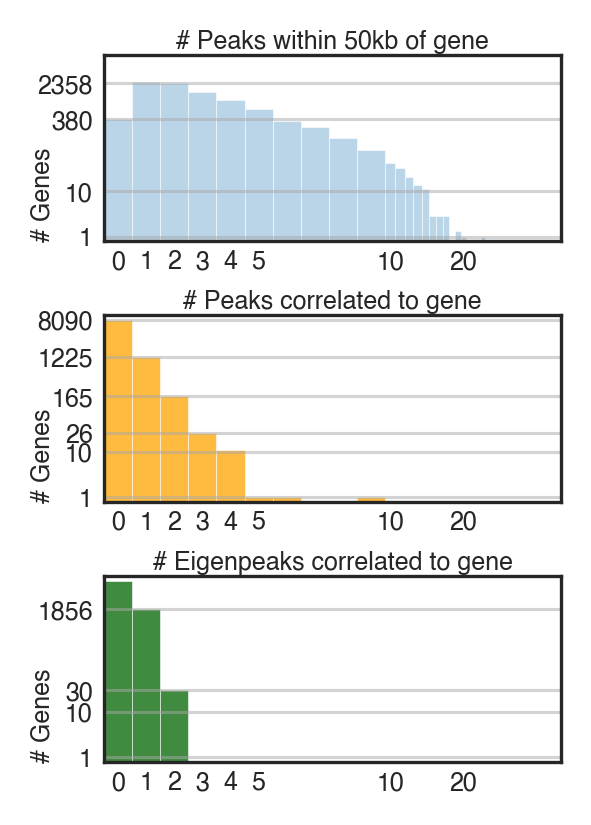

In [162]:
plot_genes = adata.var.index
plot_genes = [gene for gene in plot_genes if gene in PCR_summary.index]

sns.set_style('white')
figsize=(50*mm, 70*mm)
fig, ax = plt.subplots(3,1,figsize=figsize, dpi=300, sharey=False, sharex=False,
                      gridspec_kw={'hspace':0.4})
setfontsize()


gwp_count = (PCR_summary.num_sigpeaks > 0).sum().astype(int)
p_count = (PCR_summary.num_sigpeaks).sum().astype(int)

bins=np.arange(0,75,1)

sns.histplot(PCR_summary.loc[plot_genes,'num_peaks'], bins=bins, alpha=0.3, label='All peaks', ax=ax[0])

sns.histplot(PCR_summary.loc[plot_genes,'num_sigpeaks'], bins=bins, color='orange', 
             label='Peaks corr \n to genes', ax=ax[1]) 
  #           label='Peaks correlated to gene \n ({} peaks corr. to {} genes total.)'.format(p_count, gwp_count))
sns.histplot(PCR_summary.loc[plot_genes,'num_eig'], bins=bins, color='darkgreen', 
             label='Eigenpeaks corr to genes', ax=ax[2])

#ax.legend()
plt.yscale('log')


xt = [0,1,2,3,4,5,10,20]

yt = {}
yt[0] = [1,10] + [(PCR_summary.num_peaks == j).sum() for j in [0,2]]
yt[1] = [1,10] + [(PCR_summary.num_sigpeaks == j).sum() for j in [0,1,2,3]]
yt[2] = [1,10] + [(PCR_summary.num_eig == j).sum() for j in [1,2]]


#ax[0].set_yticks([1,10,y0,y1,y2,y3])
#ax[0].set_yticklabels(['1','10',y0,y1,y2,y3], x=0.03)

#for y in [1,10,y0,y1,y2,y3]:
#    ax[0].axhline(y,linewidth=0.5, color='gray', alpha=0.5)
    
ax[0].set_title('# Peaks within 50kb of gene', y=0.9)
ax[1].set_title('# Peaks correlated to gene', y=0.9)
ax[2].set_title('# Eigenpeaks correlated to gene', y=0.9)

for j in range(3):
    ax[j].tick_params(axis='y', pad=-0.75)
    ax[j].tick_params(axis='x', pad=0)
    ax[j].set_ylabel('# Genes', labelpad=-4, y=0.25)

    ax[j].set_xlim(0,50)
    ax[j].set_ylim(0.1,10000)
    ax[j].set_xscale('symlog',linthresh=10.0)
    ax[j].set_yscale('symlog', linthresh=10.0)
    ax[j].set_xticks([x + 0.5 for x in xt])
    ax[j].set_xticklabels([0,1,2,3,4,5,10,20], y=0.03)
    ax[j].set_xlabel('')
    for y in yt[j]:
        ax[j].axhline(y,linewidth=0.75, alpha=0.5, color='darkgray')
    ax[j].set_yticks(yt[j])
    ax[j].set_yticklabels([str(y) for y in yt[j]])

# ax[2].set_xlabel('# Peaks')
#plt.suptitle('Peaks near {} genes'.format(len(PCR_summary.loc[plot_genes])),x=0.55)

set_size(fig, figsize)
plt.savefig("Panels/PCR_Analysis_Peaks.pdf", bbox_inches='tight')
plt.show()

In [163]:
PCR_summary.head()

promoter_R_sq num_eig  num_peaks  num_sigpeaks  eigen0_R_sq  \
MTND2P28                  0       0        0.0           0.0          NaN   
hsa-mir-6723              0       0        0.0           0.0          NaN   
MTATP6P1                  0       0        0.0           0.0          NaN   
RP11-206L10.9      0.011958       0        1.0           0.0          NaN   
LINC01128           0.15224       0        2.0           0.0      0.15224   

               eigen1_R_sq  eigen2_R_sq  eigen3_R_sq  eigen4_R_sq  \
MTND2P28               NaN          NaN          NaN          NaN   
hsa-mir-6723           NaN          NaN          NaN          NaN   
MTATP6P1               NaN          NaN          NaN          NaN   
RP11-206L10.9          NaN          NaN          NaN          NaN   
LINC01128              NaN          NaN          NaN          NaN   

               eigen5_R_sq  eigen6_R_sq  eigen7_R_sq  eigen8_R_sq  \
MTND2P28               NaN          NaN          NaN          NaN   
hsa-mir-6723           NaN          NaN          NaN          NaN   
MTATP6P1               NaN          NaN          NaN          NaN   
RP11-206L10.9          NaN          NaN          NaN          NaN   
LINC01128              NaN          NaN          NaN          NaN   

               eigen9_R_sq  eigen10_R_sq  eigen11_R_sq  
MTND2P28               NaN           NaN           NaN  
hsa-mir-6723           NaN           NaN           NaN  
MTATP6P1               NaN           NaN           NaN  
RP11-206L10.9          NaN           NaN           NaN  
LINC01128              NaN           NaN           NaN

In [164]:
PCR_summary.to_csv('PCR_summary.csv')

# Multiomics plots

In [165]:
pg_clones = list(peak_clonal.index)

In [166]:
prot_clonal = prot_data.to_df().groupby(prot_data.obs.Clone_ID).mean()
prot_clonal = prot_clonal.loc[pg_clones]
prot_clonal

var_names    CD57 FITC  A2 YF DEXTRA APC        CD8 A7  CD62L BV670  \
Clone_ID                                                              
P1_A03      902.903320      27506.250000   8444.175781  -208.290939   
P1_A05      803.705139      19328.957031   7142.438965   -32.177135   
P1_A08      576.234619      19552.335938   7188.782227   -37.302555   
P1_A12      413.486084      15468.637695   4991.385742   -77.271622   
P1_B10       42.948910      14563.261719   8508.237305   -55.116821   
P1_C11     1643.779175      23151.318359  10985.375000   -18.524429   
P1_D09     1441.065430      17640.460938   6325.950684   567.863037   
P1_F10      203.625443      16097.100586   7561.971680   -58.249008   
P1_H01     1690.622925      14977.458984   6277.771973     4.625610   
P1_H10     1068.334717      26251.025391   8835.803711    71.106735   
P2_A04     1749.253052      22271.263672   7926.547363  -162.400391   
P2_B11      905.793823      22156.519531   8163.387695  -191.425201   
P2_G01     2321.262451      29470.908203   9826.098633  -157.706314   
P2_G09      638.899292      22724.232422   8776.172852   -93.520004   
P2_H04      247.371338      35838.644531   9158.025391  -105.397858   
P2_H05     3864.262207      17620.658203   9249.083984    34.258526   

var_names    PD1 BV711  CD27 BV786      CD94 PE      CD3 PC5  
Clone_ID                                                      
P1_A03     1376.424927  -97.778107  2359.556641  2292.757568  
P1_A05      903.623413  -68.900253   393.199371  2615.705322  
P1_A08     1303.275879  -41.017300  7642.252441  2269.702393  
P1_A12      994.417175  -49.785648   279.779022  1625.113037  
P1_B10     2128.482666   22.142307  1226.074707  2014.063965  
P1_C11     1235.683594  -62.457111  2831.641602  2888.821533  
P1_D09     2455.682129  -83.398872    60.759659  2319.213623  
P1_F10     1241.386597  -57.741810  1476.108765  1676.395996  
P1_H01     1099.460083  -65.979813  1879.674072  1961.431641  
P1_H10      555.246704  -97.844833   154.407333  2497.243896  
P2_A04      741.104126  -83.873314    62.666954  2209.680908  
P2_B11      828.401001 -106.923340  2057.955078  2286.909668  
P2_G01     1150.331055  -97.822929   288.096466  2334.123291  
P2_G09     1495.582153 -101.572876  7028.983398  2695.924805  
P2_H04      810.228943   25.330467   145.109039  2907.352783  
P2_H05      702.913269  -84.052254    63.130737  1906.631836

In [167]:
gene_clonal

gene_name  MTND2P28  hsa-mir-6723  MTATP6P1  RP11-206L10.9  LINC01128  \
Clone_ID                                                                
P1_A03     3.230169      2.079046  5.749669       0.000000   0.000000   
P1_A05     2.709148      1.453811  5.383322       0.000000   0.000000   
P1_A08     3.050509      1.614846  5.801980       0.000000   0.000000   
P1_A12     3.035853      1.859284  5.475892       0.887302   0.958630   
P1_B10     3.112417      2.253648  5.691962       0.000000   0.902409   
P1_C11     2.745569      1.978039  5.837260       0.000000   0.000000   
P1_D09     2.575861      1.505550  5.739470       0.948192   1.076902   
P1_F10     2.922449      1.693547  5.865429       0.000000   0.000000   
P1_H01     3.106876      1.949256  5.824675       0.000000   0.000000   
P1_H10     2.250069      1.485239  5.613591       0.000000   0.000000   
P2_A04     3.237091      1.334472  5.566094       0.957045   0.000000   
P2_B11     3.307103      2.163680  5.705452       1.188340   0.000000   
P2_G01     3.005000      0.545083  4.770329       0.000000   0.000000   
P2_G09     2.708898      1.455621  5.396387       0.000000   1.132141   
P2_H04     2.315471      1.711872  5.294865       0.351379   0.000000   
P2_H05     2.047147      0.479275  4.363872       0.000000   0.000000   

gene_name     NOC2L     ISG15  RP11-465B22.3  TNFRSF18   TNFRSF4  ...  \
Clone_ID                                                          ...   
P1_A03     2.308283  7.334683       0.000000  3.254865  1.157134  ...   
P1_A05     2.970573  6.024615       0.000000  4.569802  1.087413  ...   
P1_A08     0.000000  7.358630       0.000000  5.370294  1.082879  ...   
P1_A12     2.351700  6.635680       0.000000  5.170679  0.412726  ...   
P1_B10     2.168520  6.953883       1.071905  5.509768  0.000000  ...   
P1_C11     2.254454  4.855477       0.000000  3.198215  0.000000  ...   
P1_D09     1.631425  5.360824       3.277528  4.126095  2.221344  ...   
P1_F10     2.471754  6.654633       1.307794  3.869681  1.221896  ...   
P1_H01     2.190555  6.236783       0.000000  3.081303  0.337937  ...   
P1_H10     3.127002  5.592022       0.000000  4.690275  0.942922  ...   
P2_A04     1.419956  5.599187       0.000000  3.480796  0.000000  ...   
P2_B11     2.022410  5.456667       0.000000  1.635330  1.342189  ...   
P2_G01     1.528105  8.190660       0.000000  0.885717  0.000000  ...   
P2_G09     0.000000  6.837132       0.000000  4.499185  0.000000  ...   
P2_H04     0.000000  5.778849       0.000000  3.573749  0.000000  ...   
P2_H05     0.000000  5.500018       0.000000  0.172438  0.147221  ...   

gene_name      F8-1  FUNDC2-1   BRCC3-1    VBP1-1  RAB39B-1   TMLHE-1  \
Clone_ID                                                                
P1_A03     0.000000  2.843147  2.523289  3.442465  0.000000  0.000000   
P1_A05     0.000000  3.934277  3.737265  4.640422  0.000000  1.077093   
P1_A08     1.002046  4.011677  2.558638  4.284044  0.000000  2.961611   
P1_A12     0.224331  4.294168  2.767888  4.635580  0.864102  3.820885   
P1_B10     0.000000  2.429938  0.000000  2.663473  0.772005  3.728553   
P1_C11     0.000000  2.998382  1.462838  3.882571  0.891281  1.206362   
P1_D09     0.548206  3.907003  3.097841  4.354332  0.685584  1.847692   
P1_F10     1.232553  1.618218  3.844646  4.177619  0.901349  0.000000   
P1_H01     0.000000  2.998327  2.415796  4.209680  0.000000  1.493295   
P1_H10     0.000000  2.596592  1.918516  4.173988  0.000000  0.761494   
P2_A04     0.000000  3.139159  0.000000  2.827251  0.000000  2.954389   
P2_B11     0.000000  3.682788  2.343420  4.453341  0.000000  4.217452   
P2_G01     0.000000  1.196341  1.552464  0.000000  0.000000  1.926167   
P2_G09     0.000000  3.030712  1.711892  4.846723  2.136081  0.000000   
P2_H04     0.000000  2.841082  0.465016  2.514537  1.168372  0.000000   
P2_H05     0.000000  4.360162  0.000000  0.000000  1.405290  0.000000   

gene_name     VAMP7     SRIP3  AC010970.2  RNA5-8SP6  


In [168]:
peak_clonal

PeakID    Interval_51938  Interval_13433  Interval_27763  Interval_53540  \
Clone_ID                                                                   
P1_A03          2.529633        5.617923        3.278499        3.233557   
P1_A05          1.972389        5.437860        3.517708        2.451669   
P1_A08          2.287843        5.560565        3.709698        3.762476   
P1_A12          2.426444        5.683740        3.585825        3.326052   
P1_B10          1.853198        5.436592        3.504991        3.114438   
P1_C11          2.591159        5.644123        3.638525        3.083403   
P1_D09          3.449496        5.493403        3.700081        3.607240   
P1_F10          2.824024        5.619921        3.443976        3.507894   
P1_H01          1.892109        5.518234        3.856328        3.475958   
P1_H10          2.869512        5.432869        3.799819        1.578473   
P2_A04          2.967492        5.697934        3.824545        0.732249   
P2_B11          0.000000        5.558466        4.033247        3.964330   
P2_G01          2.775430        5.629741        3.436920        2.986031   
P2_G09          2.128885        5.444118        3.869145        2.991982   
P2_H04          1.969373        5.705107        3.431467        1.571595   
P2_H05          2.000840        5.533689        3.602494        0.553023   

PeakID    Interval_4280  Interval_6501  Interval_68580  Interval_72287  \
Clone_ID                                                                 
P1_A03         4.882648       4.752263        5.469793        5.140104   
P1_A05         5.108484       4.493093        5.533124        5.205187   
P1_A08         5.194549       4.519068        5.543390        5.414121   
P1_A12         5.100070       4.740612        5.524294        5.149168   
P1_B10         5.243369       4.985421        5.780162        5.169667   
P1_C11         5.247215       4.287120        5.610814        5.226705   
P1_D09         5.154146       4.445949        5.408775        5.033196   
P1_F10         5.158548       4.699069        5.427788        5.309041   
P1_H01         5.182631       4.508285        5.476674        5.253664   
P1_H10         5.147631       4.061644        5.429313        5.223673   
P2_A04         5.182442       4.576645        5.627039        5.335967   
P2_B11         5.195662       4.471122        5.540189        5.331752   
P2_G01         5.123996       4.585413        5.571364        5.132912   
P2_G09         5.031900       4.856232        5.418911        5.213133   
P2_H04         5.082010       5.068582        5.355668        5.396853   
P2_H05         5.061416       4.439970        5.508592        5.290628   

PeakID    Interval_7590  Interval_38287  ...  Interval_78898  Interval_2270  \
Clone_ID                                 ...                                  
P1_A03         4.547335        4.800413  ...        2.701310       5.834497   
P1_A05         4.681770        4.768009  ...        1.972389       5.811915   
P1_A08         5.077458        4.879703  ...        2.658895       5.847285   
P1_A12         4.758474        4.859426  ...        2.862755       5.690734   
P1_B10         4.403090        4.662625  ...        1.853198       5.919521   
P1_C11         4.618135        4.895682  ...        2.591159       5.834918   
P1_D09         3.900287        5.033196  ...        3.031354       5.705334   
P1_F10         4.800375        4.817234  ...        1.974084       5.943502   
P1_H01         4.320146        4.823890  ...        2.577711       5.941096   
P1_H10         4.303802        4.909767  ...        2.593704       5.857391   
P2_A04         4.433029        4.902121  ...        3.553975       5.967187   
P2_B11         4.523455        4.843583  ...        1.892865       5.867593   
P2_G01         4.754437        4.841271  ...        2.907030       5.825328   
P2_G09         4.755282        4.823701  ...        2.650796       5.956059   
P2_H04         4.630580        4.7

In [169]:
from matplotlib.ticker import FormatStrFormatter

def pgplot(gene, protein = None, eigen = False, order='eig', cutoff=0.2, window=50000, file_annot = '',
          hide_legend=False, side_legend=False, cust_size = None, plain=False):
    sns.set_style('white')
    setfontsize()
    if protein or eigen:
        num_rows = 3
        hr = [2,1,1]
    else:
        num_rows = 2
        hr=[2,1]

    
    # Peaks and eigenpeaks
    PCR_df = PCR_analysis(gene, window=window)
    peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
    peaklist = [peak for peak in peaklist if PCR_df.loc[gene+'_Rsq',peak] > cutoff]
    
    if plain:
        figsize=(35*mm,12*mm*num_rows + 5*mm )
    else:
        figsize=(35*mm,12*mm*num_rows + 10*mm + (2.5 * (len(peaklist)//3) * mm))
    if cust_size:
        figsize = cust_size
        
    fig, ax = plt.subplots(num_rows,1,figsize=figsize, dpi=300, sharex=True,
                           gridspec_kw = {'hspace':0.05, 'height_ratios':hr}) 
    
               
    clone_order = list(gene_clonal[gene].sort_values().index)
    
    
    pplot_df = peak_clonal[peaklist].copy()
    
    eig_cols = [col for col in PCR_df.columns if col[:3] == 'Eig']
    eig_weights = PCR_df.loc[peaklist, eig_cols]
    realpeaks = pplot_df
    normpeaks = (realpeaks - realpeaks.mean()) / realpeaks.std()
    eig_df = normpeaks.dot(eig_weights)
    eigR2 = PCR_df.loc[gene+'_Rsq',eig_cols].astype(float)
    eig_df = eig_df * (2 * (eig_df.loc[clone_order[-1]] > 0) - 1) #Flip eigenpeaks to match gene.
    ty = np.min(eig_df.values)
    
    top_eig = eigR2.idxmax()
    
    
    # Normalize peak heights between 0 and 1.
    pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
    pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()    
    
    if order=='eig':
        clone_order = list(eig_df[top_eig].sort_values().index)
        
    pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)    
    eig_df['Clone'] = pd.Categorical(eig_df.index, categories = clone_order, ordered = True)
    
     
    gplot_df = pd.DataFrame(columns=[gene,'Clone'])
    gplot_df[gene] = adata.to_df()[gene]
    gplot_df['Clone'] = pd.Categorical(adata.obs.Clone_ID, categories = clone_order, ordered = True)
    gplot_df = gplot_df[gplot_df.Clone.isin(pg_clones)]
        
    for clone in clone_order:
        for row in range(num_rows):
            ax[row].axvline(clone,linestyle=':',color='gray',linewidth=0.5, alpha=0.5, zorder=-5)
    
    # GENE EXPRESSION PLOT
    
    sns.scatterplot(x='Clone', y=gene, color='darkgray', edgecolor='k', s=10, data=gplot_df, ax=ax[0], legend=False)
    gene_ticks = [int(gplot_df[gene].min()), int(gplot_df[gene].max())]
    if gene_ticks[1] == gene_ticks[0]:
        gene_ticks[1] = gene_ticks[0]+1
    ax[0].set_yticks(gene_ticks)
    ax[0].set_yticklabels(gene_ticks, x=0.03)
    #ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[0].set_ylabel(gene)
    ax[0].yaxis.set_label_position("right")
    ax[0].tick_params(axis='y', pad=-0.6)
    
    # ATAC PLOT
    
    no_peaks = 0
    for peak in peaklist:
        peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
        if peak_Rsq > 0.05:
            peak_label = '${:1.2f}$'.format(peak_Rsq)
            no_peaks += 1
        else:
            peak_label = None
        sns.lineplot(x='Clone', y=peak, data=pplot_df, ax=ax[-1], linewidth=0.7,
                    label=peak_label, alpha=min(1,peak_Rsq*1.5), zorder=np.round(peak_Rsq*100).astype(int)) #, label=peak, legend=False)
    
    ax[-1].set_ylabel('Peak')
    ax[-1].yaxis.set_label_position("right")
    ax[-1].set_yticks([])
    ax[-1].set_xlabel('')
    
    # PROTEIN PLOT
    if protein:
        proplot_df = pd.DataFrame(prot_clonal[protein], columns=[protein])
        proplot_df[protein] = proplot_df[protein] - proplot_df[protein].min()
        proplot_df[protein] = proplot_df[protein] / proplot_df[protein].max()
        proplot_df['Clone'] = proplot_df.index
        sns.lineplot(x='Clone', y=protein, data=proplot_df, ax=ax[1], linewidth=0.7)
        ax[1].text(1,0.5,protein, ha='left')
        ax[1].set_ylabel('Prot')
        ax[1].yaxis.set_label_position("right")
        ax[1].set_yticks([])
        ax[1].set_xlabel('')
        ax[1].spines['top'].set_color('lightgray')
        ax[1].spines['bottom'].set_color('lightgray')
    
    # Eigenpeak plot
    if eigen:
        no_peaks = 0
        for peak in eig_cols:
            peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
            if peak_Rsq > 0.05:
                peak_label = '${:1.2f}$'.format(peak_Rsq)
                no_peaks += 1
            else:
                peak_label = None
            sns.lineplot(x='Clone', y=peak, data=eig_df, ax=ax[1], linewidth=0.7,
                        alpha=min(1,peak_Rsq*1.5), 
                         color='k') #, zorder=np.round(peak_Rsq*100).astype(int))
        
        ax[1].text(9,ty,'Eigenpeaks', ha='center', va='bottom')
        ax[1].set_ylabel('')
        #ax[1].yaxis.set_label_position("right")
        ax[1].set_yticks([])
        ax[1].set_xlabel('')
        ax[1].spines['top'].set_color('lightgray')
        ax[1].spines['bottom'].set_color('lightgray')
        ax[1].axhline(0, c='red', alpha=0.25, linewidth=0.5)
    
    # General formatting.
    ax[0].spines['bottom'].set_color('lightgray')
    ax[-1].spines['top'].set_color('lightgray')
    
    plt.xticks(rotation=45)
    plt.xticks([])
    
    if len(peaklist) == 1:
        peakword = 'peak'
    else:
        peakword = 'peaks'
    if protein:
        title = '{}, {}, and {} {}'.format(gene, protein, len(peaklist), peakword)
    else:
        title = '{} and {} {}'.format(gene, len(peaklist), peakword)
    
    if plain:
        plt.suptitle('')
    else:
        plt.suptitle(title, y=1.02, x=0.6)
    
    # Plot legend
    if no_peaks <= 3:
        ncol = no_peaks
    else:
        ncol = 3
    if side_legend:
        lgnd = plt.legend(bbox_to_anchor=(2.0,3.0), title = 'Peak/Gene $R^2$',  
                          ncol=2, frameon=False)
        #lgnd.get_frame().set_linewidth(0.0)
        plt.suptitle('')
        
    else:
        lgnd = plt.legend(bbox_to_anchor=(0.5, 0.05), title = 'Peak/Gene $R^2$',  
                          loc=9, ncol=ncol, framealpha=0.5)
        lgnd.get_frame().set_linewidth(0.5)
    if hide_legend:
        lgnd.set_visible(False)
        plt.suptitle('')
        ax[0].set_yticks([])
     
        
    if plain:
        lgnd.set_visible(False)
        plt.suptitle('')
    
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    ax[-1].set_ylabel('')
    
    # Save and show figure.
    set_size(fig, figsize)
    file_prefix = 'Panels/Multiplots/'
    file_name = '{}_peaks_gene'.format(gene)
    if eigen:
        file_name += '_eigens'
    if protein:
        file_name += '_prots'
    if plain:
        file_name += '_plain'
    file_name += file_annot
    file_suffix = '.pdf'
    plt.savefig(file_prefix + file_name + file_suffix, bbox_inches='tight')
    plt.show()

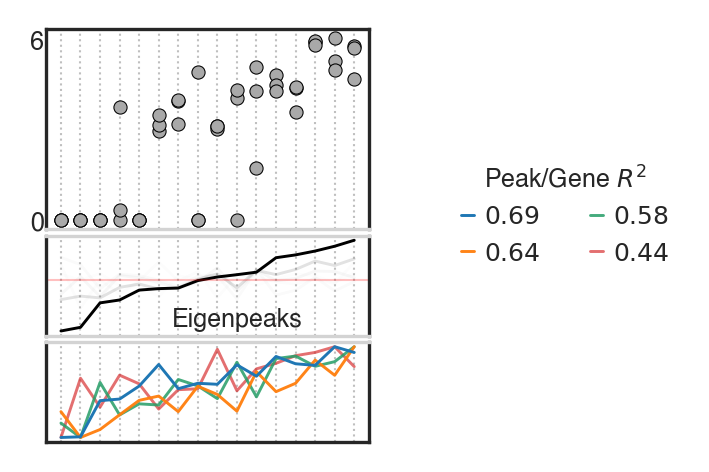

In [185]:
pgplot('KLRD1', eigen=True, cutoff=R2_geneback['KLRD1'], side_legend=True, cust_size=(60*mm, 40*mm))

In [186]:
pg_corrs['12'].loc[peaks_near('KLRD1', window=50000),'KLRD1']**2

PeakID
Interval_15297    0.688533
Interval_15294    0.091818
Interval_15296    0.639647
Interval_15292    0.175776
Interval_15285    0.444245
Interval_15295    0.576233
Name: KLRD1, dtype: float32

In [252]:
PCR_analysis('KLRD1')

Interval_15297 Interval_15294 Interval_15296 Interval_15292  \
PeakID                                                                       
Interval_15297            1.0            0.0            0.0            0.0   
Interval_15296            0.0            0.0            1.0            0.0   
Interval_15295            0.0            0.0            0.0            0.0   
Interval_15285            0.0            0.0            0.0            0.0   
Interval_15292            0.0            0.0            0.0            1.0   
Interval_15294            0.0            1.0            0.0            0.0   
KLRD1_R              0.829779       0.303016       0.799779       0.419257   
KLRD1_Rsq            0.688533       0.091818       0.639647       0.175776   
KLRD1_promoter           True          False          False          False   

               Interval_15285 Interval_15295  Eigenpeak 0  Eigenpeak 1  \
PeakID                                                                   
Interval_15297            0.0            0.0    -0.661381    -0.480199   
Interval_15296            0.0            0.0     0.089398     0.552882   
Interval_15295            0.0            1.0     0.627780    -0.436696   
Interval_15285            1.0            0.0     0.047441    -0.016938   
Interval_15292            0.0            0.0    -0.258857     0.506085   
Interval_15294            0.0            0.0     0.302023     0.128914   
KLRD1_R              0.666517         0.7591     0.076151    -0.118458   
KLRD1_Rsq            0.444245       0.576233     0.005799     0.014032   
KLRD1_promoter          False           True          NaN          NaN   

                Eigenpeak 2  Eigenpeak 3  Eigenpeak 4  Eigenpeak 5  
PeakID                                                              
Interval_15297    -0.248716    -0.119046     0.053662    -0.503063  
Interval_15296    -0.495116    -0.216596    -0.483356    -0.400803  
Interval_15295    -0.085952     0.418015    -0.089260    -0.474445  
Interval_15285     0.772231    -0.411033    -0.315299    -0.364363  
Interval_15292     0.281845     0.595547     0.299708    -0.391067  
Interval_15294    -0.099175    -0.490462     0.752517    -0.274759  
KLRD1_R           -0.091798    -0.141703    -0.276551    -0.840801  
KLRD1_Rsq          0.008427     0.020080     0.076481     0.706946  
KLRD1_promoter          NaN          NaN          NaN          NaN

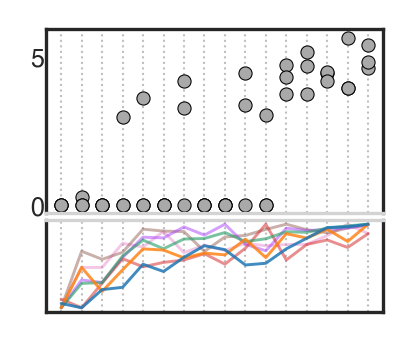

In [260]:
pgplot('CADM1',plain=True)

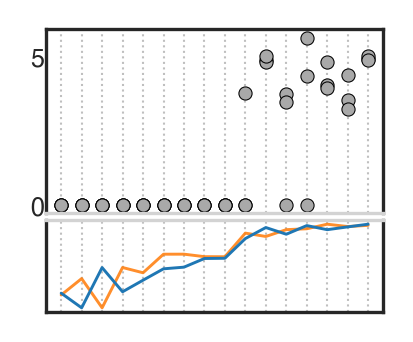

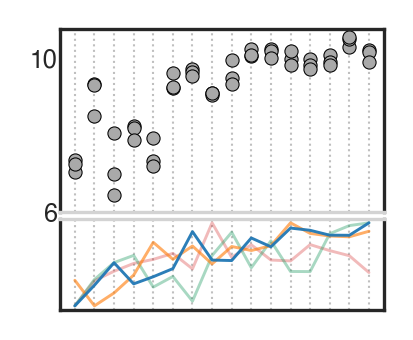

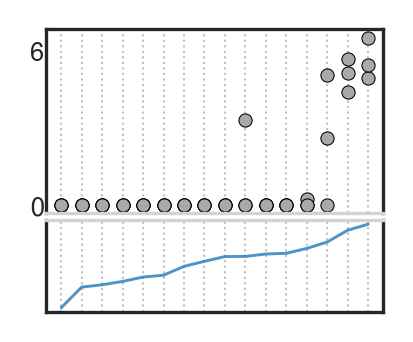

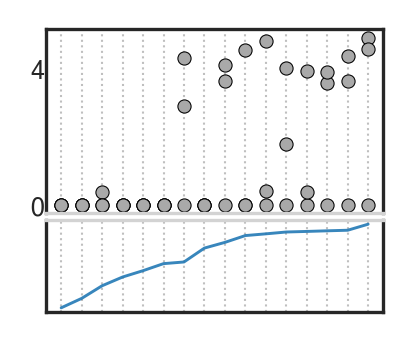

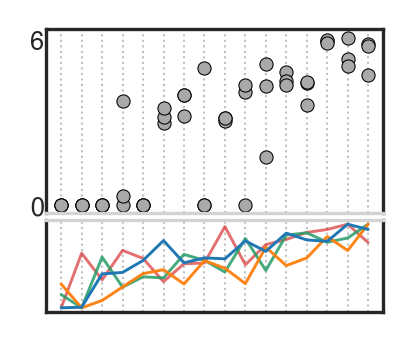

In [259]:
for gene in ['HPGD','GNLY', 'IL17RB', 'FAM49A', 'KLRD1']:
    pgplot(gene, plain=True)

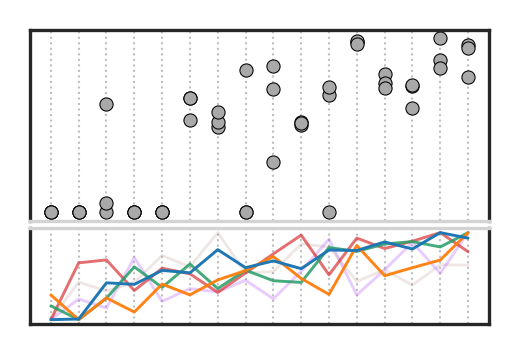

In [254]:
pgplot('KLRD1',cutoff=0.05,hide_legend=True, cust_size=(44*mm,30*mm))

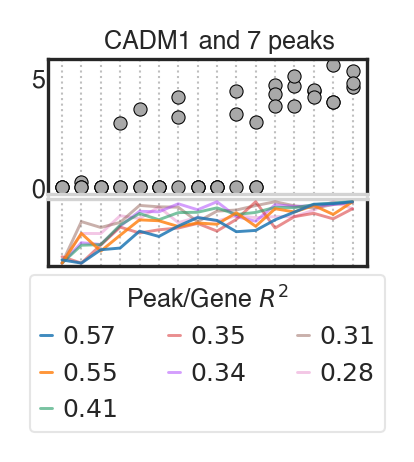

In [262]:
pgplot('CADM1')

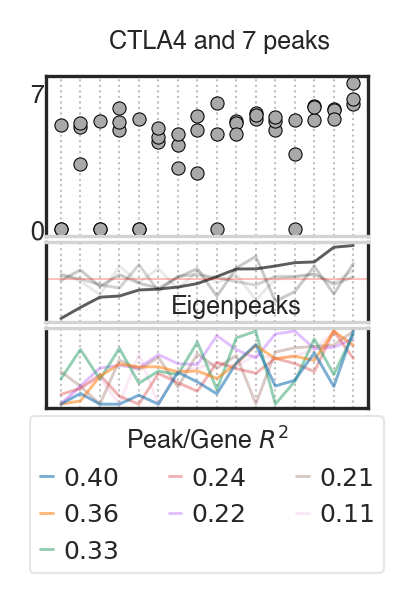

In [256]:
pgplot('CTLA4', eigen=True, cutoff=0.05)

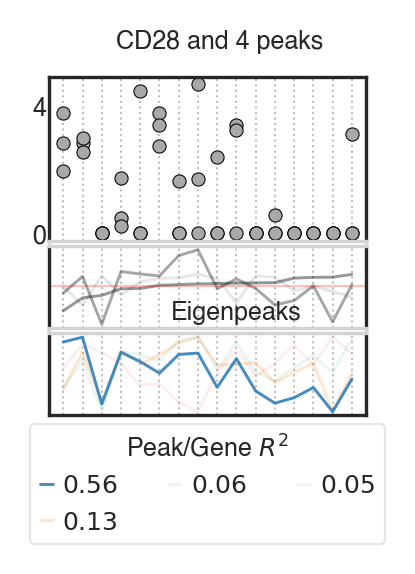

In [257]:
pgplot('CD28', eigen=True, cutoff=0.05)

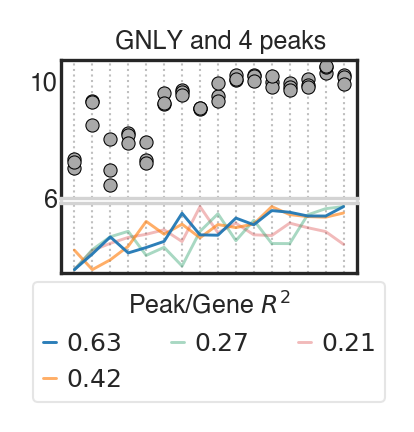

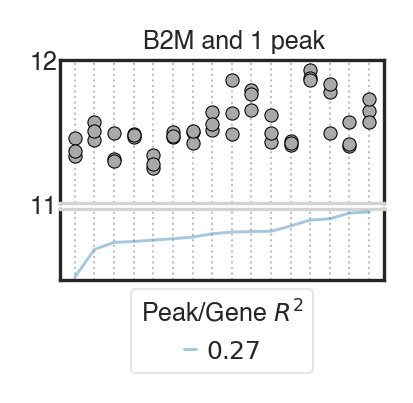

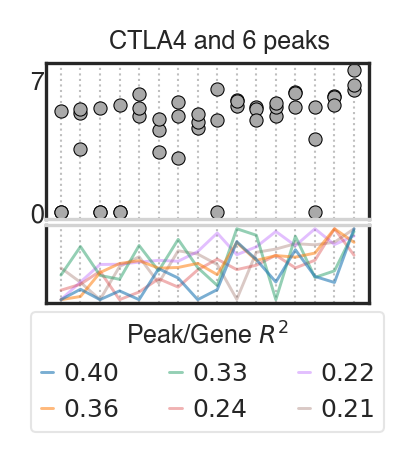

In [258]:
for gene in ['GNLY','B2M','CTLA4']:
    pgplot(gene)

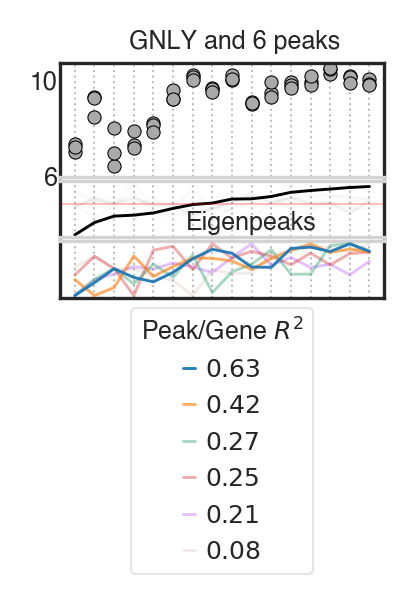

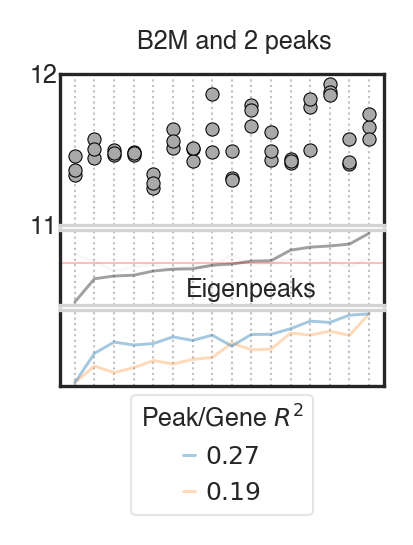

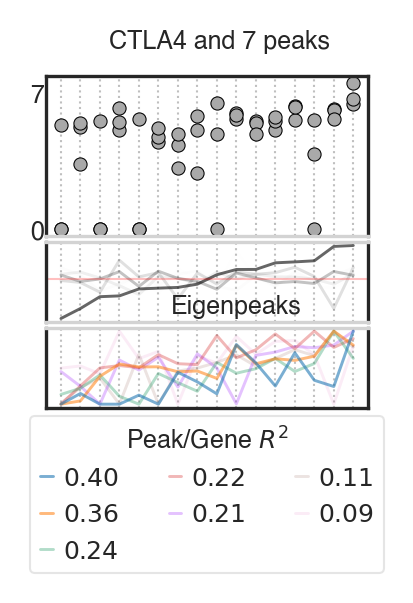

In [220]:
for gene in ['GNLY','B2M','CTLA4']:
    pgplot(gene, eigen=True, cutoff=0.05)

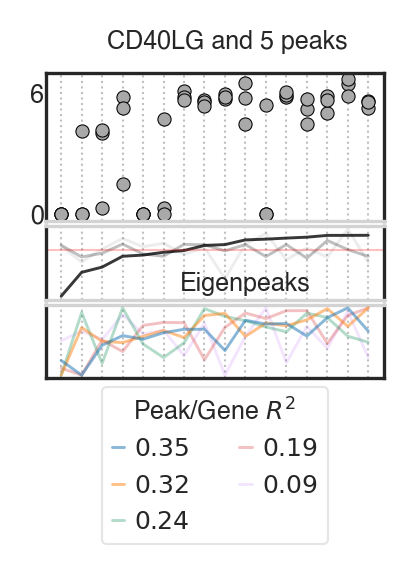

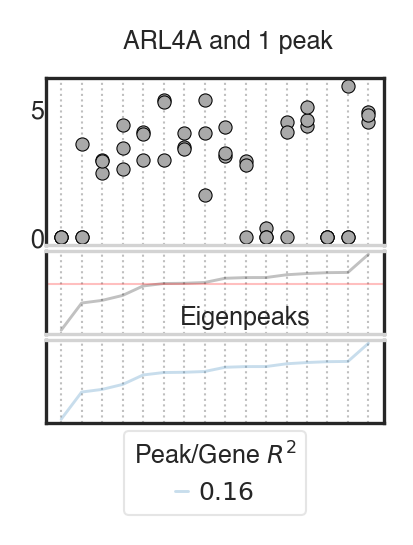

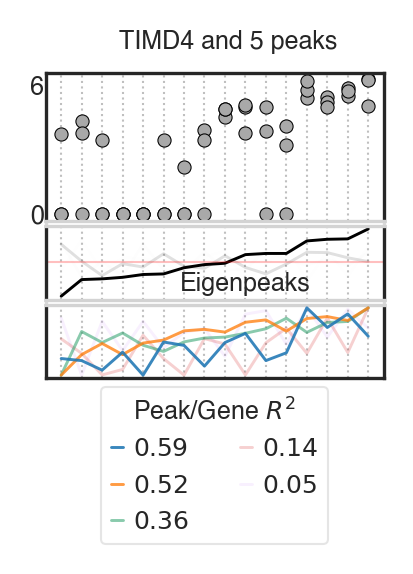

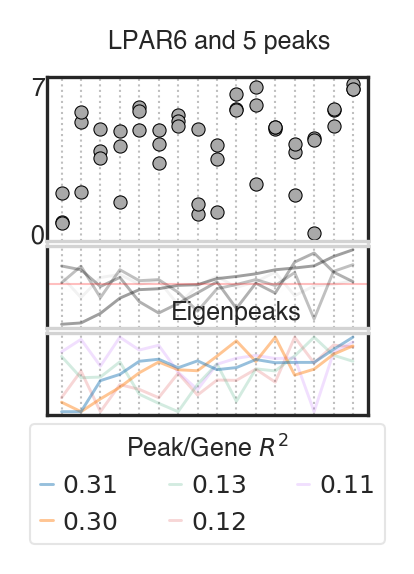

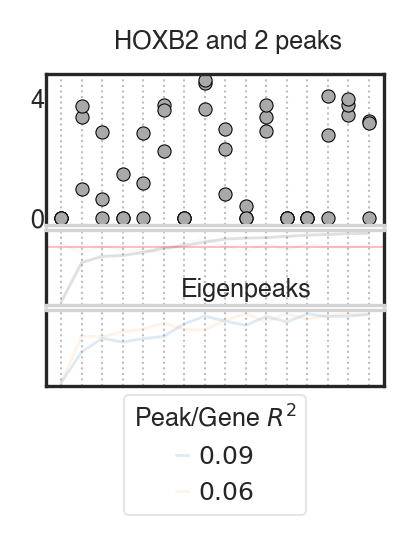

In [221]:
for gene in ['CD40LG', 'ARL4A', 'TIMD4', 'LPAR6', 'HOXB2']:
    pgplot(gene, cutoff=0.05, eigen=True)

In [177]:
inclone_vars = adata.to_df().groupby(adata.obs.Clone_ID).var().max()

In [188]:
inclone_vars

gene_name
MTND2P28          3.692920
hsa-mir-6723      1.564555
MTATP6P1         11.679506
RP11-206L10.9     4.236457
LINC01128         3.845229
                   ...    
TMLHE-1          11.130363
VAMP7            10.140436
SRIP3             2.958711
AC010970.2       15.698547
RNA5-8SP6         7.351594
Length: 9553, dtype: float32

In [191]:
onratio = (adata.to_df() < 0.1).sum()
inclone_vars = inclone_vars[(onratio > 20) & (onratio < 50)]

In [192]:
inclone_vars.sort_values()

gene_name
AC005255.3        1.813182
FAM3C2            2.006213
RPL36AP15         2.125771
MARK2             2.147838
RP11-466H18.1     2.219063
                   ...    
ZNF286A          20.333195
PRPF31           20.939278
C7orf49          21.674746
IDH3G-1          21.894424
FTSJ3            23.520975
Length: 3778, dtype: float32

In [175]:
adata.var.F_pval

gene_name
MTND2P28         0.500309
hsa-mir-6723     0.021218
MTATP6P1         0.000096
RP11-206L10.9    0.704243
LINC01128        0.667158
                   ...   
TMLHE-1          0.004259
VAMP7            0.436949
SRIP3            0.456741
AC010970.2       0.000100
RNA5-8SP6        0.766057
Name: F_pval, Length: 9553, dtype: float64

In [193]:
[gene for gene in inclone_vars.index if (adata.var.F_pval[gene] < 0.001) and (inclone_vars[gene] < 4.0)]

['DNAJC9', 'CCL4L1', 'APBB2', 'PPP1R14BP3', 'CTD-2035E11.5', 'CCZ1B']

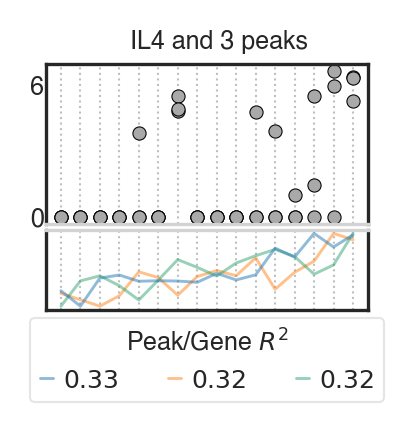

In [199]:
pgplot('IL4')

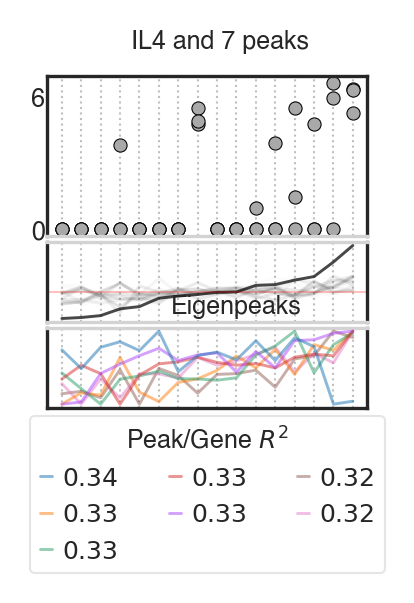

In [203]:
pgplot('IL4', window=500000, eigen=True)

In [208]:
adata.to_df()[['ANXA1','ANXA2']].corr()

gene_name     ANXA1     ANXA2
gene_name                    
ANXA1      1.000000  0.064118
ANXA2      0.064118  1.000000

In [210]:
adata.var.loc[['ANXA1','ANXA2']]

ENSG    F_pval  GC_content       TSS chr  dir       end  \
gene_name                                                                       
ANXA1      ENSG00000135046  0.000038       34.74  75766673   9    1  75785309   
ANXA2      ENSG00000182718  0.001686       44.95  60690185  15   -1  60695082   

          gene_name  highly_variable  highly_variable_rank  ...  mean_counts  \
gene_name                                                   ...                
ANXA1         ANXA1                1                1471.0  ...     6.315480   
ANXA2         ANXA2                1                 960.0  ...     6.806157   

                 means  mt  n_cells_by_counts  pct_dropout_by_counts  \
gene_name                                                              
ANXA1      1506.557143   0                 69               1.428571   
ANXA2      1884.928571   0                 68               2.857143   

              start  total_counts  transcript_length     variances  \
gene_name                                                            
ANXA1      75766673    442.083588        1112.125000  7.662179e+05   
ANXA2      60639333    476.431000         875.236842  1.181851e+06   

           variances_norm  
gene_name                  
ANXA1            1.481842  
ANXA2            1.604772  

[2 rows x 22 columns]

## Finding strong repressors

In [222]:
PCR_inter_ans = {}
for gene in PCR_ans.keys():
    PCR_a = PCR_ans[gene]
    ints = [col for col in PCR_a.columns if col[:3] == 'Int']
    PCR_inter_ans[gene] = PCR_a[ints]

We find strong repressors by looking for good peaks with negative R and R^2 > 0.5

In [223]:
repressed_genes = [gene for gene in PCR_ans.keys() if PCR_inter_ans[gene].loc[gene+'_R'].min() < -np.sqrt(0.5)]

In [224]:
len(repressed_genes)

54

Many of these genes with repressors may have high dropout, so we exclude these.

In [225]:
adata.var.loc[repressed_genes].pct_dropout_by_counts.sort_values()[:10]

gene_name
TXNIP        7.142857
FAM103A1    12.857143
TAOK1       25.714286
PHF20L1     28.571429
PMS2P1      31.428571
CCNK        32.857143
SAE1        40.000000
TNFRSF14    42.857143
RABEP1      42.857143
UBE3B       45.714286
Name: pct_dropout_by_counts, dtype: float64

This should restrict our attention to genes with <50% dropout.

In [227]:
plot_genes = adata.var.loc[repressed_genes].pct_dropout_by_counts.sort_values()[:5].index
plot_genes

Index(['TXNIP', 'FAM103A1', 'TAOK1', 'PHF20L1', 'PMS2P1'], dtype='object', name='gene_name')

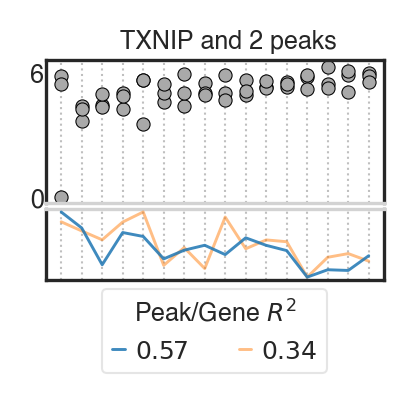

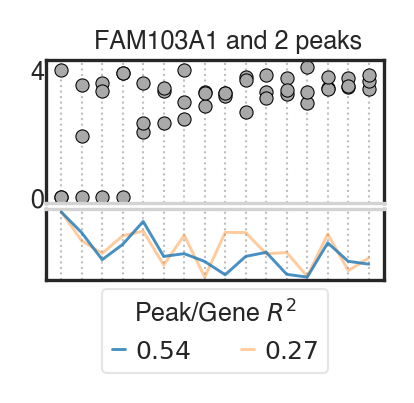

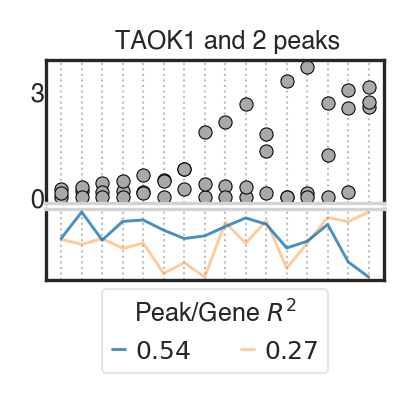

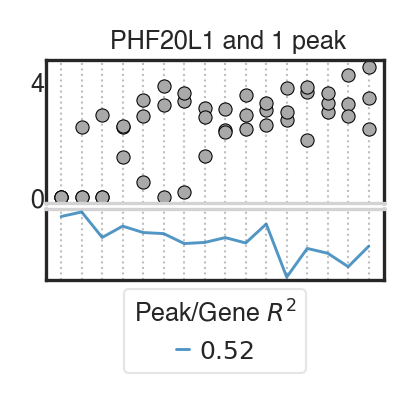

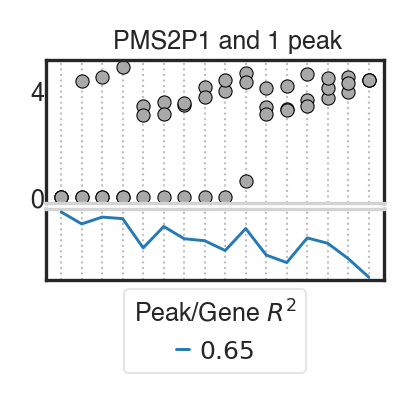

In [228]:
for gene in plot_genes:
    pgplot(gene, order='gene', file_annot='_repressor')

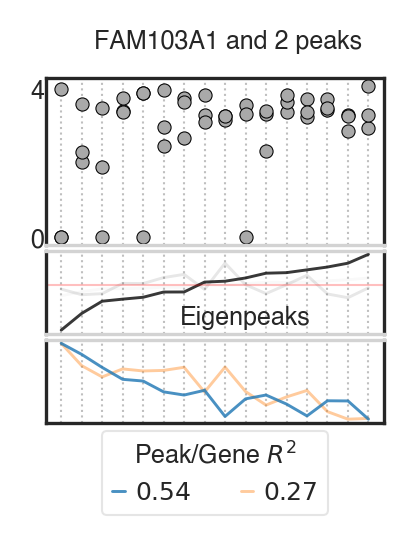

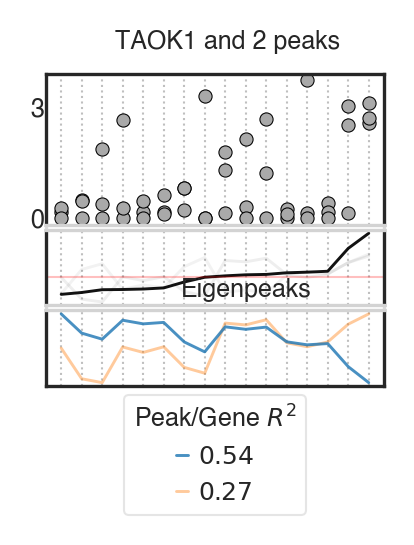

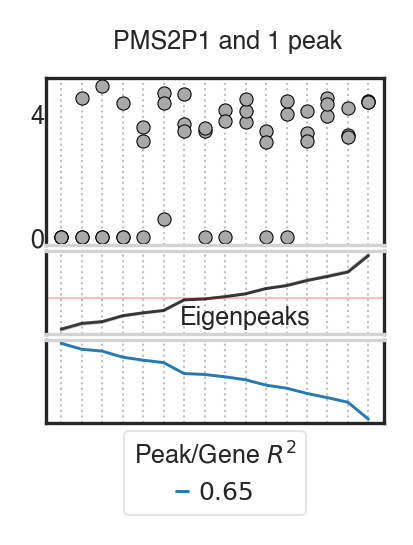

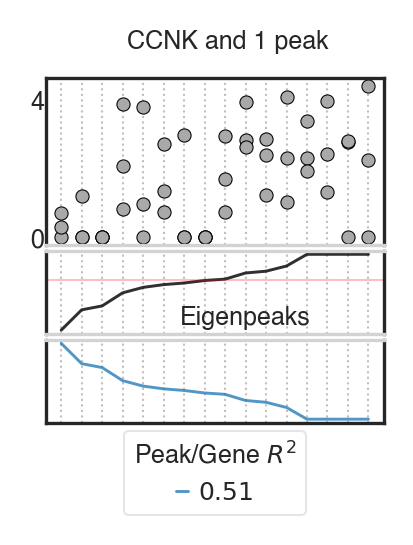

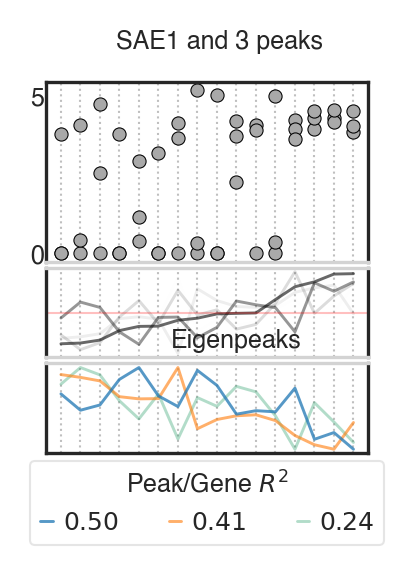

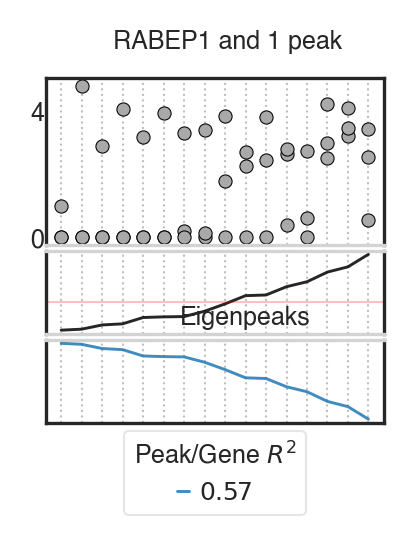

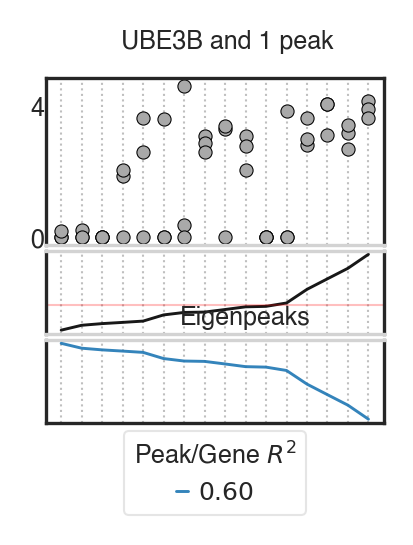

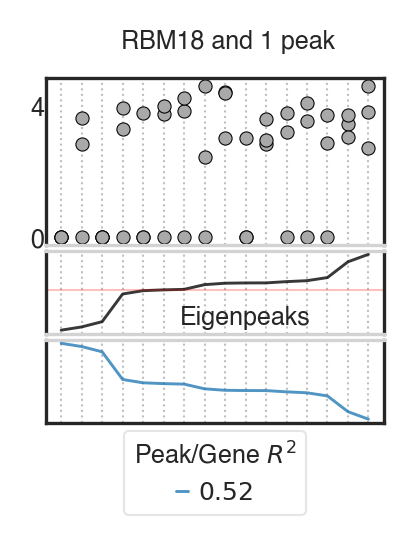

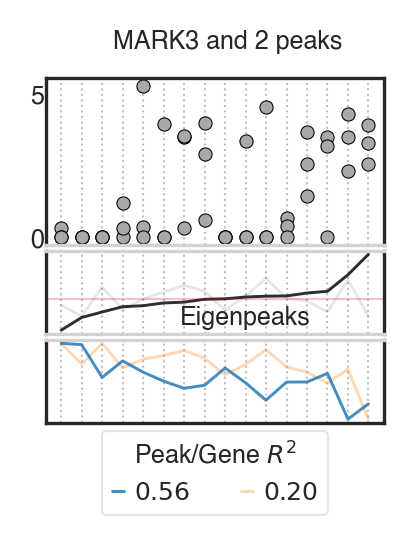

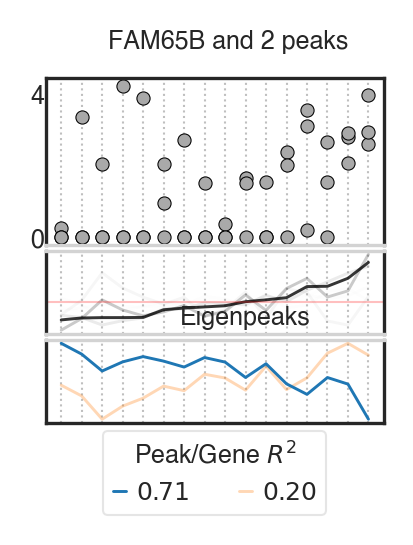

In [153]:
for gene in plot_genes:
    pgplot(gene, eigen=True, file_annot='_repressor')

# GOMP experiment

GOMPs are Genes of Many Peaks.  They are kind of like DORCs (cite!), but looking more narrowly for correlated peaks around each gene.

In [170]:
GOMP_df = pd.DataFrame(PCR_summary['num_sigpeaks'].sort_values())
GOMP_df['rank'] = range(len(GOMP_df))
GOMP_df['num_sigpeaks'] = GOMP_df['num_sigpeaks'].astype(np.int32)
GOMP_df

num_sigpeaks  rank
MTND2P28             0     0
ASCC2                0     1
UQCR10               0     2
ZMAT5                0     3
NF2                  0     4
...                ...   ...
MAST4                4  9515
CSF2                 4  9516
CADM1                5  9517
HDAC9                6  9518
PIP5K1B              9  9519

[9520 rows x 2 columns]

In [171]:
GOMP_df.num_sigpeaks.value_counts()

0    8090
1    1225
2     165
3      26
4      11
9       1
5       1
6       1
Name: num_sigpeaks, dtype: int64

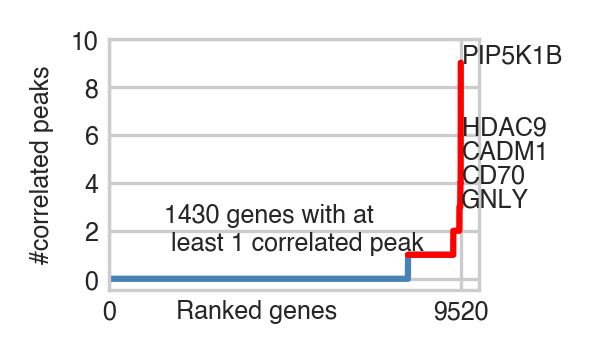

In [172]:
sns.set_style('whitegrid')
figsize=(50*mm, 30*mm)
fig, ax = plt.subplots(1,1,figsize=figsize, dpi=300)
setfontsize()

sns.lineplot(x='rank', y='num_sigpeaks', data=GOMP_df[GOMP_df.num_sigpeaks <= 1], ax=ax, color='steelblue')
sns.lineplot(x='rank', y='num_sigpeaks', data=GOMP_df[GOMP_df.num_sigpeaks >= 1], ax=ax, color='red')
sns.set_style('white')
setfontsize()

for n in range(3,18):
    if n in GOMP_df.num_sigpeaks.unique():
        gi = gene_plot = GOMP_df[GOMP_df.num_sigpeaks == n].index
        gene_plot = GOMP_df[GOMP_df.num_sigpeaks == n].index[0]
        ax.text(GOMP_df.loc[gene_plot,'rank']+30, GOMP_df.loc[gene_plot,'num_sigpeaks'], gene_plot, ha='left')
        #if len(gi) > 1:
        #    gene_plot = GOMP_df[GOMP_df.num_sigpeaks == n].index[1]
        #    ax.text(GOMP_df.loc[gene_plot,'rank']+30, GOMP_df.loc[gene_plot,'num_sigpeaks'], gene_plot, ha='left')


ax.set_ylabel('#correlated peaks')
ax.set_xlabel('Ranked genes', labelpad=-6, x=0.4)
vcs = GOMP_df.num_sigpeaks.value_counts()

ax.set_xticks([0,vcs.sum()])
#ax.set_xticks([])
ax.set_xlim(0,10000)
ax.set_yticks([0,2,4,6,8,10])
ax.text(1500,1.2,'{} genes with at \n least 1 correlated peak'.format(vcs.sum() - vcs[0]))
ax.tick_params(axis='both', pad=-1)
set_size(fig, figsize)
plt.savefig("Panels/GOMP_plot.pdf", bbox_inches='tight')
plt.show()

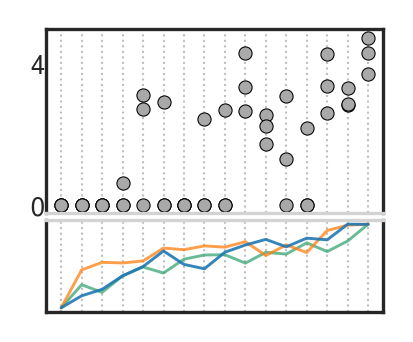

In [173]:
pgplot('APBB2', plain=True)

The "elbow" of this graph occurs with 3 or more significantly correlated peaks, so that's where we draw our line for GOMPs.

In [174]:
GOMPs = GOMP_df[GOMP_df.num_sigpeaks > 2].num_sigpeaks
GOMPs

GNLY          3
AC006369.2    3
GALM          3
IFNGR1        3
IL4           3
RCAN1         3
ITGAL         3
YPEL2         3
CCL4          3
IGFBP3        3
LMF2          3
ITGA1         3
ACTB          3
MACC1         3
ICOS          3
CTLA4         3
DDB2          3
RPL13A        3
ZNF251        3
PAX8-AS1      3
APBB2         3
AC092580.4    3
LAYN          3
RHOH          3
HLA-DPB1      3
CD86          3
CD70          4
CAMK1D        4
DOCK5         4
SLC4A10       4
NEAT1         4
TBC1D31       4
KLRD1         4
HDGFRP3       4
RASA3         4
MAST4         4
CSF2          4
CADM1         5
HDAC9         6
PIP5K1B       9
Name: num_sigpeaks, dtype: int32

In [175]:
GOMPs.to_csv('GOMPs.csv')

In [176]:
PCR_summary.loc[GOMPs.index].sort_values('num_sigpeaks')

promoter_R_sq num_eig  num_peaks  num_sigpeaks  eigen0_R_sq  \
GNLY            0.630406       1        5.0           3.0     0.609974   
CD86            0.212897       1       12.0           3.0     0.370213   
HLA-DPB1        0.583307       1        4.0           3.0     0.697309   
RHOH            0.469033       1        8.0           3.0     0.530187   
LAYN            0.376845       1        4.0           3.0     0.335216   
AC092580.4      0.452712       1        4.0           3.0     0.639619   
APBB2           0.498895       1        3.0           3.0     0.562750   
ZNF251          0.009178       1        5.0           3.0     0.590327   
RPL13A          0.072742       1        9.0           3.0     0.388831   
DDB2            0.296176       1        6.0           3.0     0.690071   
CTLA4           0.108908       1        9.0           3.0     0.424099   
ICOS            0.000046       1        9.0           3.0     0.691525   
MACC1            0.30913       1        3.0           3.0     0.289202   
PAX8-AS1        0.448214       1        8.0           3.0     0.643102   
ITGA1           0.330887       1        8.0           3.0     0.611488   
ACTB            0.345648       1        8.0           3.0     0.704015   
AC006369.2      0.163591       1        9.0           3.0     0.524518   
GALM                   0       1        9.0           3.0     0.493594   
IFNGR1          0.237708       1        4.0           3.0     0.577438   
RCAN1           0.209675       1        4.0           3.0     0.391215   
IL4                    0       1        4.0           3.0     0.427567   
YPEL2                  0       1        3.0           3.0     0.473893   
CCL4            0.228121       1       10.0           3.0     0.439875   
IGFBP3          0.383687       1        3.0           3.0     0.474883   
LMF2            0.218546       1        6.0           3.0     0.274000   
ITGAL                  0       1        8.0           3.0     0.591860   
CSF2            0.268171       1        7.0           4.0     0.490663   
HDGFRP3          0.42376       1        4.0           4.0     0.419862   
MAST4           0.322912       1       11.0           4.0     0.338303   
RASA3                  0       1        5.0           4.0     0.433650   
KLRD1           0.688533       1        6.0           4.0     0.706946   
CD70                   0       1        6.0           4.0     0.559739   
NEAT1           0.420511       1        8.0           4.0     0.599062   
SLC4A10                0       1        6.0           4.0     0.478565   
DOCK5           0.672861       1        6.0           4.0     0.699516   
CAMK1D          0.178274       1        7.0           4.0     0.351934   
TBC1D31         0.002214       1       11.0           4.0     0.483998   
CADM1            0.54748       1        7.0           5.0     0.460423   
HDAC9           0.424023       1        7.0           6.0     0.464959   
PIP5K1B           0.3177       1       11.0           9.0     0.367499   

            eigen1_R_sq  eigen2_R_sq  eigen3_R_sq  eigen4_R_sq  eigen5_R_sq  \
GNLY           0.035353     0.017675     0.003365     0.002525          NaN   
CD86           0.129965     0.103402     0.039438     0.021785     0.007680   
HLA-DPB1       0.047031     0.017515          NaN          NaN          NaN   
RHOH           0.132537     0.130494     0.017096     0.005794     0.000633   
LAYN           0.211185     0.032144     0.001563          NaN          NaN   
AC092580.4     0.000869     0.000171          NaN          NaN          NaN   
APBB2          0.051677     0.000045          NaN          NaN          NaN   
ZNF251         0.080092     0.010269     0.000546          NaN          NaN   
RPL13A         0.142857     0.093876     0.040219     0.031694     0.013845   
DDB2           0.074702     0.014597     0.005454     0.003854     0.003360   
CTLA4          0.142712     0.117120     0.056650     0.004407     0.001459   
ICOS           0.090833     

In [177]:
GOMPs.index

Index(['GNLY', 'AC006369.2', 'GALM', 'IFNGR1', 'IL4', 'RCAN1', 'ITGAL',
       'YPEL2', 'CCL4', 'IGFBP3', 'LMF2', 'ITGA1', 'ACTB', 'MACC1', 'ICOS',
       'CTLA4', 'DDB2', 'RPL13A', 'ZNF251', 'PAX8-AS1', 'APBB2', 'AC092580.4',
       'LAYN', 'RHOH', 'HLA-DPB1', 'CD86', 'CD70', 'CAMK1D', 'DOCK5',
       'SLC4A10', 'NEAT1', 'TBC1D31', 'KLRD1', 'HDGFRP3', 'RASA3', 'MAST4',
       'CSF2', 'CADM1', 'HDAC9', 'PIP5K1B'],
      dtype='object')

In [178]:
print(', '.join(GOMPs.index))

GNLY, AC006369.2, GALM, IFNGR1, IL4, RCAN1, ITGAL, YPEL2, CCL4, IGFBP3, LMF2, ITGA1, ACTB, MACC1, ICOS, CTLA4, DDB2, RPL13A, ZNF251, PAX8-AS1, APBB2, AC092580.4, LAYN, RHOH, HLA-DPB1, CD86, CD70, CAMK1D, DOCK5, SLC4A10, NEAT1, TBC1D31, KLRD1, HDGFRP3, RASA3, MAST4, CSF2, CADM1, HDAC9, PIP5K1B


Now we plot the GOMPiest of GOMPs... those with 5 or more significantly correlated peaks.

# Cross-experiment check

In [179]:
adata.var['nearby_peakvar'] = adata.var['near_peaks'].apply(lambda peaklist : mm_peaks[peaklist].max())

In [180]:
adata.var['log_F_pval'] = -np.log10(adata.var['F_pval'])
adata.var.head()

ENSG    F_pval  GC_content     TSS chr  dir     end  \
gene_name                                                                       
MTND2P28       ENSG00000225630  0.500309       43.10  565020   1    1  566063   
hsa-mir-6723   ENSG00000237973  0.021218       45.76  566454   1    1  567996   
MTATP6P1       ENSG00000248527  0.000096       43.91  569076   1    1  569756   
RP11-206L10.9  ENSG00000237491  0.704243       40.42  714150   1    1  745440   
LINC01128      ENSG00000228794  0.667158       46.34  762988   1    1  794826   

                   gene_name  highly_variable  highly_variable_rank  ...  \
gene_name                                                            ...   
MTND2P28            MTND2P28                0                   NaN  ...   
hsa-mir-6723    hsa-mir-6723                0                   NaN  ...   
MTATP6P1            MTATP6P1                0                   NaN  ...   
RP11-206L10.9  RP11-206L10.9                0                   NaN  ...   
LINC01128          LINC01128                0                   NaN  ...   

               n_cells_by_counts  pct_dropout_by_counts   start  total_counts  \
gene_name                                                                       
MTND2P28                      67               4.285714  565020    203.999100   
hsa-mir-6723                  63              10.000000  566454    107.062729   
MTATP6P1                      69               1.428571  569076    380.220612   
RP11-206L10.9                  5              92.857143  714150     12.996776   
LINC01128                      4              94.285714  762988     12.210242   

               transcript_length     variances  variances_norm  \
gene_name                                                        
MTND2P28             1044.000000    388.754658        0.069281   
hsa-mir-6723         1543.000000    137.753416        0.087108   
MTATP6P1              681.000000  25071.186128        0.411845   
RP11-206L10.9         704.000000     34.765217        0.635988   
LINC01128            1197.363636    114.340373        0.837090   

                             near_peaks  nearby_peakvar  log_F_pval  
gene_name                                                            
MTND2P28                             []             NaN    0.300762  
hsa-mir-6723                         []             NaN    1.673288  
MTATP6P1                             []             NaN    4.017030  
RP11-206L10.9              [Interval_4]        1.020767    0.152277  
LINC01128      [Interval_4, Interval_6]        1.020767    0.175771  

[5 rows x 25 columns]

In [181]:
def ANOVA_p(X,y):
    args = [X[y == k] for k in np.unique(y)]
    pvals = f_oneway(*args)[1] # Use f_oneway for high precision.
    return pd.Series(pvals, index=X.columns, name='pval') # Built-in ANOVA F from scikit.

In [182]:
all_genes_P9855.sort_values().to_csv('../Data/all_genes_P9855.csv')

NameError: name 'all_genes_P9855' is not defined

In [184]:
X = pd_gene.to_df()
y = pd_gene.obs.Clone_ID

all_genes_P9855 = ANOVA_p(X,y)
all_genes_P9855.to_csv('../Data/all_genes_P9855.csv')

clonal_genes_P9855 = all_genes_P9855.sort_values()[:500]
clonal_genes_P9855.to_csv('../Data/clonal_genes_P9855.csv')

In [185]:
clonal_genes_P9855

gene_name
KIR3DL2       8.463630e-29
CENPN         3.267910e-21
GNLY          8.373333e-17
FKBP1A        1.300491e-14
GZMK          2.386231e-14
                  ...     
MT-ND4L       2.061593e-03
RTN4IP1       2.069690e-03
PIM1          2.071061e-03
HEXB          2.080254e-03
AC006129.2    2.086907e-03
Name: pval, Length: 500, dtype: float64

In [186]:
y_shuff = pd.Series(np.random.permutation(y.values), index=y.index, name='Clone_ID') # Shuffled clone labels

In [187]:
clonal_decoy_genes_P9855 = ANOVA_p(X,y_shuff).sort_values()[:500]
clonal_decoy_genes_P9855.to_csv('../Data/clonal_decoy_genes_P9855.csv')

In [188]:
clonal_decoy_genes_P9855

gene_name
PARD6A           1.519511e-12
ZNF443           5.766688e-08
TRIM47           1.761505e-07
RP11-465B22.3    7.194861e-07
PHTF2            5.265719e-06
                     ...     
B2M              4.701772e-02
SLC3A2           4.725022e-02
SLC25A44         4.740620e-02
RP11-18H21.1     4.752375e-02
CD247            4.753507e-02
Name: pval, Length: 500, dtype: float64

In [189]:
def get_genes(filename):
    g_series = pd.read_csv('../Data/{}.csv'.format(filename), index_col = 0)
    g_list = [gene for gene in g_series.index if gene in adata.var_names]
    return g_list


In [197]:
tranches = {}
genesets = ['all_genes_','clonal_decoy_genes_','clonal_genes_']
for experiment in ['P1902', 'P3128', 'P9855', 'invivo']:
    for gs in genesets:
        tranches[gs+experiment] = get_genes(gs+experiment)

In [198]:
ATG_df = pd.read_csv('Amos_Tanay_Genes_new.csv', header=0, skiprows=range(9), index_col=0)
ATG_df

HCT116_WT  H1299   WI38  HCT116_DKO
gene                                        
S100A11       True   True   True        True
FTH1          True   True   True        True
MYL6          True   True   True        True
B2M           True   True   True        True
RPL23         True   True   True        True
...            ...    ...    ...         ...
RUVBL2       False  False  False        True
KLK6         False  False  False        True
H1F0         False  False  False        True
MX1          False  False  False        True
TFF2         False  False  False        True

[2088 rows x 4 columns]

In [199]:
tranches['all_genes_'+'AT'] = [gene for gene in ATG_df.index if gene in adata.var_names]
tranches['HCT116_WT_'+'AT'] = [gene for gene in ATG_df[ATG_df['HCT116_WT']].index if gene in adata.var_names]
tranches['H1299_'+'AT'] = [gene for gene in ATG_df[ATG_df['H1299']].index if gene in adata.var_names]

In [200]:
np_dfs = {}
for tkey in tranches.keys():
    tranche = tranches[tkey]
    np_dfs[tkey] = pd.DataFrame(adata.var.loc[tranche]['nearby_peakvar'].copy())

In [201]:
def perc_geq(ser, cutoff=2):
    return ((ser > cutoff).values.sum() / len(ser))

In [202]:
perc_geq(np_dfs['H1299_AT'], cutoff=1.5)

0.17932489451476794

In [203]:
perc_df = pd.DataFrame(columns=['Experiment', 'geneset', 'Percent', 'Num_genes'], 
                       index=list(range(12)))
j = 0
for experiment in ['P1902', 'P3128', 'P9855', 'invivo']:
    for gs in genesets:
        perc_df.iloc[j]['Percent'] = perc_geq(np_dfs[gs+experiment], cutoff=1.5)
        perc_df.iloc[j]['Num_genes'] = len(np_dfs[gs+experiment])
        perc_df.iloc[j]['Experiment'] = experiment
        perc_df.iloc[j]['geneset'] = gs
        j += 1
perc_df

Experiment              geneset   Percent Num_genes
0       P1902           all_genes_  0.156324      7171
1       P1902  clonal_decoy_genes_  0.161826       482
2       P1902        clonal_genes_   0.26569       478
3       P3128           all_genes_  0.158444      8047
4       P3128  clonal_decoy_genes_  0.164859       461
5       P3128        clonal_genes_  0.302772       469
6       P9855           all_genes_  0.162357      9553
7       P9855  clonal_decoy_genes_     0.136       500
8       P9855        clonal_genes_     0.236       500
9      invivo           all_genes_   0.15633      7030
10     invivo  clonal_decoy_genes_      0.15       480
11     invivo        clonal_genes_   0.22113       407

In [204]:
perc_df['geneprint'] = perc_df.geneset.map({'all_genes_':'All genes',
                                            'clonal_decoy_genes_':'~500 decoy \n clonal genes',
                                            'clonal_genes_':'Top ~500 \n Clonal genes'})

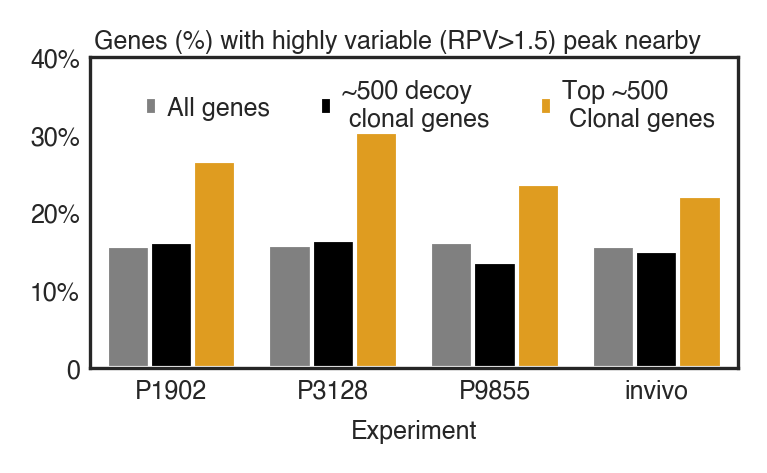

In [205]:
figsize=(65*mm, 40*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300, sharey=True, sharex=True)
sns.set_style('whitegrid')
setfontsize()
sns.barplot(x="Experiment", y="Percent", hue="geneprint", palette = ['gray','black','orange'],
                   data=perc_df)
ax.legend(ncol=3, frameon=False)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels(['0','10%','20%','30%','40%'])
ax.set_ylabel('')

ax.tick_params(axis='both', pad=-1)
plt.suptitle('Genes (%) with highly variable (RPV>1.5) peak nearby', x=0.55)
set_size(fig, figsize)
plt.savefig("Panels/Crossexp_RPV.pdf".format(gene), bbox_inches='tight')

plt.show()

In [206]:
geneset = {}
for experiment in ['P1902','P3128','P9855','invivo']:
    geneset[experiment] = set(tranches['clonal_genes_'+experiment])
geneset['HCT116_WT'] = set(tranches['HCT116_WT_AT'])
geneset['H1299'] = set(tranches['H1299_AT'])

#tranches['HCT116_WT_'+'AT']
#'H1299_'+'AT'

In [207]:
len(geneset['P1902'] & geneset['P3128'])

190

In [208]:
from matplotlib_venn import venn3

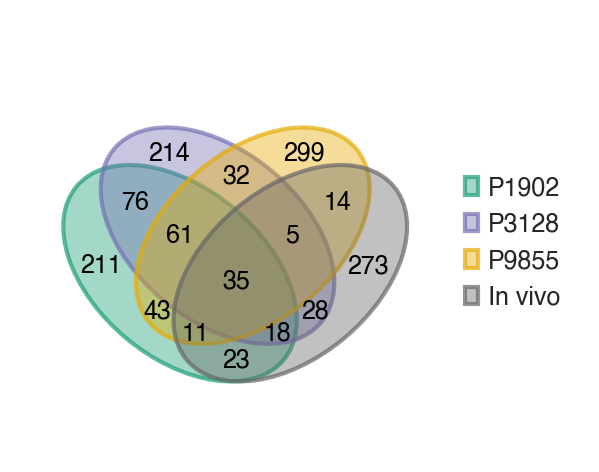

In [267]:
figsize = (60*mm, 40*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)

gv_sets = {'P1902':geneset['P1902'],
          'P3128':geneset['P3128'],
          'P9855':geneset['P9855'],
          'In vivo':geneset['invivo']}

cmap = plt.cm.get_cmap('Dark2')

venn(gv_sets, ax=ax, fontsize=6, legend_loc=None, cmap=cmap)
handles = ['P1902','P3128','P9855','In vivo']
ax.legend(handles, bbox_to_anchor=(1,0.7), frameon=False)
#print(ax.get_children())
#print(type(lgnd))
#venn3([geneset['P1902'],geneset['P3128'],geneset['P9855']], ('P1902', 'P3128', 'P9855'), ax=ax)
#venn3([geneset['P1902'] & geneset['invivo'],geneset['P3128'] & geneset['invivo'],geneset['P9855'] & geneset['invivo']], 
#      ('P1902 \n +in vivo', 'P3128 \n +in vivo', 'P9855 \n +in vivo'), ax=ax[1])

set_size(fig, figsize)
plt.savefig("Panels/Crossexp_Venn.pdf".format(gene), bbox_inches='tight')

plt.show()

In [268]:
print(', '.join(geneset['P1902'] & geneset['P3128']))

LTB, LINC00861, FAM3C, ISG15, CD52, MIR155HG, EPAS1, XBP1, CLDND1, FAIM3, KLRC3, RP11-465B22.3, SEPT1, CXCR6, COTL1, ITGA4, S100A4, CCL23, CSF2, CD70, SAMD3, IDH2, AKR1C3, ITGA1, MT-CYB, SMCO4, IL2RA, HNRNPA1, LAG3, KLRB1, CMTM6, CD8B, CD28, PDGFA, PTPRN2, GZMA, CD27, CCL5, POU2F2, SH3BGRL3, FTL, ASB2, LAIR2, HLA-DPB1, IFITM2, AOAH, CADM1, EMP3, CTNNB1, CCL4L1, IFNG, APBB2, CTSL, HNRNPH1, TRIM22, GZMB, LRRC28, CTLA4, IL16, KLRC1, LPAR6, HLA-DQB1, CXCR3, ANXA1, CD86, PHLDA1, MAF, MT-TH, PRSS21, CREM, HOXB2, RPS27L, PMCH, GZMH, SOX4, SDC4, CLECL1, HMGN2P8, CD3G, LINC00892, AMICA1, NPTN, CD7, TOP2A, MX1, FLNA-1, MT-TF, RGS16, RP11-493L12.5, RPL39L, ENTPD1, ZBTB32, HLA-DPA1, HLA-DMA, DPYSL2, SELL, GPR15, KLRC2, ALOX5AP, SRGN, CTSC, RP11-217O12.1, PLEK, STAP1, PFN1, CTD-2328D6.1, HOTAIRM1, SLAMF7, RDH10, HLA-DRB1, ITM2A, MT-TP, RP11-475C16.1, FXYD5, CDKN1A, REG4, EOMES, HSP90AB1, CLIC3, B2M, PDE7B, CDKN2B, ERI1, CASC7, TNFRSF18, CLEC7A, PER3, FAM49A, SIRPG, KLRD1, RPS19, ID3, GNG8, MT-TN, A

In [269]:
print(', '.join(geneset['P1902'] & geneset['invivo']))

LTB, ITGB1, ISG15, CD52, CCL4, COTL1, MT-ND5, S100A4, STOM, HLA-A, HNRNPA1, TMSB4XP8, MT-ND4, KLRB1, CD8B, CD28, GZMA, CD27, CCL5, SH3BGRL3, VAMP5, LAIR2, IFITM2, AOAH, GZMB, SLA, PRSS21, GZMH, TMEM204, AMICA1, KLRG1, CD7, RHOH, GZMK, FLNA-1, GIMAP1, HLA-H, DPP4, SELL, ALOX5AP, SRGN, ANXA2, ENOSF1, PLEK, PFN1, SH2D1A, LGALS9, ARPC1B, HLA-DRB1, ITM2A, LGALS3BP, FXYD5, PATL2, HSP90AB1, CLIC3, NKG7, LY6E, CD300A, SIRPG, KLRD1, ACTB, CTSW, IL18RAP, NELL2, GLO1, HLA-B, MT-TS2, AC092580.4, CFL1, APOBEC3C, TXK, PAX8-AS1, HLA-DRB5, ITGAL, RP11-81H14.2, PAG1, LGALS1, PRF1, FCGR3A, CST7, TMSB10, NCR3, SIT1, KLRC4, NEAT1, GPR171, IL32


In [270]:
print(', '.join(geneset['P1902'] & geneset['P9855']))

LTB, LINC00861, ITGB1, FAM3C, ISG15, CD52, CLDND1, RP11-465B22.3, TUBA4A, TMED10, CXCR6, MT-ND5, S100A4, CCL4L2, CSF2, CD70, STOM, IDH2, FEZ1, CDK6, MT-CYB, HLA-A, TMSB4XP8, KLRB1, CD8B, PDGFA, GZMA, CCL5, SH3BGRL3, FTL, TMSB4X, LAIR2, HLA-DPB1, AOAH, CADM1, EMP3, IFI44L, CCL4L1, IFNG, APBB2, HNRNPH1, GZMB, GOLIM4, KLRC1, LPAR6, ANXA1, MT-TM, GINS2, SKIL, PRSS21, HOXB2, RPS27L, PMCH, GZMH, PPIB, SOX4, CLECL1, TXN, PTTG1, LINC00892, AMICA1, CD7, GZMK, RP11-493L12.5, LRRN3, ENTPD1, TMSB4XP1, HLA-DPA1, GPR15, SELL, GIMAP7, KLRC2, ALOX5AP, SRGN, CTSC, ANXA2, TMSB4XP4, RP11-217O12.1, PLEK, EMC7, STAP1, PFN1, IFI6, LSP1, ARPC1B, ITM2A, MT-TP, ID2, REG4, RPS20, EOMES, PRDM1, DDAH2, B2M, NKG7, KIAA0319L, CLEC7A, MT-ND4L, FUT8, CD300A, SIRPG, KLRD1, RPS19, HNRNPL, STYK1, ACTB, CTSW, KLRK1, SRRT, PLS3-1, IFITM1, AC092580.4, CALR, APOBEC3C, PAX8-AS1, TXK, MT-CO2, RNF19A, ERO1L, C3orf14, RNF213, RP11-81H14.2, TIMD4, MT-TE, MT-CO1, HPGD, DCTN3, LGALS1, ETV5, CTSH, CAPG, FTLP3, FCGR3A, CD74, TMSB10,

In [271]:
len(geneset['P1902'] & geneset['H1299'])

51

In [272]:
print(', '.join(geneset['P1902'] & geneset['H1299']))

PDCD5, EIF5A, AHNAK, PFN1, ISG15, MALAT1, MT-CO2, MT-ATP6, MT2A, S100A11, ARPC1B, COTL1, ANXA1, MT-ND5, GSTP1, ID2, PRELID1, FXYD5, MT-CO1, CD70, RPL6, RPS20, CHCHD2, MT-CYB, PRSS21, HSP90AB1, RPL27, HNRNPA1, LGALS1, B2M, MT-ND4, TXN, TMSB10, ACTG1, MT-ND4L, ZCRB1, LY6E, SH3BGRL3, FTL, RPS19, EEF1D, ID3, POLR2L, TMSB4X, HMGN1, RPL37A, IFITM2, RPS3A, HSPB1, HMGN2, AP2S1


In [273]:
print(', '.join(geneset['P1902'] & geneset['HCT116_WT']))

PDCD5, CTSL, ARL6IP6, EMC7, PFN1, ANP32A, ISG15, S100A11, WSB1, IDI1, MT-ND5, LGALS3BP, ID2, S100A4, CDKN1A, RPL6, MINOS1, RPL27, CLIC3, HNRNPA1, PRDX2, CDC37, B2M, CDKN2B, PPIB, ARHGDIA, SOX4, CAPG, NUCB2, TXN, LMAN1, MT-ND4L, KLF6, FAM49B, SH3BGRL3, FTL, EEF1D, POLR2L, TMSB4X, STEAP1, ACAT2, EMP3, HSPB1, PTP4A2, HLA-B, MCM4, TGIF1


# Gene heatmap and Paired gene peak heatmaps

In [288]:
genelist = list(adata.var[adata.var.F_pval < 0.001].index)
len(genelist)

386

In [289]:
genelist = gene_clonal[genelist].idxmax().sort_values().index
len(genelist) # marker gene sorted

386

In [290]:
samples = [samp for clone in gene_clonal[genelist].idxmax().sort_values().unique()
          for samp in adata.obs[adata.obs.Clone_ID == clone].index]
len(samples)

48

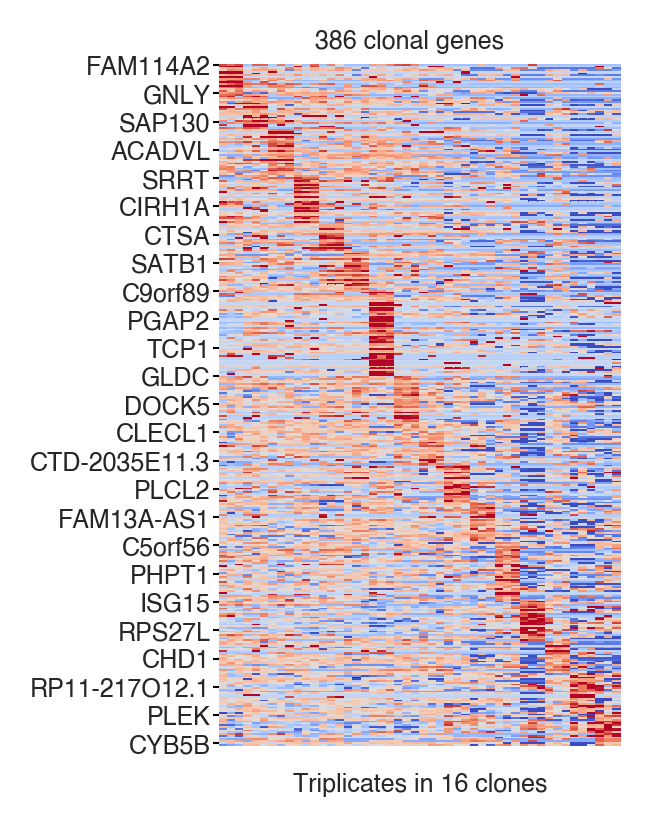

In [291]:
sns.set_style('white')
figsize=(55*mm,70*mm)
fig,ax = plt.subplots(1,1,figsize=figsize,dpi=300)
setfontsize()

plot_df = adata.to_df().loc[samples, genelist]
plot_df = (plot_df - plot_df.mean()) / plot_df.std()

sns.heatmap(plot_df.T, vmin=-2, vmax=2, cmap='coolwarm', ax=ax, cbar=False)



ax.set_xlabel('Triplicates in {} clones'.format(len(gene_clonal)))

                 
ax.set_xticklabels([])
ax.set_xticklabels([])
ax.set_ylabel('')

ax.tick_params(axis='both', pad=-1)
ax.tick_params(axis='y', length=1.5, width=0.5, color='k', left=True, pad=0.5)
plt.suptitle('{} clonal genes'.format(len(genelist)), y=0.95, x=0.55)
set_size(fig, figsize)
plt.savefig("Panels/Triplicate_heatmap.pdf".format(gene), bbox_inches='tight')

plt.show()

In [292]:
genelist = list(adata.var[adata.var.F_pval < 0.01].index)
genelist = [gene for gene in genelist if gene in PCR_summary.index]
genelist = [gene for gene in genelist if PCR_summary.loc[gene,'num_sigpeaks'] > 0]
len(genelist)

205

In [293]:
genelist = gene_clonal[genelist].idxmax().sort_values().index
len(genelist) # marker gene sorted

205

In [294]:
peaklist = [peak for gene in genelist for peak in adata.var.near_peaks[gene] 
            if PCR_ans[gene][peak][gene+'_R'] > np.sqrt(R2_geneback[gene])]
len(peaklist)

237

In [295]:
p_by_gene = pd.DataFrame(0,index=gene_clonal.index, columns=genelist)
for gene in genelist:
    npeaks = adata.var.near_peaks[gene]
    peaks = [peak for peak in peaklist if peak in npeaks]
    p_by_gene[gene] = peak_clonal[peaks].sum(axis=1)

In [296]:
genelist = [gene for gene in genelist if p_by_gene[gene].max() > 0.0]

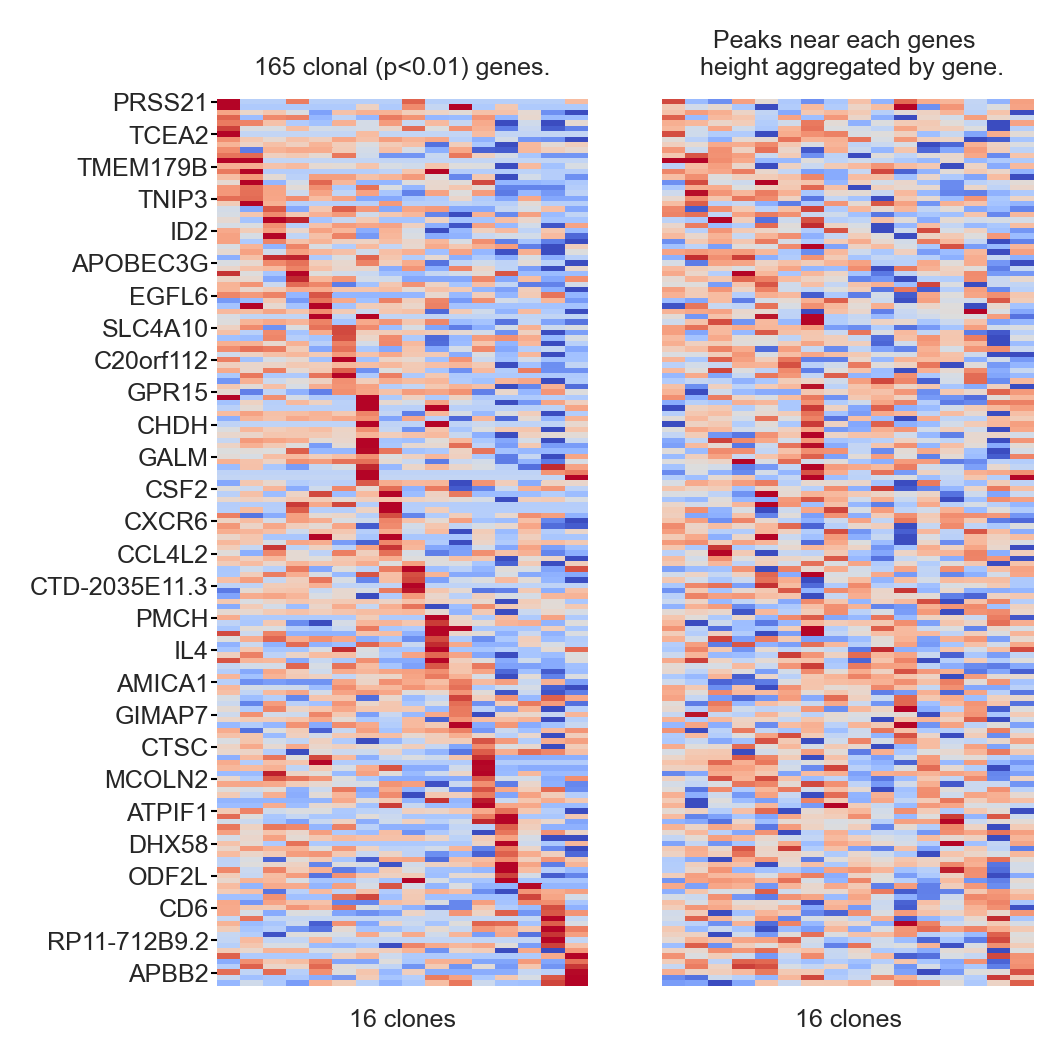

In [298]:
sns.set_style('white')
figsize=(90*mm,90*mm)
fig,ax = plt.subplots(1,2,figsize=figsize,dpi=300, sharex=True, sharey=True)

clonesort = list(gene_clonal.index)
clonesort.sort()
gplot_df = gene_clonal.loc[clonesort,genelist]
gplot_df = (gplot_df - gplot_df.mean() )/ gplot_df.std()

sns.heatmap(gplot_df.T, vmin=-2, vmax=2, cmap='coolwarm', ax=ax[0], cbar=False)

pplot_df = p_by_gene.loc[clonesort, genelist]
pplot_df = (pplot_df - pplot_df.mean() ) / pplot_df.std()

sns.heatmap(pplot_df.T, vmin=-2, vmax=2, cmap='coolwarm', ax=ax[1], cbar=False)

ax[0].set_xlabel('{} clones'.format(len(gplot_df)))
ax[1].set_xlabel('{} clones'.format(len(pplot_df)))
                 
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].set_title('{} clonal (p<0.01) genes.'.format(len(genelist)))
ax[1].set_title('Peaks near each genes \n height aggregated by gene.')

ax[0].tick_params(axis='x', pad=-2)
ax[0].tick_params(axis='y', length=1.5, width=0.5, color='k', left=True, pad=0.5)
ax[1].tick_params(axis='x', pad=-2)
set_size(fig, figsize)
plt.savefig("Panels/Genes_peaks_heatmap.pdf".format(gene), bbox_inches='tight')

plt.show()

# Different kinds of peaks and genes

In [176]:
dist_mat = {}
pro_peaks_dict = {}
enh_peaks_dict = {}
pro_corrs_dict = {}
enh_corrs_dict = {}
pro_score_dict = {}
enh_score_dict = {}
for chrome in chromes:
    gene_TSSs = adata.var[adata.var['chr'] == chrome].TSS.sort_values()
    peak_mids = ATAC_data.var[ATAC_data.var['chr'] == chrome].mid.sort_values()
    dist_mat[chrome] = pd.DataFrame(np.abs(np.subtract.outer(gene_TSSs.values, peak_mids.values)),
                                    index=gene_TSSs.index, columns=peak_mids.index)
    pp = (dist_mat[chrome] <= 1000).any()
    pro_peaks_dict[chrome] = pp[pp].index
    
    ee = (dist_mat[chrome] <= 50000).any() & (~(dist_mat[chrome] <= 1000).any())
    enh_peaks_dict[chrome] = ee[ee].index
    
    enh_corrs_dict[chrome] = pg_corrs[chrome].where((dist_mat[chrome].T <= 50000) & ~(dist_mat[chrome].T <= 1000)).T
    
    pro_corrs_dict[chrome] = pg_corrs[chrome].where((dist_mat[chrome].T <= 1000)).T
    
    e_ss = enh_corrs_dict[chrome]**2
    p_ss = pro_corrs_dict[chrome]**2
    enh_score_dict[chrome] = (e_ss).sum(axis=1)
    pro_score_dict[chrome] = (p_ss).sum(axis=1)
    
    e_num = (e_ss > 0).sum(axis=1)
    p_num = (p_ss > 0).sum(axis=1)
    e_adj = e_num * R2_sigs.loc[e_num.index]
    p_adj = p_num * R2_sigs.loc[e_num.index]
    enh_score_dict[chrome] -= e_adj
    pro_score_dict[chrome] -= p_adj
    
pro_peaks = [peak for chrome in chromes for peak in pro_peaks_dict[chrome]]
enh_peaks = [peak for chrome in chromes for peak in enh_peaks_dict[chrome]]

enh_scores = pd.concat([enh_score_dict[chrome] for chrome in chromes]).dropna()
pro_scores = pd.concat([pro_score_dict[chrome] for chrome in chromes]).dropna()

array(['RGCC', 'MIR320E', 'C19orf25', 'TMEM140', 'AC004967.7', 'KLF16',
       'NAGK', 'LMTK2', 'SNHG7', 'TDRD3', 'MYCBP', 'CANX', 'RNF19A',
       'EFCAB14', 'SNX5', 'LIN54', 'MSRB1', 'TMEM261', 'NEDD8', 'NAA10-1',
       'INTS10', 'GIPR', 'C8orf33', 'NCBP2-AS2', 'AMFR', 'COX5B',
       'ZNF740', 'RBM18', 'NADSYN1', 'SMIM13', 'EPS15', 'PRDM10',
       'N4BP2L2', 'CDC5L', 'MMADHC', 'HDHD1', 'TRIM38', 'MAD2L2',
       'CTD-2325M2.1', 'LINC00984', 'ANXA2', 'TLK1', 'RHOC', 'RALGAPA1',
       'TRIM28', 'LRRC57', 'HSPA8', 'ATAD2B', 'ERCC4', 'SAMD8', 'ECH1',
       'MXD1', 'EMD-1', 'SAFB', 'CYCS', 'SPIRE1', 'GTPBP8', 'PXN-AS1',
       'PSIP1', 'CYLD', 'SCARNA2', 'FOXJ3', 'CUTC', 'NCALD', 'CEP85',
       'NCR3', 'KDM2B', 'SLC11A2', 'PUM2', 'RNY4', 'ARL1', 'PLOD3',
       'RP5-886K2.3', 'RUNX3', 'TEP1', 'SIRT3', 'SCFD1', 'PPIP5K2',
       'CAND1', 'ELOF1', 'IFT52', 'KIAA0430', 'HIST3H2A', 'KLHL42',
       'DEGS1', 'AL136419.6', 'ZNF155', 'CD80', 'ARHGDIB', 'PAK1IP1',
       'ARRDC2', 'TPT1-AS1

In [228]:
enh_genes = list(enh_scores.sort_values(ascending=False)[:200].index)
pro_genes = list(pro_scores.sort_values(ascending=False)[:200].index)
rando_genes= list(np.random.choice(pro_scores.index, 200))
print('Enhancer-scoring genes are:  {}'.format(', '.join(enh_genes)))
print('Promoter-scoring genes are:  {}'.format(', '.join(pro_genes)))

Enhancer-scoring genes are:  APBB2, FAM49A, SPRY2, AC005083.1, HLA-DPA1, CSF2, RCAN1, KLRC1, LSM7, HPGD, HDGFRP3, AC092580.4, ZNF251, CTSL, AC079325.6, PLS3-1, S1PR1, AFAP1L2, IGFBP3, DEK, CPPED1, TVP23C, PHF20L1, IKZF2, RP11-319G6.1, GLUD1, IQCG, B3GNT5, LSM1, TCEAL4, CCDC141, UVRAG, GIMAP7, POLR3C, SNHG14, MARK3, KIR2DL4, MIR4458HG, TPD52, EGFL6, ITGA1, AC092574.2, ZNF57, RP11-301O19.1, LILRP2, NR3C1, NRP1, ELAC2, RPL37, PDGFRB, PRKAG2, CTBP2, ZHX1, POLR3D, TP53BP1, CADM1, KNOP1, SIRPG, RBM43, CCDC94, ZNF181, ELMO2, TESK2, YPEL2, CD70, ZNF561, ANKRD32, PCM1, RP11-15E18.5, SCO1, HLA-DPB1, FRG1, RAB3GAP1, ST7, C11orf58, MANBA, ZCCHC4, TMEM14A, STXBP3, PCED1B, PDE7B, SBDSP1, DCAF10, RNA5SP151, SEPT7, VAMP4, MED23, SESN1, SERPINE2, SMARCAD1, RAB21, SNX13, METTL16, RNU6-1152P, ALG6, TIMMDC1, TNIK, MRPS16, KLF2, FAM126B, RPL9, AC016747.3, TSR2, DUS3L, RNU6-946P, JRK, POMC, RASA3, CDK19, HEG1, CCNDBP1, SKIL, PARP4, PRKRIR, PABPN1, BTG3, FBXO4, KDM5C-1, SEL1L3, SOCS4, UPF2, PPWD1, REG4, NCOA

In [229]:
adata_z = adata.copy()
adata_z.X = (adata.to_df() - adata.to_df().mean()) / adata.to_df().std()

In [230]:
enh_genes = list(adata_z.to_df()[enh_genes].groupby(adata.obs.Clone_ID).mean().idxmax().sort_values().index)
pro_genes = list(adata_z.to_df()[pro_genes].groupby(adata.obs.Clone_ID).mean().idxmax().sort_values().index)
rando_genes = list(adata_z.to_df()[rando_genes].groupby(adata.obs.Clone_ID).mean().idxmax().sort_values().index)

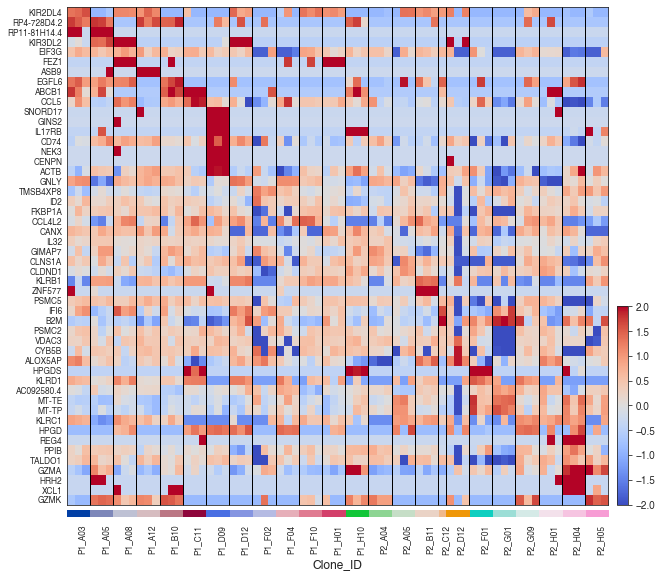

In [319]:
sig_genes = adata.var.F_pval.sort_values()[:50].index
sig_genes = list(adata_z.to_df()[sig_genes].groupby(adata.obs.Clone_ID).mean().idxmax().sort_values().index)

desetfontsize()
sc.pl.heatmap(adata_z, sig_genes, 'Clone_ID', swap_axes=True, cmap='coolwarm', vmin=-2, vmax=2)

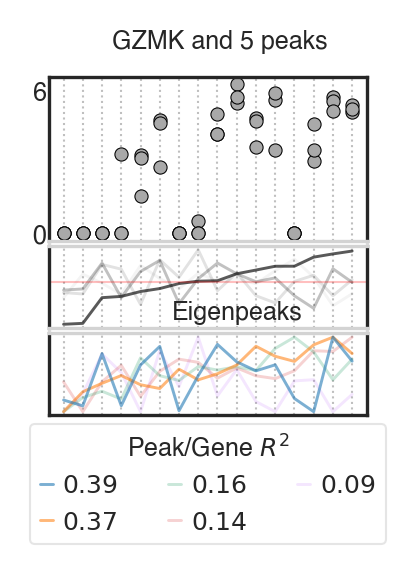

In [333]:
pgplot('GZMK', eigen=True, cutoff=0.05)

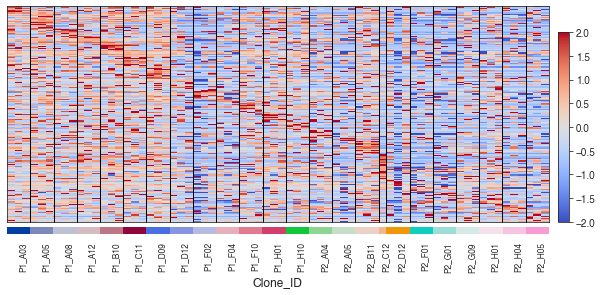

In [231]:
desetfontsize()

sc.pl.heatmap(adata_z, rando_genes, 'Clone_ID', swap_axes=True, cmap='coolwarm', vmin=-2, vmax=2)

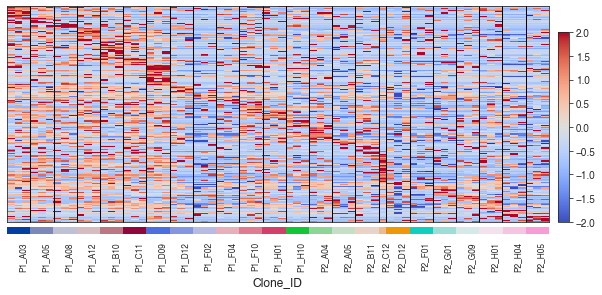

In [218]:
sc.pl.heatmap(adata_z, pro_genes, 'Clone_ID', swap_axes=True, cmap='coolwarm', vmin=-2, vmax=2)

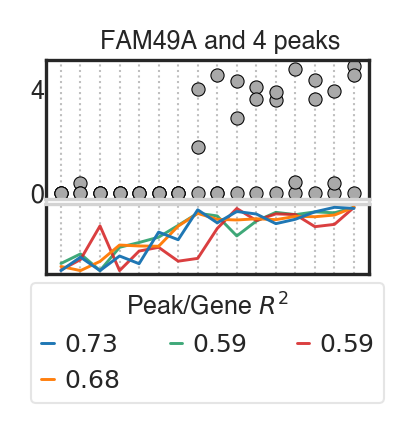

In [167]:
pgplot('FAM49A', window=100000)

In [168]:
np.exp(4) - 1

53.598150033144236

In [169]:
', '.join(pro_scores.sort_values()[-25:].index)

'AC093818.1, CLEC7A, SKAP2, GZMK, UGDH, HSPA9, FAM8A1, HPGD, DOCK5, KLRC4, LINC00861, SLC35B3, AC005083.1, KIR2DL4, RP11-392P7.6, ZBED2, NXPE3, RP11-81H14.4, CCDC152, AMICA1, PLS3-1, GTSF1, SRIP3, AC010970.2, RNA5-8SP6'

In [235]:
len(pro_peaks)

6903

In [236]:
len(enh_peaks)

17122

In [239]:
pro_data = ATAC_data.var.loc[pro_peaks]
enh_data = ATAC_data.var.loc[enh_peaks]
all_data = ATAC_data.var

In [240]:
for df in [pro_data, enh_data, all_data]:
    print(len(df[df.quality_p > 0.1]))
    print(len(df[(df.quality_p > 0.1) & df.clonal_p < 0.01]))
    hrule()

4291
2612
13017
4105
30228
10380


In [269]:
adata.var[adata.var['chr'] == '1'].TSS

gene_name
MTND2P28             565020
hsa-mir-6723         566454
MTATP6P1             569076
RP11-206L10.9        714150
LINC01128            762988
                    ...    
ZNF124            247335307
RP11-488L18.10    247351828
MIR3916           247372795
ZNF692            249152912
PGBD2             249200395
Name: TSS, Length: 1009, dtype: int64

In [286]:
chromes

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 'X',
 'Y']

PeakID      Interval_77062  Interval_51938  Interval_33832  Interval_13433  \
ATAC_clone                                                                   
10_R1             2.928915        2.287843        1.691356        5.560565   
11_R1             2.987230        1.853198        2.670728        5.436592   
13_R1             1.913421        2.070839        2.070839        5.550882   
14_R1             1.827373        1.499256        2.436685        5.567874   
15_R1             2.335525        2.683983        2.465641        5.688357   
15_R2             2.405284        3.251001        2.472925        5.707511   
16_R1             2.246812        0.000000        2.714423        5.558466   
17_R1             2.549848        1.439738        2.006760        5.445604   
18_R1             2.501409        2.734340        2.282356        5.545929   
19_R1             1.948509        2.775430        2.623850        5.629741   
1_R1              2.220971        2.315422        2.116660        5.671244   
1_R2              2.574305        2.743844        2.183737        5.564601   
20_R1             2.707259        2.128885        1.243721        5.444118   
21_R1             1.740334        2.142275        2.142275        5.506553   
22_R1             2.244406        1.836056        1.836056        5.708737   
22_R2             3.193007        2.102691        2.843361        5.701477   
23_R1             1.966361        1.506567        1.684364        5.644652   
23_R2             2.089187        2.495113        2.207124        5.422726   
24_R1             2.262876        2.009289        2.009289        5.711665   
2_R1              2.717578        1.972389        2.088377        5.437860   
3_R1              2.225148        2.426444        2.426444        5.683740   
4_R1              2.464640        3.449496        2.299183        5.493403   
5a_R1             2.751107        2.591159        1.970270        5.644123   
5b_R1             2.779974        2.937437        2.224246        5.609965   
7_R1              2.149178        2.824024        2.065458        5.619921   
8_R1              2.349192        1.845438        2.404186        5.449306   
8_R2              2.764788        1.938780        2.645507        5.587162   
9_R1              2.610464        2.833161        2.774429        5.439472   
9_R2              1.911073        2.905863        2.621405        5.426267   

PeakID      Interval_48454  Interval_27763  Interval_53540  Interval_4280  \
ATAC_clone                                                                  
10_R1             2.287843        3.709698        3.762476       5.194549   
11_R1             2.205004        3.504991        3.114438       5.243369   
13_R1             1.913421        3.751593        3.182416       4.955405   
14_R1             1.499256        3.670255        0.000000       5.240854   
15_R1             1.796163        3.665038        0.890413       5.179786   
15_R2             2.536280        3.984053        0.574085       5.185097   
16_R1             2.246812        4.033247        3.964330       5.195662   
17_R1             2.006760        3.782548        3.326111       5.217739   
18_R1             1.757833        3.732867        2.624641       5.105916   
19_R1             1.707229        3.436920        2.986031       5.123996   
1_R1              2.401717        3.377605        3.313264       4.745931   
1_R2              1.533994        3.179393        3.153849       5.019365   
20_R1             1.243721        3.869145        2.991982       5.031900   
21_R1             2.142275        3.272452        2.885766       4.928832   
22_R1             2.244406        3.383287        1.836056       5.176583   
22_R2             1.986456        3.479647        1.307133       4.987438   
23_R1             1.290173        3.610647        0.000000       4.964272   
23_R2             1.618351        3.594341        1.106046       5.158560   
24_R1             1.668714        2.90259

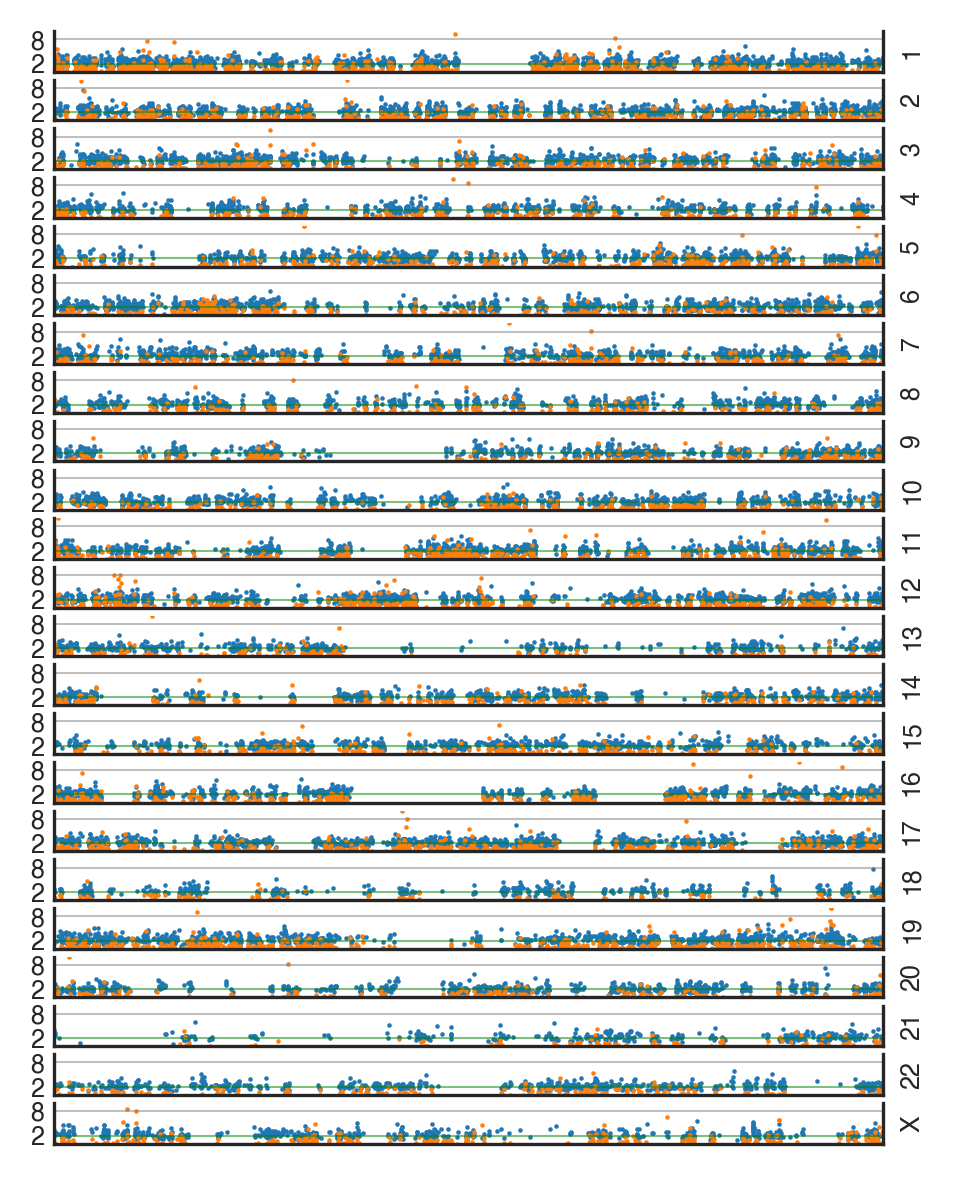

In [310]:
sns.set_style('white')
setfontsize()

fig,ax = plt.subplots(len(chromes)-1,1,figsize=(90*mm, 120*mm), dpi=300)


for j,chrome in enumerate(chromes[:-1]):
    
    ax[j].axhline(2, linewidth=0.5, color='green', alpha=0.5)
    ax[j].axhline(8, linewidth=0.5, color='gray', alpha=0.5)
    
    ad_df = ATAC_data.var[ATAC_data.var['chr'] == chrome]
    ad_df = ad_df[ad_df.quality_p > 0.1]
    x_min = ad_df.start.min()
    x_max = ad_df.end.max()
    #ad_df = ad_df[ad_df.clonal_p < 0.1]
    plot_df = pd.DataFrame(index=ad_df.index)
    plot_df['x'] = ad_df['mid']
    plot_df['y'] = ad_df['adj_fcs'] / np.log(2) # -np.log10(ad_df.clonal_p)
    sns.scatterplot(x='x', y='y', data=plot_df, ax=ax[j], s=1, edgecolor=None)

    
    g_df = adata.var[adata.var['chr'] == chrome]
    #g_df = g_df[g_df.F_pval < 0.01]
    gplot_df = pd.DataFrame(index=g_df.index)
    gplot_df['x'] = g_df['TSS']
    gplot_df['y'] = np.clip(-np.log10(g_df.F_pval),0,10)
    sns.scatterplot(x='x', y='y', data=gplot_df, ax=ax[j], s=1, edgecolor=None)
    y_max= gplot_df['y'].max()
    ax[j].set_xlim(x_min, x_max)
    ax[j].set_ylim(0,10)
    ax[j].set_yticks([2,8])
    ax[j].set_xticks([])
    ax[j].set_ylabel(chrome)
    ax[j].set_xlabel('')
    
    ax[j].tick_params(axis='both', pad=-1)
    #ax[j].yaxis.tick_right()
    ax[j].yaxis.set_label_position("right")
    #if j < len(chromes)-1:
    #    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    
plt.show()

In [243]:
ATAC_data.var[]

PeakID chr        end          in_ensg    in_gene  \
PeakID                                                                      
Interval_77062  Interval_77062   9  115080094  ENSG00000119314      PTBP3   
Interval_51938  Interval_51938   3  156852899             None        nan   
Interval_33832  Interval_33832  19    1672563             None        nan   
Interval_13433  Interval_13433  11   82997741  ENSG00000137500    CCDC90B   
Interval_48454  Interval_48454   3   27493603  ENSG00000033867     SLC4A7   
...                        ...  ..        ...              ...        ...   
Interval_28417  Interval_28417  16   88730354  ENSG00000167508        MVD   
Interval_58433  Interval_58433   5   54298635  ENSG00000164283       ESM1   
Interval_45676  Interval_45676  21   35310937  ENSG00000237945  LINC00649   
Interval_8387    Interval_8387  10   33624658  ENSG00000099250       NRP1   
Interval_17712  Interval_17712  12   96890243  ENSG00000188596   C12orf55   

                       itype          mid      start  quality_p  clonal_p  \
PeakID                                                                      
Interval_77062        intron  115079731.5  115079369   0.152552  0.045662   
Interval_51938      Intergen  156852750.0  156852601   0.028703  0.000815   
Interval_33832      Intergen    1672247.0    1671931   0.029762  0.115377   
Interval_13433  promoter-TSS   82997180.5   82996620   0.010913  0.010109   
Interval_48454        intron   27493042.5   27492482   0.673157  0.540247   
...                      ...          ...        ...        ...       ...   
Interval_28417  promoter-TSS   88729670.5   88728987   0.032045  0.115768   
Interval_58433        intron   54298297.0   54297959   0.664901  0.145547   
Interval_45676          exon   35310572.5   35310208   0.064673  0.006693   
Interval_8387   promoter-TSS   33623619.5   33622581   0.067399  0.000257   
Interval_17712        intron   96889859.5   96889476   0.062587  0.136735   

                max_height  
PeakID                      
Interval_77062   23.361561  
Interval_51938   30.484528  
Interval_33832   16.173389  
Interval_13433  301.374023  
Interval_48454   21.518496  
...                    ...  
Interval_28417  136.937500  
Interval_58433   24.210867  
Interval_45676   34.971249  
Interval_8387   118.396477  
Interval_17712   16.138868  

[40608 rows x 11 columns]

In [314]:
', '.join(adata.var.F_pval.sort_values()[:50].index)

'KIR3DL2, CENPN, GNLY, FKBP1A, GZMK, KIR2DL4, ABCB1, CCL5, HRH2, GZMA, TALDO1, MT-TE, ALOX5AP, IL17RB, AC092580.4, CYB5B, FEZ1, TMSB4XP8, EIF3G, REG4, GINS2, HPGDS, EGFL6, SNORD17, XCL1, KLRC1, ASB9, KLRB1, PSMC2, CCL4L2, VDAC3, CD74, CANX, HPGD, IFI6, PSMC5, RP4-728D4.2, RP11-81H14.4, IL32, ZNF577, ACTB, PPIB, GIMAP7, ID2, NEK3, CLDND1, CLNS1A, KLRD1, MT-TP, B2M'

# Interactive plots with plotly

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
clone_order = list(gene_clonal['GNLY'].sort_values().index)
GNLY_df = pd.DataFrame(adata[adata.obs.Clone_ID.isin(clone_order)].to_df()['GNLY'])
GNLY_df['Clone'] = adata.obs.Clone_ID
GNLY_df['CloneNo'] = GNLY_df['Clone'].apply(lambda cl : clone_order.index(cl))
GNLY_df = GNLY_df.sort_values(by = 'CloneNo')
GNLY_df['Obs'] = GNLY_df.index
GNLY_df.to_csv('GNLY.csv')

In [ ]:
GNLY_df.head()

In [ ]:
PCR_df = PCR_analysis('GNLY', window=50000)
peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
peaklist = [peak for peak in peaklist if PCR_df.loc['GNLY_Rsq',peak] > 0.2]
pplot_df = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()    
pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()
pplot_df

In [ ]:
pplot_df = pplot_df.melt(ignore_index = False)

In [ ]:
pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)
pplot_df = pplot_df[pplot_df.Clone.isin(pg_clones)]
pplot_df['CloneNo'] = pplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
pplot_df.head()
pplot_df

In [ ]:
pplot_df['R'] = pplot_df['PeakID'].map(PCR_ans['GNLY'].loc['GNLY_R'])
pplot_df['R_sq'] = pplot_df['R']**2
pplot_df['Peak location'] = pplot_df['PeakID'].map(ATAC_data.var.loc[peaklist,'mid'])
#pplot_df['end'] = pplot_df['PeakID'].map(ATAC_data.var.loc[peaklist,'end'])
pplot_df = pplot_df.sort_values(by=['CloneNo','R_sq'])
pplot_df

In [ ]:
import altair as alt
gene_chart = alt.Chart(GNLY_df).mark_circle(size=100).encode(
    x={"field": "Clone",
      "type": "ordinal",
       "sort" : clone_order,
       "axis" : alt.Axis(labels=False, title=" ")},
    y='GNLY',
    color='Clone',
    tooltip=['Clone', 'Obs', 'GNLY']
).interactive().properties(
    width=400,
    height=200
)

highlight = alt.selection(type='single', on='mouseover',
                          fields=['PeakID'], nearest=True)

TSS = adata.var.loc['GNLY','TSS']

peak_base = alt.Chart(pplot_df).encode(
    x={"field": "Clone",
               "type": "ordinal",
               "sort" : clone_order},
    y={"field" : "value",
       "type": "quantitative",
       "axis" : alt.Axis(labels=False, title="Peak height")},
    color=alt.Color("PeakID")
)

# interval selection in the bar chart
pts = alt.selection_multi(encodings=["x"])

points = peak_base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=400
)

peak_chart = peak_base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3)), #,
    opacity=alt.Opacity("R_sq", legend=None),
    tooltip=['Clone', 'PeakID', 'value']#,
    ).transform_filter(pts).interactive().properties(
    width=400,
    height=100
)

peak_chart = points + peak_chart


peakR_chart = alt.Chart(pplot_df).mark_bar().encode(
    x={"field":"Peak location", 
       "type":"quantitative",
       "axis":alt.Axis(values=[TSS-50000, TSS, TSS+50000])},
    y="R",
    text="PeakID",
    color="PeakID",
    opacity=alt.condition(~highlight, alt.value(0.1), alt.value(1.0)),
    tooltip=['PeakID','R','R_sq']
    #color=alt.condition(
    #    alt.datum.R > 0,
    #    alt.value("steelblue"),  # The positive color
    #    alt.value("orange")  # The negative color
    #)
).interactive().properties(
    width=300,
    height=50).add_selection(pts)



TSS_line = alt.Chart(pd.DataFrame({'TSS': [TSS]})).mark_rule().encode(
    x=alt.X('TSS'))

peakR_chart = peakR_chart + TSS_line

#peakR_chart = peakR_chart + peakR_text

#peaks_chart = alt.hconcat(peak_chart, peakR_chart)

chart = alt.vconcat(gene_chart, peak_chart, peakR_chart).resolve_scale(
    color='independent')

chart

In [ ]:
chart.save('GNLY.json')

In [ ]:
def pgplotly(gene, protein = None, cutoff=0.2, window=50000):
    if protein:
        num_rows = 3
        specs=[[{"type": "scatter"}],
               [{"type": "line"}],
               [{"type": "line"}]]
    else:
        num_rows = 2
        specs=[[{"type": "scatter"}],
               [{"type": "scatter"}]]
        
    #fig, ax = plt.subplots(num_rows,1,figsize=(2.5,0.75*num_rows), dpi=300, sharex=True,
    #                       gridspec_kw = {'hspace':0.05, 'height_ratios':hr})            
    #
    #plt.rcParams['text.usetex'] = False
    #setfontsize()

    fig = make_subplots(
        rows=num_rows, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        specs=specs
    )




    PCR_df = PCR_analysis(gene, window=window)
    clone_order = list(gene_clonal[gene].sort_values().index)
    
    gplot_df = pd.DataFrame(columns=[gene,'Clone'])
    gplot_df[gene] = adata.to_df()[gene]
    
    
    gplot_df['Clone'] = pd.Categorical(adata.obs.Clone_ID, categories = clone_order, ordered = True)
    gplot_df = gplot_df[gplot_df.Clone.isin(pg_clones)]
    clone_order = [clone for clone in clone_order if clone in pg_clones]
    gplot_df['CloneNo'] = gplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
    gplot_df = gplot_df.sort_values(by='CloneNo')
    gplot_df['Text'] = ''
    for row in gplot_df.index:
        expr = gplot_df.loc[row,gene]
        cl = gplot_df.loc[row,'Clone']
        gplot_df.loc[row,'Text'] = '{} expression {:1.3f} in Clone {}.'.format(gene,expr,cl)
    col_range = list(range(len(gplot_df)))
    #for clone in clone_order:
    #    for row in range(num_rows):
    #        ax[row].axvline(clone,linestyle=':',color='gray',linewidth=0.5, alpha=0.5, zorder=-5)
    
    # GENE EXPRESSION PLOT
    fig.add_trace(
        go.Scatter(
            x=gplot_df['Clone'],
            y=gplot_df[gene],
            mode="markers",
            marker=dict(size=16, 
                        color=gplot_df['CloneNo'], 
                        colorscale=px.colors.qualitative.Dark24),
            text=gplot_df['Text'],
            name="{} expression".format(gene)
        ),
        row=1, col=1)
    
    #sns.scatterplot(x='Clone', y=gene, hue='Clone', data=gplot_df, ax=ax[0], legend=False)
    #gene_ticks = [gplot_df[gene].min(), gplot_df[gene].mean(), gplot_df[gene].max()]
    #ax[0].set_yticks(gene_ticks)
    #ax[0].set_yticklabels(gene_ticks, x=0.03)
    #ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    #ax[0].set_ylabel(gene)
    #ax[0].yaxis.set_label_position("right")
    
    # ATAC PLOT
    peaklist = [peak for peak in PCR_df.index if peak[:8] == 'Interval']
    peaklist = [peak for peak in peaklist if PCR_df.loc[gene+'_Rsq',peak] > cutoff]
    pplot_df = ATAC_data.to_df()[peaklist].groupby(ATAC_data.obs.Clone_ID).mean()
    pplot_df['Clone'] = pd.Categorical(pplot_df.index, categories = clone_order, ordered = True)
    pplot_df = pplot_df[pplot_df.Clone.isin(pg_clones)]
    
    pplot_df[peaklist] = (pplot_df[peaklist] - pplot_df[peaklist].min()) #/ pplot_df[peaklist].max()
    pplot_df[peaklist] = pplot_df[peaklist] / pplot_df[peaklist].max()
    pplot_df['CloneNo'] = pplot_df['Clone'].apply(lambda cl : clone_order.index(cl))
    pplot_df = pplot_df.sort_values(by='CloneNo')
    #
    no_peaks = 0
    for peak in peaklist:
        peak_Rsq = PCR_df.loc[gene+'_Rsq',peak]
        if peak_Rsq > 0.05:
            peak_label = '${:1.2f}$'.format(peak_Rsq)
            no_peaks += 1
        else:
            peak_label = None
        fig.add_trace(
            go.Scatter(
                x=pplot_df['Clone'],
                y=pplot_df[peak],
                mode="lines",
                #text=gplot_df['Text'],
                name=peak
            ),
            row=2, col=1)
        
    
    
    # PROTEIN PLOT
    #if protein:
    #    proplot_df = pd.DataFrame(prot_clonal[protein], columns=[protein])
    #    proplot_df[protein] = proplot_df[protein] - proplot_df[protein].min()
    #    proplot_df[protein] = proplot_df[protein] / proplot_df[protein].max()
    #    proplot_df['Clone'] = proplot_df.index
    #    sns.lineplot(x='Clone', y=protein, data=proplot_df, ax=ax[1], linewidth=0.7)
    #    ax[1].text(1,0.5,protein, ha='left')
    #    ax[1].set_ylabel('Prot')
    #    ax[1].yaxis.set_label_position("right")
    #    ax[1].set_yticks([])
    #    ax[1].set_xlabel('')
    #    ax[1].spines['top'].set_color('lightgray')
    #    ax[1].spines['bottom'].set_color('lightgray')
    

    if protein:
        title = '{}, {}, and {} peaks.'.format(gene, protein, len(peaklist))
    else:
        title = '{} and {} peaks.'.format(gene, len(peaklist))
    #plt.suptitle(title, y=1.02)
    
    # Plot legend
    #if no_peaks <= 6:
    #    ncol = no_peaks
    #else:
    #    ncol = (no_peaks + 1)//2
    #lgnd = plt.legend(bbox_to_anchor=(0.5, 0.05), title = 'Peak/Gene $R^2$',  
    #                  loc=9, ncol=ncol, framealpha=0.5)
    #lgnd.get_frame().set_linewidth(0.5)
    
    # Save and show figure.
    #set_size(fig, (2.5, 1.5))
    #plt.savefig("Panels/MultiPlots/{}_multi.pdf".format(gene), bbox_inches='tight')
    #plt.show()
    fig.show()
    fig.write_html("Plotly/{}_plotly.html".format(gene), include_plotlyjs=False)
    

In [ ]:
pgplotly('GNLY')